In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [239]:
drive_dir = '/content/drive/MyDrive/AIF/'
original_file_path = 'Dataset_2.0_Akkodis.xlsx'
no_dup_file_path = 'Dataset_2.0_Akkodis_no_dup.xlsx'
evaluated_file_path = 'Dataset_2.0_Akkodis_evaluated.xlsx'
suitable_file_path = 'Dataset_2.0_Akkodis_suitable.xlsx'
cleaned_file_path = 'Dataset_2.0_Akkodis_cleaned.xlsx'
clean2_file_path = 'Dataset_2.0_Akkodis_cleaned2.xlsx'
job_file_path = 'Dataset_2.0_Akkodis_Job_Offers.xlsx'
candidates_file_path = 'Dataset_2.0_Akkodis_candidates.xlsx'
elig_candidates_file_path = 'Dataset_2.0_Akkodis_elig_candidates.xlsx'
final_file_path = 'Dataset_2.0_Akkodis_final.xlsx'
it_csv_path = 'it.csv'
italy_geo_path = 'italy_geo.xlsx'
countries_csv_path = 'countries.csv'

####Imports

In [3]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
from google.colab import files
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from geopy.distance import geodesic
from sklearn.metrics.pairwise import cosine_similarity

np.random.seed(42)

####Utils

In [4]:
stop_words = list(ENGLISH_STOP_WORDS)

In [5]:
#percentage of candidates that have no value (i.e. 'not specified') for that column, in each row of the candidate
def null_percentage(df, col, n_candidates):
  null_counts = df.groupby('Id')[col].apply(lambda x: (x == 'not specified').all())
  total_null_ids = null_counts.sum()
  return total_null_ids / n_candidates * 100


In [6]:
#percentage of candidates that have more than n value specified for the same column 'col' (other than 'Not Specified')
def multiple_percentage(df, col, n, n_candidates):
  multiple_counts = df.groupby('Id')[col].apply(lambda x: x[x != 'not specified'].nunique())
  ids_with_multiple_values = multiple_counts[multiple_counts > n-1]
  return len(ids_with_multiple_values) / n_candidates * 100

In [7]:
def getHist(df, col, order):
  counts = Counter(df.groupby('Id')[col].first())
  counts_df = pd.DataFrame(counts.items(), columns=[col, 'Count'])
  prefix = ''
  counts_df[col] = counts_df[col].astype(str)
  if order is not None and len(order):
    counts_df[col] = pd.Categorical(counts_df[col], categories=order, ordered=True)
    counts_df = counts_df.sort_values(by=col, ascending=True)
  else:
    counts_df = counts_df.sort_values(by='Count', ascending=False)
  if counts_df.shape[0] > 20:
    counts_df = counts_df.head(20)
    prefix = 'Top 20 '
  counts_df.plot(x=col, y='Count', kind='bar', legend=False)
  plt.title(f'{prefix}{col} Distribution')
  plt.ylabel('Frequency')
  plt.xlabel(col)
  plt.show()

In [8]:
def getPie(df, col):
  counts = Counter(df.groupby('Id')[col].first())
  counts_df = pd.DataFrame(counts.items(), columns=[col, 'Count'])
  labels = counts_df[col]
  sizes = counts_df['Count']

  patches, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
  plt.show()

In [9]:
def plot_graphs(filtered_df, statCol, value,):
    filtered_count = (filtered_df.groupby('Id')[statCol].last()).value_counts() #keeps most recent value of statCol

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    filtered_count.plot(kind='bar', ax=axes[0], legend=False, color='skyblue')
    axes[0].set_title(f'{statCol} Counts for {value}', fontsize=10)
    axes[0].set_ylabel('Frequency', fontsize=8)
    axes[0].set_xlabel('Candidate State', fontsize=8)
    axes[0].tick_params(axis='x', rotation=45, labelsize=8)
    axes[0].tick_params(axis='y', labelsize=8)

    wedges, texts, autotexts = axes[1].pie(
        filtered_count,
        labels=filtered_count.index,
        autopct='%1.0f%%',
        textprops={'fontsize': 8},
        colors=plt.cm.Paired.colors,
        labeldistance=1.2,
        pctdistance=0.8
    )
    axes[1].set_title(f'{statCol} Distribution for {value}', fontsize=10)

    plt.tight_layout(pad=2)
    fig.subplots_adjust(wspace=0.2)
    plt.show()

In [10]:
def getStats(col, value):
    filtered_df = df[df[col] == value]
    filtered_candidates = filtered_df['Id'].unique()
    print(f"{len(filtered_candidates)} ({len(filtered_candidates)/len(candidates)*100:.2f}%) candidates have '{value}' as {col} \n(in at least one row)\n\n")
    filtered_df = df[df['Id'].isin(filtered_candidates)]

    ids = filtered_df[filtered_df['Job Family Hiring'] == 'not specified']['Id'].unique().tolist()
    null_counts = len(ids) / len(filtered_candidates) * 100
    print(f"{null_counts:.2f}% of candidates ({len(ids)}) with '{value}' (in at least one row) have no Job Position specified\n \n\n")

    plot_graphs(filtered_df, 'Candidate State', value)
    print("\n\n")
    plot_graphs(filtered_df, 'Event_Type__Val', value)


In [11]:
def getJStats(df, col):
  filtered_count = df[col].value_counts()
  num = df[df[col] == 'not specified'].shape[0]
  print(f"There are {num} ({num/df.shape[0]*100:.2f}%) 'not specified' for <{col}>\n\n")
  filtered_count = filtered_count[filtered_count.index != 'not specified']

  fig, axes = plt.subplots(1, 2, figsize=(14, 4))

  filtered_count.plot(kind='bar', ax=axes[0], legend=False)
  axes[0].set_title(f'{col} Distribution')
  axes[0].set_ylabel('Frequency')
  axes[0].set_xlabel(f'{col}')

  axes[1].pie(filtered_count, labels=filtered_count.index, autopct='%1.0f%%', textprops={'fontsize': 8})
  axes[1].set_title(f'{col} Distribution')

  plt.show()

In [12]:
def getJobStats():
  for col in job_offer_columns:
    if col not in descr_job_offer_col:
      getJStats(job_offers_df, col)
      print("\n\n")

In [13]:
def custom_mean(x):
  numeric_values = x[x != 'not specified'].astype(float)
  if numeric_values.empty:
    return 'not specified'
  return int(round(numeric_values.mean()))

In [14]:
def check_values(val):
  if isinstance(val, str):
    for n in values:
      if n in val:
        return n
  return np.nan

In [15]:
def check_order(group):
    return (group['Age Range Numeric'].astype(int).diff() >= 0).all()

In [16]:
def tokenize_and_filter(text):
    if pd.isnull(text):
        return []
    if text == 'not specified':
        return text
    words = re.findall(r'\b\w+(?:[-&]\w+)*\b', text.lower())
    filtered_words = [word for word in words if word not in ENGLISH_STOP_WORDS and len(word) > 1]
    return filtered_words

In [17]:
def job_id_finder(row, job_df):
  for col in job_df.columns:
    if col != 'ID':
      job_df = job_df[job_df[col] == row[col]]
      if job_df.shape[0] == 0:
        return None
      elif job_df.shape[0] == 1:
        return job_df.iloc[0]['ID']
  print(job_df)
  return job_df.iloc[0]['ID']

In [18]:
def calculate_distance(row):
    residence_coords = row['Residence_coord']
    job_coords = row['Assumption_coord']
    if residence_coords and job_coords:
        return geodesic(residence_coords, job_coords).km
    return None

In [19]:
def clean_text(text):
    if text == 'not specified':
        return ''
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'[^a-z0-9, ]', '', text)
    text = " ".join(dict.fromkeys(text.split()))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [20]:
def check_study_title(job_st, st):
  if st == 'not specified' and job_st == 'not specified':
    return 0
  if st == 'not specified':
    return -1
  if job_st == 'not specified':
    return 0
  return round((study_title_order[st] - study_title_order[job_st]) / len(list(study_title_order.keys())), 2)

In [21]:
def check_years_exp(job_ye, ye):
  if ye == 'not specified' and job_ye == 'not specified':
    return 0
  if ye == 'not specified':
    return -1
  if job_ye == 'not specified':
    return 0
  return round((years_exp_order[ye] - years_exp_order[job_ye]) / 20, 2)

In [22]:
def check_ral(job_ral, ral):
  if ral == 'not specified' or job_ral == 'not specified':
    return 0
  return round((ral_order[job_ral] - ral_order[ral]) / 60, 2)

# Dataset Analysis for AKKODIS


## Overview

The Akkodis Dataset consists of 40 columns and 21,277 entries. Each candidate is identified by its `ID` and can appear in more than one row, each one specific for an `Event_type__val`.

In [23]:
#dataset load
df = pd.read_excel(drive_dir + original_file_path)

In [24]:
#column names cleaning
df.columns = df.columns.str.lstrip()
df.columns = df.columns.str.title()
df.rename(columns={'Comunication': 'Communication'}, inplace=True)

In [25]:
#candidates list
candidates = df['Id'].unique().tolist()
print(f"There are {len(candidates)} candidates in the dataset")

There are 12263 candidates in the dataset


In [26]:
df.groupby('Id')['Candidate State'].last().value_counts(normalize=True)

Candidate State
Imported             0.545625
First contact        0.243823
In selection         0.152654
Hired                0.036533
QM                   0.014760
Economic proposal    0.005219
Vivier               0.001386
Name: proportion, dtype: float64

In [27]:
original_df = df.copy()


## Dataset Description

### Features

The features can be divided in:
* **CANDIDATE FEATURES**
  * **ID**: unique identifier for the candidate
  * **Candidate State**: status of the candidate's application
    * `Hired`: the candidate has been selected
    * `Vivier`: the candidate's skills do not correspond to the requested skills for the position they are being evaluated, but will be taken in consideration for future opportunities in Akkodis
    * `QM`: Qualification Meeting
    * `In selection`: selection phase
    * `First contact`: the candidate has been contacted from the company for the first time (i.e. first call)
    * `Economic proposal`: the company has made a proposal to the candidate
    * `Imported`: the candidate has been transfered from another DB (i.e. Alma Laurea)
  
   Possible chronological orders for candidate status:
    * `In selection` > `First contact` > `QM` > `Economic Proposal` > `Hired`  (complete cycle with positive outcome)
    * `First contact` > `In selection` > `QM` > `Vivier`
    * `First contact` > `In selection` > `QM`
    * `First contact` > `In selection`
  * **Age Range**: range of age for the candidate
    * `< 20`
    * `20 - 25`
    * `26 - 30`
    * `31 - 35`
    * `36 - 40`
    * `40 - 45`
    * `> 45`
  * **Residence**: current place of residence for the candidate
  * **Sex**: gender identification (`Male|Female`)
  * **Protected Category**: indicates if the candidate falls into a protected category
    * `Article 1`
    * `Article 18`
    * Not Specified
  * **TAG**: keywords used by recruiter
  * **Study Area**: Field of study or academic discipline of the candidate
  * **Study Title**: Academic degree or title obtained by the candidate
    * `Five-year degree`
    * `Doctorate`
    * `High school graduation`
    * `Three-year degree`
    * `master's degree`
    * `Professional qualification`
    * `Middle school diploma`
  * **Years Experience**: number of years of professional experience of the candidate
    * `0`
    * `0-1`
    * `1-3`
    * `3-5`
    * `5-7`
    * `7-10`
    * `+10`
  * **Sector**: industry or sector in which the candidate has experience
  * **Last Role**: candidate's most recent job role
  * **Year of Insertion**: year when the candidate's information was entered into the portal
  * **Year of Recruitment**: year in which the candidate was hired
  * **Current Ral**: current or existing salary
  * **Expected Ral**: expected salary
  
  Values present only if the candidate have moved forward in the recruiting process:
  * **Technical Skills**: skills related to technical or specialized expertise from 1 to 4
  * **Standing/Position**: standing or position within the organization from 1 to 4 **??**
  * **Comunication**: communication skills from 1 to 4
  * **Maturity**: level of maturity from 1 to 4
  * **Dynamism**: level of Dynamism from 1 to 4
  * **Mobility**: mobility from 1 to 4
  * **English**: proficiency in the English language from 1 to 4
* **HIRING PROCESS FEATURES**
  * **Event_type__val**: It specifies the stage of the recruitment process for the candidate
  * **Event_feedback**: feedback received from an event (`OK|KO`)
  * **Overall**: overall assessment, interview score
    * `1 - Low` or `~ 1 - Low`
    * `2 - Medium` or `~ 2 - Medium`
    * `3 - High` or `~ 3 - High`
    * `4 - Top` or `~ 4 - Top`
  * **Akkodis headquarters**: headquarters location for Akkodis
* **JOB POSITION FEATURES**: these features are present only if the candidate has been hired
  * **Recruitment Request**: represents the application request for a candidacy
  * **Assumption Headquarters**: headquarters location associated with the hiring assumption
  * **Job Family Hiring**: Job family or category for the hiring position
  * **Job Title Hiring**: specific job title for the hiring position
  * **Job Description**: description of the job role
  * **Candidate Profile**: ideal profile information for the candidate, requested by the company
  * **Years Experience.1**: additional field for specifying years of experience requested
  * **Minimum Ral** (Gross Annual Salary): minimum expected gross annual salary
  * **Ral Maximum**: maximum expected gross annual salary
  * **Study Level**: level of study requested for the job position, the values are equivalent to `Study Title`
  * **Study Area.1**: additional field for specifying the academic field of study requested
  * **Linked_search_key**: indicates the number of searches conducted for a job position




In [28]:
job_offer_columns = ['Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring', 'Job Title Hiring',
                     'Job Description', 'Candidate Profile', 'Years Experience.1','Minimum Ral', 'Ral Maximum',
                     'Study Level', 'Study Area.1', 'Linked_Search__Key']

In [29]:
akkodis_col = ['Id','Akkodis Headquarters', 'Event_Feedback', 'Event_Type__Val', 'Overall']

In [30]:
candidate_col = ['Id', 'Age Range', 'Candidate State', 'Communication', 'Dynamism', 'English',
       'Last Role', 'Maturity', 'Mobility', 'Protected Category', 'Residence',
       'Sector', 'Sex', 'Standing/Position', 'Study Area', 'Study Title',
       'Tag', 'Technical Skills', 'Year Of Insertion', 'Year Of Recruitment',
       'Years Experience', 'Current Ral', 'Expected Ral']

## NaN Handling & Cleaning

In [31]:
numerical_cols = [ 'Id', 'Year Of Insertion', 'Year Of Recruitment', 'Overall', 'Technical Skills', 'Standing/Position', 'Communication',
       'Maturity', 'Dynamism', 'Mobility', 'English']

In [32]:
substitutions = {
    r'\bsr\b(?![a-zA-Z0-9])': 'senior',
    r'\beng\b(?![a-zA-Z0-9])': 'engineer',
    r'\bing\b(?![a-zA-Z0-9])': 'engineer',
    r'\bback end\b(?![a-zA-Z0-9])': 'back-end',
    r'\bfront end\b(?![a-zA-Z0-9])': 'front-end',
    r'\bbm\b(?![a-zA-Z0-9])': 'business-manager',
    r'\bhr\b(?![a-zA-Z0-9])': 'human resources',
    r'\bsw\b(?![a-zA-Z0-9])': 'software',
    r'\bhw\b(?![a-zA-Z0-9])': 'hardware',
    r'\bjr.\b(?![a-zA-Z0-9])': 'junior',
    r'\bjr\b(?![a-zA-Z0-9])': 'junior'
}

In [33]:
#nan cleaning for job columns
for col in job_offer_columns:
  if col != 'Linked_Search__Key':
    df[col] = df[col].replace([np.nan, ''], 'not specified')
    df[col] = df[col].fillna('not specified')
    df[col] = df[col].str.lstrip()
    df[col] = df[col].str.rstrip()
    df[col] = df[col].str.lower()
    if col == 'Candidate Profile':
      df[col] = df[col].replace([0, '.', '(coming soon)', '-', 'x', 'ok', 'anyone', 'replacement'], 'not specified')
    if col == 'Job Title Hiring':
      df[col] = df[col].replace('???', 'not specified')
    if col == 'Job Description':
      df[col] = df[col].replace(['.','ok','replacement'], 'not specified')
    if 'Ral' in col:
      df[col] = df[col].replace(['not avail.', 'not available'], 'not specified')
      df[col] = df[col].str.replace('- ','-')
      df[col] = df[col].str.replace('+ ','+')
      df[col] = df[col].replace('20k', '-20k')
    if col == 'Study Area.1':
      df[col] = df[col].replace('other', 'not specified')
    if col == 'Assumption Headquarters':
      df[col] = df[col].replace('the eagle', 'l"aquila')
      df[col] = df[col].replace('toasts', 'brindisi')
    df[col] = df[col].str.lstrip()
    if col != 'Assumption Headquarters':
      for pattern, replacement in substitutions.items():
        df[col] = df[col].str.replace(pattern, replacement, regex=True)
    df[col] = df[col].replace([np.nan, ''], 'not specified')
    df[col] = df[col].fillna('not specified')

In [34]:
#to detect default values
for col in job_offer_columns:
    values = df[col].unique().tolist()
    try:
      if len(values) < 30:
        print(f"Possible values for <{col}>: \n {np.sort(values)}\n\n")
      else:
        values = [s for s in values if len(s) < 25]
        print(f"Possible short values for <{col}>: \n {np.sort(values)}\n\n")
    except:
      values = [s for s in values if isinstance(s, int) or isinstance(s, float)]
      print(f"Error {col}: {values}\n\n")

Possible short values for <Recruitment Request>: 
 ['accountant' 'administrative employee' 'aeroelastic analysis'
 'airworthiness engineer' 'analytical chemistry' 'application engineer'
 'business analyst' 'business manager' 'business manager 2'
 'business manager 3' 'business managers 1' 'business managers 5' 'buyer'
 'buyer - milan' 'c++ developer' 'c++ software development'
 'calibration engineer' 'chassis control engineer' 'chemical technician'
 'cobol' 'construction engineer' 'construction manager' 'control engineer'
 'control system engineer' 'controllers' 'controlling support'
 'cyber security engineer' 'data analyst' 'data scientist engineer.'
 'design engineer' 'designer catia' 'digital - cloud/backend'
 'document controller' 'dre chassis engineer' 'e/e system engineer'
 'electrical design' 'electrical designer' 'embedded c/c++ software'
 'embedded engineers' 'emc' 'equipment engineer' 'ertms v&v engineer'
 'fem analyst' 'flight manuals update' 'front-end developer'
 'full sta

In [35]:
df['Protected Category'] = df['Protected Category'].replace([np.nan, ''], 'No')

In [36]:
for col in df.columns:
  if col not in numerical_cols and col not in job_offer_columns:
    df[col] = df[col].replace('', 'not specified')
    df[col] = df[col].fillna('not specified')
    df[col] = df[col].str.lstrip()
    df[col] = df[col].str.rstrip()
    df[col] = df[col].str.lower()
    if col == 'Tag':
      df[col] = df[col].replace([',', '-', '.', '..', '., x','/', 'x' ], 'not specified') #assuming these values as default values
      df[col] = df[col].str.lstrip('-, ')
      df[col] = df[col].str.lstrip(',, ')
      df[col] = df[col].str.lstrip('., ')
      df[col] = df[col].str.lstrip('..., ')
      df[col] = df[col].str.lstrip('/, ')
      df[col] = df[col].str.rstrip(', x')
      df[col] = df[col].str.replace("'", "")
    if col == 'Last Role':
      df[col] = df[col].replace(['-', '.', '/', '????'], 'not specified')
      df[col] = df[col].replace(['no', 'unemployed'], 'none')
    if 'Ral' in col:
      df[col] = df[col].replace(['not avail.', 'not available'], 'not specified')
      df[col] = df[col].str.replace('- ','-')
      df[col] = df[col].str.replace('+ ','+')
      df[col] = df[col].str.replace(' k','k')
      df[col] = df[col].replace('20k', '-20k')
    if col in ['Tag', 'Last Role']:
      for pattern, replacement in substitutions.items():
        df[col] = df[col].str.replace(pattern, replacement, regex=True)
    df[col] = df[col].replace([np.nan, ''], 'not specified')
    df[col] = df[col].fillna('not specified')

In [37]:
#to detect default values
for col in df.columns:
  if col not in numerical_cols and col not in job_offer_columns:
    values = df[col].unique().tolist()
    try:
      if len(values) < 30:
        print(f"Possible values for <{col}>: \n {np.sort(values)}\n\n")
      else:
        values = [s for s in values if len(s) < 15]
        print(f"Possible short values for <{col}>: \n {np.sort(values)}\n\n")
    except:
      values = [s for s in values if isinstance(s, int) or isinstance(s, float)]
      print(f"Error {col}: {values}\n\n")

Possible values for <Candidate State>: 
 ['economic proposal' 'first contact' 'hired' 'imported' 'in selection'
 'qm' 'vivier']


Possible values for <Age Range>: 
 ['20 - 25 years' '26 - 30 years' '31 - 35 years' '36 - 40 years'
 '40 - 45 years' '< 20 years' '> 45 years']


Possible short values for <Residence>: 
 ['ethiopia' 'not specified' 'ussr' 'yugoslavia']


Possible values for <Sex>: 
 ['female' 'male']


Possible values for <Protected Category>: 
 ['article 1' 'article 18' 'no']


Possible short values for <Tag>: 
 ['abacus' 'abacus, creo' 'abaqus' 'acoustics, fem' 'acquisitions'
 'adas, controls' 'administration' 'aerodynamics' 'aeronautics'
 'aerospace' 'airspace' 'ait expert' 'ait, e/e' 'algorithms' 'ansys'
 'approval' 'ar/vr' 'architect' 'areospace' 'aspen hysys' 'autocad'
 'automation' 'automation, it' 'automotive' 'aws' 'aws, jira' 'azure'
 'azure cloud' 'back-end, java' 'backend' 'battery' 'bid management'
 'biomedica' 'biomedical' 'blockchain' 'business' 'buyer' 'c' 'c

In [38]:
#Year Of Insertion
print(f"Original values for <Year Of Insertion>: \n{df['Year Of Insertion'].unique()}")

df['Year Of Insertion'] = df['Year Of Insertion'].fillna(np.nan)
df['Year Of Insertion'] = df['Year Of Insertion'].str.extract(r'(\d{4})')
df['Year Of Insertion'] = pd.to_numeric(df['Year Of Insertion'], errors='coerce')

print(f"New values for <Year Of Insertion>: \n{df['Year Of Insertion'].unique()}")

Original values for <Year Of Insertion>: 
['[2018]' '[2019]' '[2020]' '[2021]' '[2022]' '[2023]']
New values for <Year Of Insertion>: 
[2018 2019 2020 2021 2022 2023]


In [39]:
#Year Of Recruitment
print(f"Original values for <Year Of Recruitment>: \n{df['Year Of Recruitment'].unique()}")

df['Year Of Recruitment'] = df['Year Of Recruitment'].fillna(np.nan)
df['Year Of Recruitment'] = df['Year Of Recruitment'].str.extract(r'(\d{4})')
df['Year Of Recruitment'] = pd.to_numeric(df['Year Of Recruitment'], errors='coerce')

print(f"New values for <Year Of Recruitment>: \n{df['Year Of Recruitment'].unique()}")

Original values for <Year Of Recruitment>: 
['[2021]' nan '[2018]' '[2019]' '[2022]' '[2020]' '[2023]' '[2024]']
New values for <Year Of Recruitment>: 
[2021.   nan 2018. 2019. 2022. 2020. 2023. 2024.]


In [40]:
print(f"Original values for <Overall>:\n {df['Overall'].unique()}")
values = ['1', '2', '3', '4']

df['Overall'] = df['Overall'].fillna(np.nan)
df['Overall'] = df['Overall'].apply(check_values)
df['Overall'] = pd.to_numeric(df['Overall'], errors='coerce')

print(f"New values for <Overall>:\n {df['Overall'].unique()}")

Original values for <Overall>:
 [nan '~ 2 - Medium' '~ 3 - High' '2 - Medium' '~ 4 - Top' '~ 1 - Low'
 '3 - High' '1 - Low' '4 - Top']
New values for <Overall>:
 [nan  2.  3.  4.  1.]


In [41]:
col_nan = df.columns[df.isnull().any()].tolist()
print(f'Columns that still contain NaN values:\n {col_nan}')

Columns that still contain NaN values:
 ['Year Of Recruitment', 'Linked_Search__Key', 'Overall', 'Technical Skills', 'Standing/Position', 'Communication', 'Maturity', 'Dynamism', 'Mobility', 'English']


In [42]:
for col in col_nan:
  df[col] = df[col].fillna('not specified')
  print(f"Unique values for <{col}>:\n {df[col].unique()}")

Unique values for <Year Of Recruitment>:
 [2021.0 'not specified' 2018.0 2019.0 2022.0 2020.0 2023.0 2024.0]
Unique values for <Linked_Search__Key>:
 ['not specified' 'RS18.0145' 'RS18.0114' ... 'RS23.0021' 'RS23.0886'
 'RS23.0793']
Unique values for <Overall>:
 ['not specified' 2.0 3.0 4.0 1.0]
Unique values for <Technical Skills>:
 ['not specified' 2.0 3.0 1.0 4.0]
Unique values for <Standing/Position>:
 ['not specified' 2.0 3.0 1.0 4.0]
Unique values for <Communication>:
 ['not specified' 1.0 2.0 3.0 4.0]
Unique values for <Maturity>:
 ['not specified' 2.0 3.0 1.0 4.0]
Unique values for <Dynamism>:
 ['not specified' 2.0 3.0 1.0 4.0]
Unique values for <Mobility>:
 ['not specified' 3.0 2.0 1.0 4.0]
Unique values for <English>:
 ['not specified' 3.0 4.0 2.0 1.0]


## Custom order for categorical columns

### Candidate State
Possible chronological orders (*provided by Akkodis*) for candidate status:
  * `First contact` > `In selection` > `QM` > `Economic Proposal` > `Hired`  (complete cycle with positive outcome)
  * `First contact` > `In selection` > `QM` > `Vivier`
  * `First contact` > `In selection` > `QM`
  * `First contact` > `In selection`

In [43]:
costum_order = ['imported', 'first contact', 'in selection', 'qm', 'vivier', 'economic proposal', 'hired']
df['Candidate State'] = pd.Categorical(df['Candidate State'], categories=costum_order, ordered=True)

### Age Range

In [44]:
custom_order = ['< 20 years', '20 - 25 years', '26 - 30 years',
                '31 - 35 years', '36 - 40 years', '40 - 45 years', '> 45 years']
df['Age Range'] = pd.Categorical(df['Age Range'], categories=custom_order, ordered=True)

### Years Experience & Years Experience.1

In [45]:
print(df['Years Experience'].unique())
print(df['Years Experience.1'].unique())

['[1-3]' '[7-10]' '[3-5]' '[5-7]' '[0]' '[+10]' '[0-1]']
['[1-3]' 'not specified' '[0-1]' '[3-5]' '[7-10]' '[5-7]' '[0]' '[+10]']


In [46]:
custom_order = ['not specified', '[0]', '[0-1]', '[1-3]', '[3-5]', '[5-7]', '[7-10]', '[+10]']
df['Years Experience'] = pd.Categorical(df['Years Experience'], categories=custom_order, ordered=True)
df['Years Experience.1'] = pd.Categorical(df['Years Experience.1'], categories=custom_order, ordered=True)

### RAL

In [47]:
for col in df.columns:
  if 'Ral' in col:
    custom_order = np.sort(df[col].unique().tolist()).tolist()
    custom_order.remove('not specified')
    custom_order.insert(0, 'not specified')
    custom_order.remove('+50k')
    custom_order.append('+50k')
    print(f"{col} custom order: {custom_order}")
    df[col] = pd.Categorical(df[col], categories=custom_order, ordered=True)

Minimum Ral custom order: ['not specified', '-20k', '20-22k', '22-24k', '24-26k', '26-28k', '28-30k', '30-32k', '32-34k', '34-36k', '36-38k', '38-40k', '40-42k', '+50k']
Ral Maximum custom order: ['not specified', '-20k', '20-22k', '22-24k', '24-26k', '26-28k', '28-30k', '30-32k', '32-34k', '34-36k', '36-38k', '38-40k', '40-42k', '42-44k', '44-46k', '48-50k', '+50k']
Current Ral custom order: ['not specified', '-20k', '20-22k', '22-24k', '24-26k', '26-28k', '28-30k', '30-32k', '32-34k', '34-36k', '36-38k', '38-40k', '40-42k', '42-44k', '44-46k', '46-48k', '48-50k', '+50k']
Expected Ral custom order: ['not specified', '-20k', '20-22k', '22-24k', '24-26k', '26-28k', '28-30k', '30-32k', '32-34k', '34-36k', '36-38k', '38-40k', '40-42k', '42-44k', '44-46k', '46-48k', '48-50k', '+50k']


### **Study Title**
Here is a possible order for `Study Title`, based on academic importance and chronological order:

1. **Middle school diploma** *(Basic level of compulsory education)*
2. **Professional qualification** *(Professional certification - specific non-academic training)*
3. **High school graduation** *(Pre-university level)*
4. **Three-year degree** *(Bachelor's degree - first level of academic education)*
5. **Five-year degree** *(Master's degree or single cycle - advanced academic training)*
6. **Master's degree** *(Post-graduate master's degree - professional or academic specialization)*
7. **Doctorate** *(Doctorate of research - highest level of academic education)*

In [48]:
costum_order = ['middle school diploma', 'professional qualification', 'high school graduation',
                'three-year degree', 'five-year degree', 'master\'s degree', 'doctorate']

In [49]:
df['Study Title'] = pd.Categorical(df['Study Title'], categories=costum_order, ordered=True)

## Feature Mapping
Feature mapping can be used to simplify the values in the dataset.

### **Protected Category**

In [50]:
print(f"Original values for <Protected Category>:\n {df['Protected Category'].unique()}")

Original values for <Protected Category>:
 ['no' 'article 1' 'article 18']


In [51]:
df['Protected Category'] = df['Protected Category'].replace(['article 18', 'article 1'], 'yes')
df['Protected Category'] = df['Protected Category'].replace('not specified', 'no')
print(f"New values for <Protected Category>:\n {df['Protected Category'].unique()}")

New values for <Protected Category>:
 ['no' 'yes']


### **Residence**
Mapping can be used to simplify this feature.

In [52]:
print(df['Residence'].unique())

['turin » turin ~ piedmont' 'conversano » bari ~ puglia'
 'caserta » caserta ~ campania' ...
 'san felice a cancello » caserta ~ campania'
 'perdifumo » salerno ~ campania'
 'palmanova » udine ~ friuli venezia giulia']


In [53]:
residence_list = df['Residence'].unique()
country_list = [s for s in residence_list if ('(state)' in s) or ('(overseas)' in s) or ('ethiopia' in s) or ('south african republic' in s) or ('ussr' in s) or ('yugoslavia' in s)]
country_list = [s.split(' » ')[0] for s in [s.split(' ~ ')[0] for s in country_list]]
country_list = sorted(set(country_list))
print(f"List of residence countries of the candidates in the dataset:\n {country_list}")


List of residence countries of the candidates in the dataset:
 ['albania', 'algeria', 'argentina', 'austria', 'bahrain', 'belarus', 'belgium', 'brazil', 'bulgaria', 'chile', "china people's republic", 'colombia', 'croatia', 'czech republic', 'egypt', 'eritrea', 'ethiopia', 'france', 'germany', 'great britain-northern ireland', 'greece', 'grenada', 'haiti', 'india', 'indonesia', 'iran', 'italy', 'kazakhstan', 'kuwait', 'lebanon', 'libya', 'lithuania', 'malaysia', 'malta', 'mexico', 'monaco', 'morocco', 'netherlands', 'nigeria', 'oman', 'pakistan', 'philippines', 'portugal', 'qatar', 'republic of poland', 'romania', 'russian federation', 'saint lucia', 'saint pierre et miquelon (islands)', 'san marino', 'serbia and montenegro', 'singapore', 'slovakia', 'south african republic', 'spain', 'sri lanka', 'sweden', 'switzerland', 'syria', 'tonga', 'tunisia', 'türkiye', 'ukraine', 'united arab emirates', 'united states of america', 'ussr', 'uzbekistan', 'venezuela', 'yugoslavia']


In [54]:
italy_list = [s for s in residence_list if ('(state)' not in s) and ('(overseas)' not in s) and ('ethiopia' not in s) and ('south african republic' not in s) and ('ussr' not in s) and ('yugoslavia' not in s)]
italy_city = [s.split('»')[0].strip() if ' » ' in s else 'not specified' for s in italy_list]
italy_city = sorted(set(italy_city))
print(f"List of residence italian cities of the candidates in the dataset:\n {italy_city}")
italy_province = [s.split('»')[1].strip() if ' » ' in s else 'not specified' for s in italy_list]
italy_province = [s.split('~')[0].strip() if ' ~ ' in s else s for s in italy_province]
italy_province = sorted(set(italy_province))
print(f"List of residence italian provinces of the candidates in the dataset:\n {italy_province}")
italy_list = [s.split('~')[-1].strip() for s in italy_list]
italy_list = sorted(set(italy_list))
print(f"List of residence italian regions of the candidates in the dataset:\n {italy_list}")

List of residence italian cities of the candidates in the dataset:
 ['abano terme', 'abbadia alpina', 'abbadia lariana', 'abbadia san salvatore', 'abbasanta', 'abbiategrasso', 'abriola', 'acate', 'accadia', 'acceptance', 'acciano', 'acerra', 'aci catena', "aci sant'antonio", 'acireale', 'acquapendente', 'acquaviva delle fonti', 'acquaviva picena', 'acqui terme', 'acre', 'adda revolt', 'adelfia', 'adrano', 'adriatic dawn', 'adro', 'affi', 'affile', 'affori', 'afragola', 'agazzano', 'agerola', 'aggius', 'agira', 'agliano terme', 'agliate', 'agna', 'agrate brianza', 'agrate conturbia', 'agrigento', 'agropolis', 'aidomaggiore', 'aidone', 'aielli', 'airasca', 'airola', 'airuno', 'alagna', 'alassio', 'alatri', 'alba', 'albairate', 'albanese spezzano', 'albano laziale', 'albano vercellese', 'albenga', 'albera ligure', 'alberobello', 'alberona', "albiano d'ivrea", 'albiate', 'albinea', 'albino', 'albiolo', 'albisola superiore', 'albissola marina', 'albogno', 'albonese', 'albusciago', 'alcamo',

New column `Residence Country`.**testo in grassetto**

In [55]:
def map_country(residence):
  for country in country_list:
    if country in residence:
      return country
  return 'italy'

In [56]:
df['Residence Country'] = df['Residence'].apply(map_country)
residence_country_mapping = {
    'türkiye': 'turkey',
    'ussr': 'russia',
    'russian federation': 'russia',
    "china people's republic": 'china',
    'great britain-northern ireland': 'united kingdom',
    'republic of poland': 'poland',
    'south african republic': 'south africa',
    'united states of america': 'united states'
}

df['Residence Country'] = df['Residence Country'].replace(residence_country_mapping)
print(df['Residence Country'].unique())

['italy' 'germany' 'iran' 'oman' 'qatar' 'mexico' 'kazakhstan' 'chile'
 'belarus' 'belgium' 'spain' 'turkey' 'france' 'united kingdom' 'libya'
 'saint lucia' 'saint pierre et miquelon (islands)' 'tonga' 'philippines'
 'yugoslavia' 'algeria' 'croatia' 'india' 'poland' 'brazil' 'pakistan'
 'united states' 'indonesia' 'singapore' 'colombia' 'argentina' 'malaysia'
 'ethiopia' 'haiti' 'eritrea' 'grenada' 'tunisia' 'bulgaria' 'russia'
 'ukraine' 'sweden' 'nigeria' 'slovakia' 'greece' 'kuwait' 'bahrain'
 'egypt' 'china' 'sri lanka' 'uzbekistan' 'lebanon' 'austria' 'lithuania'
 'morocco' 'united arab emirates' 'czech republic' 'malta' 'albania'
 'syria' 'portugal' 'switzerland' 'south africa' 'venezuela' 'san marino'
 'netherlands' 'monaco' 'serbia and montenegro']


To better define *residence* 4 new columns could be added:
`Residence Country`, `Residence Italian Region`, `Residence Province`, `European Residence`. This kind of information needs to be protected but should also be taken in consideration in order to ensure *Fairness*.

In [57]:
def map_region(residence):
  for region in italy_list:
    if region in residence:
      return region
  if 'italy' in residence.lower():
    return 'not specified'
  return 'not in italy'

In [58]:
df['Residence Italian Region'] = df['Residence'].apply(map_region)
df['Residence Italian Region'].unique()

array(['piedmont', 'puglia', 'campania', 'lombardy', 'sicily', 'calabria',
       'lazio', 'marche', 'sardinia', 'tuscany', 'abruzzo',
       'not in italy', 'emilia romagna', 'liguria',
       'friuli venezia giulia', 'basilicata', 'veneto', 'not specified',
       'molise', 'umbria', 'trentino alto adige', 'aosta valley'],
      dtype=object)

In [59]:
def map_province(residence):
  if ' » ' in residence and ' ~ ' in residence:
    p = residence.split('»')[1].strip()
    p = p.split('~')[0].strip()
    if p in italy_province:
      return p
  if 'italy' in residence.lower():
    return 'not specified'
  return 'not in italy'

In [60]:
df['Residence Italian Province'] = df['Residence'].apply(map_province)

In [61]:
def map_city(residence):
  if ' » ' in residence:
    c = residence.split('»')[0].strip()
    if c in italy_city:
      return c
  if 'italy' in residence.lower():
    return 'not specified'
  return 'not in italy'

In [62]:
df['Residence Italian City'] = df['Residence'].apply(map_city)

In [63]:
european_countries = [
    'AUSTRIA', 'BELGIUM', 'BULGARIA', 'CROATIA', 'CYPRUS', 'CZECH REPUBLIC', 'DENMARK', 'ESTONIA', 'FINLAND',
    'FRANCE', 'GERMANY', 'GREECE', 'IRELAND', 'HUNGARY', 'ITALY', 'LATVIA',
    'LITHUANIA', 'LUXEMBOURG', 'MALTA', 'NETHERLANDS', 'POLAND', 'PORTUGAL', 'ROMANIA', 'SLOVAKIA',
    'SLOVENIA', 'SPAIN', 'SWEDEN'
]
df['European Residence'] = df['Residence Country'].apply(lambda x: 'european' if x.upper() in european_countries else 'non-european')

In [64]:
df['Italian Residence'] = df['Residence Country'].apply(lambda x: 'yes' if x == 'italy' else 'no')

The `Residence` column could then be removed.

In [65]:
df = df.drop(columns=['Residence'])

In [66]:
candidate_col.remove('Residence')
candidate_col.append('Residence Country')
candidate_col.append('Residence Italian City')
candidate_col.append('Residence Italian Province')
candidate_col.append('Residence Italian Region')
candidate_col.append('European Residence')

### **Last Role**


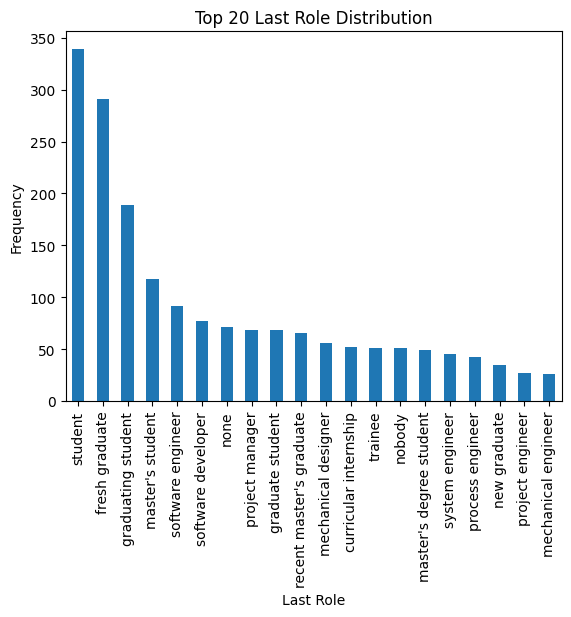

In [67]:
getHist(df[df['Last Role'] != 'not specified'], 'Last Role', None)

In [68]:
df['Last Role'] = df['Last Role'].str.replace('trainee', 'intern')
df['Last Role'] = df['Last Role'].str.replace('backend', 'back-end')
df['Last Role'] = df['Last Role'].str.replace('frontend', 'front-end')
df['Last Role'] = df['Last Role'].str.replace(r'\bpm\b(?![a-zA-Z0-9])', 'project manager')

In [69]:
#neo, engaged, 'Rc20.02904'
last_role_mapping = {
    'Are Managers': 'Area Manager',
    'Civil Cad Engineer': 'Civil Engineer',
    'Civil Engineer Fez': 'Civil Engineer',
    'Consulting': 'Consultant',
    'Cost Control': 'Cost Controller',
    'Data Analysis': 'Data Analyst',
    'Data Scientist': 'Data Scientists',
    'Design': 'Designer',
    'Doctoral Student': 'Doctorate',
    'Post-Doc': 'Doctorate',
    'Freelance': 'Freelancer',
    'Fresh Graduate': 'Graduate',
    'Graduate Student': 'Graduate',
    'Graduated': 'Graduate',
    'Graduated 2023': 'Graduate',
    'Graduated July 2023': 'Graduate',
    'Recent Three-Year Graduate': 'Graduate',
    'New Graduate March 2023': 'Graduate',
    "Master'S Degree Graduate October 2023": 'Graduate',
    'Graduated October 2023': 'Graduate',
    'Graduating 2023': 'Graduating',
    'Graduating Student': 'Graduating',
    'Help Desk': 'Helpdesk Operator',
    'Human Resources Generalist -': 'Human Resources Generalist',
    "I'M Waiting For Cv": 'Not Specified',
    'Internship': 'Intern',
    'Intern/Trainee': 'Intern',
    'Internships': 'Intern',
    'It Consulting': 'It Consultant',
    "Master'S Degree": "Master'S Graduate",
    "Recent Master'S Graduate": "Master'S Graduate",
    "Master'S Student": "Master'S Graduate",
    'New Graduate': 'Graduate',
    'Newly Graduated Student': 'Graduate',
    'Recent Graduate': 'Graduate',
    'Graduate Student - Has Never Worked In The Sector': 'Graduate',
    'Nobody': 'None',
    'Ph.D': 'Phd',
    'Phd Candidates': 'Phd',
    'Ph.D Student': 'Phd Student',
    'Project Design': 'Project Designer',
    'Project Engineer,': 'Project Engineer',
    'Project Engineering': 'Project Engineer',
    'Project Managerr&D': 'Project Manager',
    'Recruiters': 'Recruiter',
    'Researchers': 'Researcher',
    'Salesperson': 'Sales',
    'Software Design': 'Software Designer',
    'Software Engineer |': 'Software Engineer',
    'Student In Physics': 'Student',
    'Students': 'Student',
    'Student Assistant': 'Students Tutor',
    'Supporting Engineer': 'Support Engineer',
    'Systems Engineer': 'Systems Engineer',
    'Substitute Teacher': 'Teacher',
    'Tester Engineer': 'Test Engineer',
    'Testers': 'Tester',
    'Testing': 'Tester',
    'Thesis Internship': 'Thesis Intern',
    'Thesis Student': 'Student',
    'Three-Year Student': 'Student',
    'Web Masters': 'Webmaster',
    'Unemployed': 'None'
}


In [70]:
df['Last Role'] = df['Last Role'].str.title()
df['Last Role'] = df['Last Role'].replace(last_role_mapping)
df['Last Role'] = df['Last Role'].str.lower()

In [71]:
filtered_df = df.copy()
filtered_df = filtered_df[(filtered_df['Last Role'].str.len() < 20) & (filtered_df['Last Role'] != 'not specified')]

In [72]:
print(filtered_df['Last Role'].sort_values().unique())

['.net developer' '.net programmer' 'academic' 'account manager'
 'accountant' 'accounting clerk' 'acting intern' 'adas developer'
 'adas engineer' 'adas passive safety' 'advanced consultant'
 'aerospace engineer' 'ait consultant' 'ait/aiv engineer' 'analyst'
 'analyst consultant' 'analyst programmer' 'android developer'
 'appian consultant' 'apprentice mechanic' 'apprenticeship' 'architect'
 'area manager' 'area sales manager' 'assistant designer'
 'assistant manager' 'automation engineer' 'automotive engineer'
 'automotive intern' 'avl' 'back-end developer' 'back-end engineer'
 'bartender' 'bi consultant' 'bid manager' 'biomedical engineer'
 'brake test engineer' 'business analyst' 'business consultant'
 'business developer' 'business manager' 'business planning' 'buyer'
 'buyer - expediter' 'buyer collaborator' 'c# developer' 'c++ developer'
 'c++ teacher' 'cad designer' 'cad engineer' 'cad point'
 'cad/cae engineer' 'cad/pdm/plm design' 'cae analyst' 'cae consultant'
 'cae engineer

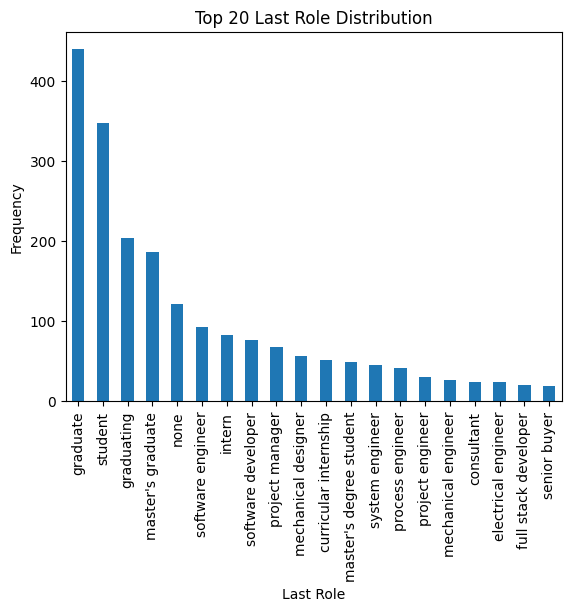

In [73]:
getHist(df[df['Last Role'] != 'not specified'], 'Last Role', None)

## **Duplicated IDs**
In the dataset there are duplicated ids due to it being the result of 2 separated DBs merged together.


In [74]:
def newId(df):
  taken_ids = df['Id'].unique()
  new_id = 1
  while new_id in taken_ids:
    new_id += 1
  return new_id

In [75]:
def specifiedCols(df, id):
  spec_cols = [c for c in df.columns if df.loc[df['Id'] == id, c].astype(str).ne('not specified').all() and df.loc[df['Id'] == id, c].notna().all()]
  return spec_cols

In [76]:
def changingCols(df, id):
  changing_cols = [c for c in df.columns if df.loc[df['Id'] == id, c].nunique() > 1]
  return changing_cols

In [77]:
def mult_values_ids(df, col):
  ids = df[df[col].notna()].groupby('Id').filter(lambda x: x[col].nunique() > 1)['Id'].unique().tolist()
  return ids

###`Year Of Insertion`
Candidates with different year of insertion are clearly the result of different candidates added in different years into different databases.

In [78]:
col = 'Year Of Insertion'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 679 (0.06%) candidates with multiple Year Of Insertion in the DB


As stated by Akkodis there are no Candidates that change Sex in the DB, unless by mistake or update. At default the sex is set to 'male'.

In [79]:
for id in ids:
    id_df = df[df["Id"] == id]
    prev_row = None
    prev_index = None
    current_id = id

    for i in id_df.index:
        curr_row = id_df.loc[i]

        if prev_row is None:
            prev_row = curr_row
            prev_index = i
            continue

        consecutive = i == prev_index + 1
        same_sex = curr_row["Sex"] == prev_row["Sex"]

        if not (consecutive and same_sex):
            current_id = newId(df)

        df.at[i, "Id"] = current_id

        prev_row = curr_row
        prev_index = i

###`Candidate State`

In [80]:
col = 'Candidate State'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 192 (0.02%) candidates with multiple Candidate State in the DB


In [81]:
for id in ids:
    id_df = df[df["Id"] == id]
    prev_row = None
    prev_index = None
    current_id = id

    for i in id_df.index:
        curr_row = id_df.loc[i]

        if prev_row is None:
            prev_row = curr_row
            prev_index = i
            continue

        consecutive = i == prev_index + 1
        same_sex = curr_row["Sex"] == prev_row["Sex"]

        if not (consecutive and same_sex):
            current_id = newId(df)

        df.at[i, "Id"] = current_id

        prev_row = curr_row
        prev_index = i

In [82]:
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 4 (0.00%) candidates with multiple Candidate State in the DB


In [83]:
cols = []
for id in ids:
   cols.extend(changingCols(df, id))

cols = list(set(cols))
cols.insert(0, 'Id')
df[df['Id'].isin(ids)][cols].sort_values(by='Id')

Id Candidate State      Age Range Linked_Search__Key       Mobility  \
6307     61   first contact  26 - 30 years      not specified  not specified   
6305     61        imported  20 - 25 years      not specified  not specified   
6306     61   first contact  26 - 30 years      not specified  not specified   
6007   3713   first contact  26 - 30 years      not specified  not specified   
6008   3713        imported  20 - 25 years      not specified  not specified   
6015  31367    in selection     < 20 years      not specified  not specified   
6014  31367    in selection     < 20 years      not specified  not specified   
6013  31367    in selection     < 20 years      not specified  not specified   
6012  31367    in selection     < 20 years          RS20.0644            2.0   
6011  31367    in selection     < 20 years          RS21.0877            2.0   
6009  31367        imported  26 - 30 years      not specified  not specified   
6010  31367    in selection     < 20 years      not specified  not specified   
5801  68643              qm  20 - 25 years          RS22.1319            3.0   
5800  68643              qm  20 - 25 years      not specified  not specified   
5799  68643              qm  20 - 25 years      not specified  not specified   
5798  68643              qm  20 - 25 years          RS23.0739  not specified   
5797  68643              qm  20 - 25 years      not specified  not specified   
5796  68643        imported  26 - 30 years      not specified  not specified   

     Residence Italian Province  \
6307                      lecce   
6305                   brindisi   
6306                      lecce   
6007                   syracuse   
6008                     ragusa   
6015                      turin   
6014                      turin   
6013                      turin   
6012                      turin   
6011                      turin   
6009                    caserta   
6010                      turin   
5801                       bari   
5800                       bari   
5799                       bari   
5798                       bari   
5797                       bari   
5796                       bari   

                                                    Tag  Communication  \
6307                                         automotive  not specified   
6305                                      not specified  not specified   
6306                                         automotive  not specified   
6007                                      not specified  not specified   
6008                                      not specified  not specified   
6015  abaqus, fem, nastra, patran, nastran patran , ...  not specified   
6014  abaqus, fem, nastra, patran, nastran patran , ...  not specified   
6013  abaqus, fem, nastra, patran, nastran patran , ...  not specified   
6012  abaqus, fem, nastra, patran, nastran patran , ...            3.0   
6011  abaqus, fem, nastra, patran, nastran patran , ...            3.0   
6009                                      not specified  not specified   
6010  abaqus, fem, nastra, patran, nastran patran , ...  not specified   
5801  hardware, biomedical engineering, mathlab, med...            2.0   
5800  hardware, biomedical engineering, mathlab, med...  not specified   
5799  hardware, biomedical engineering, mathlab, med...  not specified   
5798  hardware, biomedical engineering, mathlab, med...  not specified   
5797  hardware, biomedical engineering, mathlab, med...  not specified   
5796                                      not specified  not specified   

             Sector        Overall  ... Residence Italian Region  \
6307         others  not specified  ...                   puglia   
6305  not specified  not specified  ...                   puglia   
6306         others  not specified  ...                   puglia   
6007  not specified  not specified  ...                   sicily   
6008  not specified  not specified  ...                   sicily   
6015   

Candidates with 'imported' as candidate state are more likely to have duplicated ids.

In [84]:
filtered_df = df[df['Id'].isin(ids)]

for id in ids:
  id_df = filtered_df[filtered_df["Id"] == id]
  if id_df['Candidate State'].nunique() > 1 and 'imported' in id_df['Candidate State'].unique():
    new_id = newId(df)
    indexes = id_df[id_df['Candidate State'] == 'imported'].index
    for index in indexes:
      df.at[index, 'Id'] = new_id

###`Year Of Recruitment`


In [85]:
col = 'Year Of Recruitment'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 16 (0.00%) candidates with multiple Year Of Recruitment in the DB


In [86]:
const_cols = ['Id', 'Sex', 'Age Range', 'Protected Category', 'Residence Italian Province', 'Recruitment Request']

filtered_df = df[df['Id'].isin(ids)]
for id in ids:
  id_df = filtered_df[filtered_df["Id"] == id]
  changing_cols = changingCols(id_df[const_cols], id)
  if len(changing_cols) == 0:
    yor = id_df['Year Of Recruitment'].unique()[-1]
    indexes = id_df.index
    for index in indexes:
      df.at[index, 'Year Of Recruitment'] = yor

In [87]:
ids = df[df['Year Of Recruitment'].notna()].groupby('Id').filter(lambda x: x['Year Of Recruitment'].nunique() > 1)['Id'].unique().tolist()
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple Year Of Recruitment in the DB")

There are 6 (0.00%) candidates with multiple Year Of Recruitment in the DB


In [88]:
df = df[~((df['Id'] == 22025) & (df['Year Of Recruitment'] == 2019))]
df = df[~((df['Id'] == 38616) & (df['Year Of Recruitment'] == 2019))]
df = df[~((df['Id'] == 60990) & (df['Year Of Recruitment'] == 2019))]
df = df[~((df['Id'] == 28734) & (df['Year Of Recruitment'] == 2019))]
df = df[~((df['Id'] == 73997) & (df['Year Of Recruitment'] == 2021))]
df = df[~((df['Id'] == 20951) & (df['Year Of Recruitment'] == 2020))]

###`Sex`
As stated by Akkodis there are no candidates that have changed sex in their DB. The only reason an Id changes sex while still being the same candidate is that the default sex is 'male'.

In [89]:
col = 'Sex'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 46 (0.00%) candidates with multiple Sex in the DB


In [90]:
cols = []
for id in ids:
   cols.extend(changingCols(df, id))

cols = list(set(cols))
cols.insert(0, 'Id')
df[df['Id'].isin(ids)][cols].sort_values(by='Id')

Id      Age Range     Sex Linked_Search__Key       Mobility  \
16719    361  31 - 35 years    male          RS22.1067            2.0   
16720    361  31 - 35 years    male          RS22.1067            2.0   
17063    361  26 - 30 years  female          RS22.1156            1.0   
13635   2863  26 - 30 years    male      not specified  not specified   
15403   2863  20 - 25 years  female      not specified  not specified   
...      ...            ...     ...                ...            ...   
7325   72185  26 - 30 years    male      not specified  not specified   
5065   75462  26 - 30 years  female      not specified  not specified   
8224   75462  26 - 30 years    male      not specified  not specified   
14289  76132  20 - 25 years    male      not specified  not specified   
14231  76132  26 - 30 years  female      not specified  not specified   

      Residence Italian Province                                       Tag  \
16719                      milan  analysis and development in cobol, cobol   
16720                      milan  analysis and development in cobol, cobol   
17063                       rome                   ict, talent acquisition   
13635                      cuneo                             not specified   
15403                      turin                             not specified   
...                          ...                                       ...   
7325                       turin                             not specified   
5065               ascoli-piceno                             not specified   
8224                        bari                             not specified   
14289                       bari                             not specified   
14231                   brindisi                             not specified   

       Communication         Sector        Overall  ...    Current Ral  \
16719            3.0         others            3.0  ...         32-34k   
16720            3.0         others            3.0  ...         32-34k   
17063            3.0     consulting            2.0  ...  not specified   
13635  not specified  not specified  not specified  ...  not specified   
15403  not specified  not specified  not specified  ...  not specified   
...              ...            ...            ...  ...            ...   
7325   not specified  not specified  not specified  ...  not specified   
5065   not specified  not specified  not specified  ...  not specified   
8224   not specified  not specified  not specified  ...  not specified   
14289  not specified  not specified  not specified  ...  not specified   
14231  not specified  not specified  not specified  ...  not specified   

                                            Study Area       Maturity  \
16719                                      informatics            3.0   
16720                                      informatics            3.0   
17063                                       psychology            2.0   
13635                             computer engineering  not specified   
15403                           industrial engineering  not specified   
...                                                ...            ...   
7325                            mechanical engineering  not specified   
5065                            industrial engineering  not specified   
8224   aeronautical/aerospace/astronautics engineering  not specified   
14289                           mechanical engineering  not specified   
14231                           mechanical engineering  not specified   

      Italian Residence Residence Italian City             Study Title  \
16719               yes                 assago  high school graduation   
16720               yes                 assago  high school graduation   
17063               yes                   rome        five-year degree   
13635               yes                    bra        five-year degree   
15403               yes                  turin       three-y

In [91]:
for id in ids:
    id_df = df[df["Id"] == id]
    prev_row = None
    prev_index = None
    current_id = id

    for i in id_df.index:
        curr_row = id_df.loc[i]

        if prev_row is None:
            prev_row = curr_row
            prev_index = i
            continue

        consecutive = i == prev_index + 1
        same_age = curr_row["Age Range"] == prev_row["Age Range"]

        if not (consecutive and same_age):
            current_id = newId(df)

        df.at[i, "Id"] = current_id

        prev_row = curr_row
        prev_index = i

###`Age Range`

In [92]:
col = 'Age Range'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 57 (0.00%) candidates with multiple Age Range in the DB


In [93]:
df[df['Id'].isin(ids)][['Id', 'Candidate State', 'Sex', 'Age Range', 'Residence Italian City', 'Sector', 'Last Role']].sort_values(by='Id')

Id Candidate State     Sex      Age Range Residence Italian City  \
12400   1265        imported    male  20 - 25 years                 statte   
10296   1265        imported    male  26 - 30 years                 nemoli   
10398   1989        imported  female  20 - 25 years                 ceraso   
15430   1989        imported  female  31 - 35 years                  turin   
11217   3622        imported    male  20 - 25 years      monte sant'angelo   
...      ...             ...     ...            ...                    ...   
14397  79145        imported    male  26 - 30 years               pozzallo   
5458   81040        imported    male  20 - 25 years      albanese spezzano   
3325   81040        imported    male  26 - 30 years                 avella   
14321  81459        imported  female  20 - 25 years               bitritto   
16056  81459        imported  female  26 - 30 years          villalfonsina   

              Sector      Last Role  
12400  not specified  not specified  
10296  not specified  not specified  
10398  not specified  not specified  
15430  not specified  not specified  
11217  not specified  not specified  
...              ...            ...  
14397  not specified  not specified  
5458   not specified  not specified  
3325   not specified  not specified  
14321  not specified  not specified  
16056  not specified  not specified  

[137 rows x 7 columns]

In [94]:
filtered_df = df[(df['Id'].isin(ids)) & (df['Candidate State'] == 'imported')]

for id in ids:
    id_df = filtered_df[filtered_df["Id"] == id]
    prev_row = None
    prev_index = None
    current_id = id

    for i in id_df.index:
        curr_row = id_df.loc[i]

        if prev_row is None:
            prev_row = curr_row
            prev_index = i
            continue

        consecutive = i == prev_index + 1
        same_city = curr_row["Residence Italian City"] == prev_row["Residence Italian City"]

        if not (consecutive and same_city):
            current_id = newId(df)

        df.at[i, "Id"] = current_id

        prev_row = curr_row
        prev_index = i

In [95]:
ids = df[df['Age Range'].notna()].groupby('Id').filter(lambda x: x['Age Range'].nunique() > 1)['Id'].unique().tolist()
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple Age Range in the DB")

There are 18 (0.00%) candidates with multiple Age Range in the DB


In [96]:
df[df['Id'].isin(ids)][['Id', 'Candidate State', 'Sex', 'Age Range', 'Residence Italian City', 'Sector', 'Last Role']].sort_values(by='Id')

Id Candidate State     Sex      Age Range Residence Italian City  \
17637   3921   first contact    male     > 45 years    castel san giovanni   
14092   3921   first contact    male     < 20 years                   rome   
21106  10783    in selection    male  20 - 25 years             rutigliano   
19430  10783    in selection    male  36 - 40 years                  turin   
19429  10783    in selection    male  36 - 40 years                  turin   
19428  10783    in selection    male  36 - 40 years                  turin   
21105  10783    in selection    male  20 - 25 years             rutigliano   
12106  15443   first contact    male     < 20 years     corigliano calabro   
15790  15443   first contact    male     > 45 years                  milan   
13104  16639    in selection  female  31 - 35 years                   pisa   
13103  16639    in selection  female  31 - 35 years                   pisa   
12332  16639    in selection  female  26 - 30 years                walnuts   
12333  16639    in selection  female  26 - 30 years                walnuts   
12334  16639    in selection  female  26 - 30 years                walnuts   
13102  16639    in selection  female  31 - 35 years                   pisa   
17191  19670   first contact    male     < 20 years                  genoa   
16577  19670   first contact    male  31 - 35 years                bologna   
12678  31584   first contact    male     > 45 years                  turin   
12078  31584   first contact    male  26 - 30 years                cassino   
13399  32471   first contact    male  26 - 30 years                catania   
11394  32471   first contact    male  20 - 25 years                   bari   
18211  34522   first contact    male  36 - 40 years              cinisello   
18462  34522   first contact    male  31 - 35 years                  pavia   
18505  38500   first contact    male  31 - 35 years                 naples   
18544  38500   first contact    male  26 - 30 years                 modena   
17853  41429   first contact    male  26 - 30 years               florence   
11708  41429   first contact    male  31 - 35 years                  pink'   
16554  51436   first contact    male     < 20 years                  milan   
16971  51436   first contact    male  31 - 35 years                  milan   
12110  53587   first contact    male  20 - 25 years                 naples   
12111  53587   first contact    male  20 - 25 years                 naples   
13338  53587   first contact    male  26 - 30 years         frattamaggiore   
13339  53587   first contact    male  26 - 30 years         frattamaggiore   
17170  54255   first contact    male     > 45 years                   rome   
13957  54255   first contact    male  26 - 30 years       fara gera d'adda   
18015  54586   first contact  female  36 - 40 years             caravaggio   
14111  54586   first contact  female  20 - 25 years                  turin   
17190  56346   first contact    male  26 - 30 years           not in italy   
16556  56346   first contact    male     < 20 years                   rome   
20369  58405   first contact    male     < 20 years    tagliolo monferrato   
20368  58405   first contact    male     < 20 years    tagliolo monferrato   
20367  58405   first contact    male     < 20 years    tagliolo monferrato   
19097  58405   first contact    male  26 - 30 years                  turin   
18261  69473    in selection    male  20 - 25 years                   rome   
19568  69473    in selection    male     < 20 years                  turin   
19567  69473    in selection    male     < 20 years                  turin   
19566  69473    in selection    male     < 20 years                  turin   
19565  69473    in selection    male     < 20 years                  turin   
7455   69497    in selection    male  26 - 30 years                  yield   
7457   69497    in selection    male  26 - 30 years                  yield   
7456   69497    in selection    

In [97]:
filtered_df = df[df['Id'].isin(ids)]

for id in ids:
    id_df = filtered_df[filtered_df["Id"] == id]
    prev_row = None
    prev_index = None
    current_id = id

    for i in id_df.index:
        curr_row = id_df.loc[i]

        if prev_row is None:
            prev_row = curr_row
            prev_index = i
            continue

        consecutive = i == prev_index + 1
        same_province = curr_row["Residence Italian Province"] == prev_row["Residence Italian Province"]
        same_last_role = curr_row["Last Role"] == prev_row["Last Role"]

        if not (consecutive and same_province and same_last_role):
            current_id = newId(df)

        df.at[i, "Id"] = current_id

        prev_row = curr_row
        prev_index = i

### `Study Area`

In [98]:
col = 'Study Area'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 43 (0.00%) candidates with multiple Study Area in the DB


In [99]:
df[df['Id'].isin(ids)][['Id', 'Candidate State', 'Study Area', 'Residence Italian Province', 'Sector', 'Last Role']].sort_values(by='Id')

Id Candidate State                                       Study Area  \
9486    2212        imported                           mechanical engineering   
3235    2212        imported                           biomedical engineering   
13194   2658        imported                             computer engineering   
10243   2658        imported                           management engineering   
15150   5061        imported                          information engineering   
...      ...             ...                                              ...   
14520  79054        imported                           industrial engineering   
5948   80587        imported                           industrial engineering   
3785   80587        imported                           mechanical engineering   
3012   81110        imported  aeronautical/aerospace/astronautics engineering   
3769   81110        imported                           mechanical engineering   

      Residence Italian Province         Sector      Last Role  
9486                not in italy  not specified  not specified  
3235                    oristano  not specified  not specified  
13194                      lecce  not specified  not specified  
10243                      turin  not specified  not specified  
15150                    trapani  not specified  not specified  
...                          ...            ...            ...  
14520                    messina  not specified  not specified  
5948                       cuneo  not specified  not specified  
3785                     bergamo  not specified  not specified  
3012                       turin  not specified  not specified  
3769                       turin  not specified  not specified  

[98 rows x 6 columns]

In [100]:
filtered_df = df[(df['Id'].isin(ids)) & (df['Candidate State'] == 'imported')]

for id in ids:
    id_df = filtered_df[filtered_df["Id"] == id]
    prev_row = None
    prev_index = None
    current_id = id

    for i in id_df.index:
        curr_row = id_df.loc[i]

        if prev_row is None:
            prev_row = curr_row
            prev_index = i
            continue

        consecutive = i == prev_index + 1
        same_province = curr_row["Residence Italian Province"] == prev_row["Residence Italian Province"]

        if not (consecutive and same_province):
            current_id = newId(df)

        df.at[i, "Id"] = current_id

        prev_row = curr_row
        prev_index = i

In [101]:
col = 'Study Area'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 5 (0.00%) candidates with multiple Study Area in the DB


In [102]:
df[df['Id'].isin(ids)][['Id', 'Candidate State', 'Study Area', 'Residence Italian Province', 'Sector', 'Last Role']].sort_values(by='Id')

Id Candidate State                                       Study Area  \
20731  25959    in selection                             computer engineering   
20730  25959    in selection                             computer engineering   
20729  25959    in selection                             computer engineering   
19717  25959    in selection                           mechanical engineering   
19716  25959    in selection                           mechanical engineering   
5055   33790   first contact                             computer engineering   
5056   33790   first contact                             computer engineering   
6411   33790   first contact                           biomedical engineering   
6412   33790   first contact                           biomedical engineering   
2995   37030   first contact  aeronautical/aerospace/astronautics engineering   
2996   37030   first contact  aeronautical/aerospace/astronautics engineering   
2997   37030   first contact  aeronautical/aerospace/astronautics engineering   
6491   37030   first contact                             computer engineering   
6492   37030   first contact                             computer engineering   
17881  61260   first contact                           mechanical engineering   
11767  61260   first contact              automation/mechatronics engineering   
19673  77070    in selection                                      informatics   
19672  77070    in selection                                      informatics   
20953  77070    in selection                        other scientific subjects   
19674  77070    in selection                                      informatics   
20954  77070    in selection                        other scientific subjects   

      Residence Italian Province                            Sector  \
20731                      turin  services and information systems   
20730                      turin  services and information systems   
20729                      turin  services and information systems   
19717                    bergamo                            others   
19716                    bergamo                            others   
5055                       turin                     not specified   
5056                       turin                     not specified   
6411                       turin                     not specified   
6412                       turin                     not specified   
2995                     palermo                     not specified   
2996                     palermo                     not specified   
2997                     palermo                     not specified   
6491               caltanissetta                     not specified   
6492               caltanissetta                     not specified   
17881               not in italy                            others   
11767                      milan                            others   
19673                      turin                            others   
19672                      turin                            others   
20953                      milan                            others   
19674                      turin                            others   
20954                      milan                            others   

               Last Role  
20731           graduate  
20730           graduate  
20729           graduate  
19717            student  
19716            student  
5055       not specified  
5056       not specified  
6411            graduate  
6412            graduate  
2995       not specified  
2996       not specified  
2997       not specified  
6491       not specified  
6492       not specified  
17881  master's graduate  
11767  robotics engineer  
19673  android developer  
19672  android developer  
20953         graduating  
19674  android developer  
20954         graduating

In [103]:
filtered_df = df[(df['Id'].isin(ids))]

for id in ids:
    id_df = filtered_df[filtered_df["Id"] == id]
    prev_row = None
    prev_index = None
    current_id = id

    for i in id_df.index:
        curr_row = id_df.loc[i]

        if prev_row is None:
            prev_row = curr_row
            prev_index = i
            continue

        consecutive = i == prev_index + 1
        same_province = curr_row["Residence Italian Province"] == prev_row["Residence Italian Province"]

        if not (consecutive and same_province):
            current_id = newId(df)

        df.at[i, "Id"] = current_id

        prev_row = curr_row
        prev_index = i

###`Residence Province`

In [104]:
col = 'Residence Italian Province'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 1 (0.00%) candidates with multiple Residence Italian Province in the DB


In [105]:
cols = changingCols(df, ids[0])
df[df['Id']==ids[0]][cols]

Residence Italian Region Residence Italian Province  \
3551                  tuscany                   grosseto   
5860                   sicily                    trapani   

       Residence Italian City  
3551              countryside  
5860  castellammare del golfo

In [106]:
df.drop(3551, inplace=True)

###`Residence Italian City`

In [107]:
col = 'Residence Italian City'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 1 (0.00%) candidates with multiple Residence Italian City in the DB


In [108]:
cols = changingCols(df, ids[0])
df[df['Id']==ids[0]][cols]

Residence Italian City
3008               cherasco
5096                  cuneo

In [109]:
df.drop(3008, inplace=True)

###`Last Role`

In [110]:
col='Last Role'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 2 (0.00%) candidates with multiple Last Role in the DB


In [111]:
cols = changingCols(df, ids[0])

In [112]:
df[df['Id'] == ids[0]][cols]

Last Role      Event_Type__Val  \
6818               procurement specialist buyer         bm interview   
6819               procurement specialist buyer         contact note   
6820               procurement specialist buyer        inadequate cv   
6821  training member – system analyst engineer         bm interview   
6822  training member – system analyst engineer        inadequate cv   
6823  training member – system analyst engineer         bm interview   
6824  training member – system analyst engineer  technical interview   
6825  training member – system analyst engineer         contact note   

     Event_Feedback Linked_Search__Key        Overall Technical Skills  \
6818      ok (live)          RS21.1148            2.0              1.0   
6819  not specified      not specified  not specified    not specified   
6820  not specified          RS22.0905  not specified    not specified   
6821             ok          RS22.0905            2.0              2.0   
6822  not specified          RS22.0887  not specified    not specified   
6823             ok          RS22.0887            2.0              2.0   
6824             ok          RS22.0887            2.0              2.0   
6825  not specified      not specified  not specified    not specified   

     Standing/Position  Communication       Maturity       Dynamism  \
6818               2.0            2.0            2.0            3.0   
6819     not specified  not specified  not specified  not specified   
6820     not specified  not specified  not specified  not specified   
6821               2.0            2.0            2.0            2.0   
6822     not specified  not specified  not specified  not specified   
6823               2.0            2.0            3.0            3.0   
6824               2.0            2.0            3.0            3.0   
6825     not specified  not specified  not specified  not specified   

           Mobility        English  
6818            3.0            4.0  
6819  not specified  not specified  
6820  not specified  not specified  
6821            2.0            3.0  
6822  not specified  not specified  
6823            3.0            3.0  
6824            3.0            3.0  
6825  not specified  not specified

In [113]:
indexes = df[(df['Id'] == ids[0]) & (df['Linked_Search__Key'] != 'RS22.0887')].index
df = df.drop(indexes)
df = df.drop(18160)

###`Tag`

In [114]:
col= 'Tag'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 3 (0.00%) candidates with multiple Tag in the DB


In [115]:
df.loc[df['Id'] == ids[0], 'Tag'] = 'language, c++ , qt, engineer, python, c'
df.loc[df['Id'] == ids[1], 'Tag'] = 'c , c++, matlab, labview, hardware, microwave, electric motors, pcb, process, circuit design, testing'
df.loc[df['Id'] == ids[2], 'Tag'] = 'create'

###`Recruitment Request`

In [116]:
col = 'Recruitment Request'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 4 (0.00%) candidates with multiple Recruitment Request in the DB


In [117]:
df = df[~((df['Id']==ids[0]) & (df['Recruitment Request'] == 'not specified'))]
df = df[~((df['Id']==ids[0]) & (df['Recruitment Request'] == 'not specified'))]
df = df[~((df['Id']==ids[1]) & (df['Recruitment Request'] == 'not specified'))]
df = df[~((df['Id']==ids[2]) & (df['Recruitment Request'] != 'software quality assurance'))]
df = df.drop(index = 21376)

###`Job Title Hiring`

In [118]:
col = 'Job Title Hiring'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 6 (0.00%) candidates with multiple Job Title Hiring in the DB


In [119]:
cols = changingCols(df, ids[4])
df[df['Id'] == ids[4]][cols]

Job Family Hiring   Job Title Hiring Event_Type__Val  \
14127                  engineering  junior consultant    contact note   
14128  tech consulting & solutions         consultant    contact note   
14129                  engineering  junior consultant    bm interview   
14130  tech consulting & solutions         consultant    bm interview   
14131                  engineering  junior consultant    hr interview   
14132  tech consulting & solutions         consultant    hr interview   

      Event_Feedback Linked_Search__Key        Overall Technical Skills  \
14127  not specified      not specified  not specified    not specified   
14128  not specified      not specified  not specified    not specified   
14129             ok          RS22.0544            3.0              2.0   
14130             ok          RS22.0544            3.0              2.0   
14131             ok          RS22.0544            3.0              2.0   
14132             ok          RS22.0544            3.0              2.0   

      Standing/Position  Communication       Maturity       Dynamism  \
14127     not specified  not specified  not specified  not specified   
14128     not specified  not specified  not specified  not specified   
14129               3.0            3.0            3.0            3.0   
14130               3.0            3.0            3.0            3.0   
14131               3.0            3.0            2.0            3.0   
14132               3.0            3.0            2.0            3.0   

            Mobility        English  
14127  not specified  not specified  
14128  not specified  not specified  
14129            2.0            3.0  
14130            2.0            3.0  
14131            2.0            3.0  
14132            2.0            3.0

In [120]:
df.loc[df['Id'] == ids[0], col] = 'support advanced'
df.loc[df['Id'] == ids[1], col] = 'technician	/ junior consultant'
df.loc[df['Id'] == ids[2], col] = 'tech consulting & solutions / engineering'
df.loc[df['Id'] == ids[3], col] = 'support / talent acquisition'
df.loc[df['Id'] == ids[4], col] = 'tech consulting & solutions / engineering'
df.loc[df['Id'] == ids[5], col] = 'advanced consultant'

###`Linked_Search__Key`

In [121]:
col = 'Linked_Search__Key'
ids = mult_values_ids(df[df[col]!= 'not specified'], col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 719 (0.06%) candidates with multiple Linked_Search__Key in the DB


In [122]:
filtered_df = df.copy()
filtered_df = filtered_df[filtered_df['Id'].isin(ids)]
col = 'Linked_Search__Key'
job_cols = job_offer_columns.copy()
job_cols.append('Id')

for id in ids:
    id_df = filtered_df[filtered_df["Id"] == id]
    cols = changingCols(id_df[job_cols], id)
    if len(cols) == 1: #only linked search key changes
      new_lsk = id_df[id_df[col]!='not specified'][col].unique().tolist()
      new_lsk = list(set(new_lsk))
      df.loc[df['Id'] == id, col] = ', '.join(map(str, new_lsk))

In [123]:
col = 'Linked_Search__Key'
ids = mult_values_ids(df[df[col]!= 'not specified'], col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 8 (0.00%) candidates with multiple Linked_Search__Key in the DB


In [124]:
new_lsk = df[df['Id'] == ids[5]][df[col]!='not specified'][col].unique().tolist()
new_lsk = ', '.join(map(str, new_lsk))
df.loc[df['Id'] == ids[5], col] = new_lsk
df.loc[df['Id'] == ids[5], 'Job Family Hiring'] = 'tech consulting & solutions / engineering'

<ipython-input-124-5ce9f6b04c3b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_lsk = df[df['Id'] == ids[5]][df[col]!='not specified'][col].unique().tolist()


In [125]:
cols = changingCols(df[job_cols], ids[7])
cols.append('Residence Italian Region')
cols.append('Residence Italian Province')
df[df['Id'] == ids[7]][cols]
new_lsk = df[df['Id'] == ids[7]][df[col]!='not specified'][col].unique().tolist()
new_lsk = list(set(new_lsk))
new_lsk = ', '.join(map(str, new_lsk))
df.loc[df['Id'] == ids[7], col] = new_lsk
df.loc[df['Id'] == ids[7], 'Assumption Headquarters'] = 'milan'


<ipython-input-125-94f8768571bb>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_lsk = df[df['Id'] == ids[7]][df[col]!='not specified'][col].unique().tolist()


In [126]:
filtered_df = df[df['Id'].isin(ids)]
col = 'Linked_Search__Key'

for id in ids:
    id_df = filtered_df[filtered_df["Id"] == id]
    cols = changingCols(id_df[job_cols], id)
    if 'Candidate Profile' in cols and len(cols) == 2:
      cp = id_df[id_df['Candidate Profile']!='not specified']['Candidate Profile'].unique()[-1]
      new_lsk = id_df[id_df[col]!='not specified'][col].unique().tolist()
      new_lsk = list(set(new_lsk))
      new_lsk = ', '.join(map(str, new_lsk))
      indexes = id_df.index
      for index in indexes:
        df.at[index, 'Candidate Profile'] = cp
        df.at[index, col] = new_lsk

In [127]:
col = 'Linked_Search__Key'
ids = mult_values_ids(df[df[col]!= 'not specified'], col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 1 (0.00%) candidates with multiple Linked_Search__Key in the DB


In [128]:
cols = changingCols(df, ids[0])
jd = df[df['Id'] == ids[0]]['Job Description'].unique().tolist()
new_lsk = df[df['Id'] == ids[0]][df[col]!='not specified'][col].unique().tolist()
new_lsk = list(set(new_lsk))
new_lsk = ', '.join(map(str, new_lsk))
df.loc[df['Id'] == ids[0], col] = new_lsk
df.loc[df['Id'] == ids[0], 'Job Description'] = jd[-1]

<ipython-input-128-2de81e4d5dd9>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_lsk = df[df['Id'] == ids[0]][df[col]!='not specified'][col].unique().tolist()


In [129]:
col = 'Linked_Search__Key'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 1280 (0.10%) candidates with multiple Linked_Search__Key in the DB


In [130]:
#filling 'not specified'
filtered_df = df.copy()
filtered_df = filtered_df[filtered_df['Id'].isin(ids)]

for id in ids:
    id_df = filtered_df[filtered_df["Id"] == id]
    new_lsk = id_df[id_df[col]!='not specified'][col].unique().tolist()
    new_lsk = list(set(new_lsk))
    if len(new_lsk) > 1:
      new_lsk = ', '.join(map(str, new_lsk))
    else:
      new_lsk = new_lsk[0]

    df.loc[df['Id'] == id, col] = new_lsk

In [131]:
col = 'Recruitment Request'
pattern = r'rs\d{2}\.\d{4}'
filtered_df = df[df[col].apply(lambda x: bool(re.search(pattern, str(x))))]

for index, row in filtered_df.iterrows():
    lsks = re.search(pattern, str(row[col]))
    if lsks:
        key = lsks.group(0)
        if key not in str(row['Linked_Search__Key']):
            df.at[index, 'Linked_Search__Key'] = str(row['Linked_Search__Key']) + ', ' + key

df['Recruitment Request'] = df['Recruitment Request'].apply(lambda x: re.sub(pattern, '', str(x)))

###`Job family hiring`

In [132]:
col = 'Job Family Hiring'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 4 (0.00%) candidates with multiple Job Family Hiring in the DB


In [133]:
cols = []
for id in ids:
   cols.extend(changingCols(df, id))

cols = list(set(cols))
cols.insert(0, 'Id')
df[df['Id'].isin(ids)][cols].sort_values(by='Id')

Id       Mobility        Event_Type__Val Standing/Position  \
15874  17678            2.0           hr interview               2.0   
15872  17678            2.0           hr interview               2.0   
15871  17678            2.0           bm interview               2.0   
15870  17678            2.0           bm interview               2.0   
15869  17678            2.0           bm interview               2.0   
15868  17678            2.0           contact note               2.0   
15867  17678            2.0           contact note               2.0   
15866  17678            2.0           contact note               2.0   
15873  17678            2.0           hr interview               2.0   
14132  47016            2.0           hr interview               3.0   
14131  47016            2.0           hr interview               3.0   
14130  47016            2.0           bm interview               3.0   
14129  47016            2.0           bm interview               3.0   
14128  47016  not specified           contact note     not specified   
14127  47016  not specified           contact note     not specified   
14053  57640            2.0           bm interview               3.0   
14051  57640            2.0           bm interview               3.0   
14050  57640            2.0           hr interview               3.0   
14049  57640            2.0           hr interview               3.0   
14048  57640            2.0           hr interview               3.0   
14052  57640            2.0           bm interview               3.0   
6923   67831            2.0           bm interview               2.0   
6922   67831            2.0           bm interview               2.0   
6921   67831            2.0           bm interview               2.0   
6920   67831  not specified  qualification meeting     not specified   
6919   67831  not specified  qualification meeting     not specified   
6918   67831  not specified  qualification meeting     not specified   
6917   67831            2.0           bm interview               2.0   
6916   67831            2.0           bm interview               2.0   
6915   67831            2.0           bm interview               2.0   

                   Event_Feedback Technical Skills       Maturity  \
15874                          ok              1.0            3.0   
15872                          ok              1.0            3.0   
15871                          ok              1.0            3.0   
15870                          ok              1.0            3.0   
15869                          ok              1.0            3.0   
15868               not specified              1.0            3.0   
15867               not specified              1.0            3.0   
15866               not specified              1.0            3.0   
15873                          ok              1.0            3.0   
14132                          ok              2.0            2.0   
14131                          ok              2.0            2.0   
14130                          ok              2.0            3.0   
14129                          ok              2.0            3.0   
14128               not specified    not specified  not specified   
14127               not specified    not specified  not specified   
14053  ok (waiting for departure)              2.0            3.0   
14051  ok (waiting for departure)              2.0            3.0   
14050                          ok              2.0            3.0   
14049                          ok              2.0            3.0   
14048                          ok              2.0            3.0   
14052  ok (waiting for departure)              2.0            3.0   
6923                           ok              2.0            2.0   
6922                           ok              2.0            2.0   
6921                           ok              2.0            2.0   
6920                           ok    not specified  

In [134]:
filtered_df = df.copy()
filtered_df = filtered_df[filtered_df['Id'].isin(ids)]

for id in ids:
    id_df = filtered_df[filtered_df["Id"] == id]
    new_jf = id_df[id_df[col]!='not specified'][col].unique().tolist()
    new_jf = ' / '.join(map(str, new_jf))
    df.loc[df['Id'] == id, col] = new_jf

###`Job Description`

In [135]:
col = 'Job Description'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 4 (0.00%) candidates with multiple Job Description in the DB


In [136]:
cols = []
for id in ids:
   cols.extend(changingCols(df, id))

cols = list(set(cols))
cols.insert(0, 'Id')
df[df['Id'].isin(ids)][cols].sort_values(by='Id')

Id       Mobility         Event_Type__Val  \
18315   6936            2.0            bm interview   
18314   6936            3.0            bm interview   
6664   32176            1.0            bm interview   
6663   32176            1.0            bm interview   
16681  37451            3.0            bm interview   
16680  37451            3.0            hr interview   
16679  37451  not specified    research association   
16678  37451  not specified  sending sc to customer   
16677  37451            3.0            bm interview   
3205   59906            3.0            hr interview   
3204   59906            3.0            hr interview   
3192   59906  not specified              cv request   
3201   59906            4.0            bm interview   
3200   59906            4.0            bm interview   
3199   59906  not specified            contact note   
3198   59906  not specified            contact note   
3197   59906  not specified  candidate notification   
3196   59906  not specified  candidate notification   
3195   59906  not specified            contact note   
3194   59906  not specified            contact note   
3193   59906  not specified              cv request   
3202   59906            4.0     technical interview   
3203   59906            4.0     technical interview   

                                         Job Description Standing/Position  \
18315  interface management of internal and external ...               3.0   
18314  - interface management of internal and externa...               3.0   
6664   for procurement activities withclients, it is ...               2.0   
6663   for procurement activities with clients, it is...               2.0   
16681        5th and 2nd level support activities onsite               3.0   
16680        4th and 2nd level support activities onsite               3.0   
16679        3rd and 2nd level support activities onsite     not specified   
16678        2nd and 2nd level support activities onsite     not specified   
16677        1st and 2nd level support activities onsite               3.0   
3205   support and administration of it and automatio...               3.0   
3204   support and administration of it and automatio...               3.0   
3192   support and administration of it and automatio...     not specified   
3201   support and administration of it and automatio...               3.0   
3200   support and administration of it and automatio...               3.0   
3199   support and administration of it and automatio...     not specified   
3198   support and administration of it and automatio...     not specified   
3197   support and administration of it and automatio...     not specified   
3196   support and administration of it and automatio...     not specified   
3195   support and administration of it and automatio...     not specified   
3194   support and administration of it and automatio...     not specified   
3193   support and administration of it and automatio...     not specified   
3202   support and administration of it and automatio...               3.0   
3203   support and administration of it and automatio...               3.0   

             Event_Feedback Technical Skills       Maturity  Communication  \
18315                    ok              1.0            2.0            2.0   
18314                    ok              2.0            3.0            3.0   
6664                     ok              3.0            3.0            2.0   
6663              ok (live)              3.0            3.0            2.0   
16681                    ok              3.0            3.0            3.0   
16680                    ok              3.0            3.0            3.0   
16679         not specified    not specified  not specified  not specified   
16678  ok (other candidate)    not specified  not specified  not specified   
16677  ok (other candidate)              3.0            3.0            3.0   
3205                     ok         

In [137]:
filtered_df = df.copy()
filtered_df = filtered_df[filtered_df['Id'].isin(ids)]

for id in ids:
    id_df = filtered_df[filtered_df["Id"] == id]
    new_jd = id_df[id_df[col]!='not specified'][col].unique().tolist()
    df.loc[df['Id'] == id, col] = new_jd[-1]

###`Candidate Profile`

In [138]:
col = 'Candidate Profile'
ids = mult_values_ids(df, col)
print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 7 (0.00%) candidates with multiple Candidate Profile in the DB


In [139]:
df[df['Id'].isin(ids)][['Id',col]]

Id                                  Candidate Profile
994    35649  -3 to 7 years' experience in the oil & gas ind...
995    35649  -3 to 7 years' experience in the oil & gas ind...
996    35649  -execute the process safety, hse and loss prev...
1121   59717  knowledge of c, c++ with experience in softwar...
1122   59717  - knowledge of c, c++ with experience in softw...
1123   59717  - knowledge of c, c++ with experience in softw...
1124   59717  - knowledge of c, c++ with experience in softw...
5631   39653  - bachelor's degree preferably in biomedical e...
5632   39653  bachelor's degree preferably in biomedical eng...
5633   39653  - bachelor's degree preferably in biomedical e...
12444    381  - degree in computer engineering - knowledge a...
12445    381  degree in computer engineering - knowledge and...
12446    381  - degree in computer engineering - knowledge a...
12447    381  degree in computer engineering - knowledge and...
18351  54068  experience in designing and developing client/...
18352  54068  - experience in designing and developing clien...
18353  54068  experience in designing and developing client/...
19118  74421  - bachelor's degree preferably in biomedical e...
19119  74421  - bachelor's degree preferably in biomedical e...
19120  74421  - bachelor's degree preferably in biomedical e...
19121  74421  bachelor's degree preferably in biomedical eng...
20738  14915  excellent references for product/subsystem v&v...
20739  14915  excellent references for product/subsystem v&v...
20740  14915  excellent references for product/subsystem v&v...

In [140]:
filtered_df = df.copy()
filtered_df = filtered_df[filtered_df['Id'].isin(ids)]

for id in ids:
    id_df = filtered_df[filtered_df["Id"] == id]
    new_cp = id_df[id_df[col]!='not specified'][col].unique().tolist()
    df.loc[df['Id'] == id, col] = new_cp[-1]

In [141]:
for col in df.columns:
  ids = mult_values_ids(df, col)
  if len(ids) > 0:
    print(f"There are {len(ids)} ({len(ids)/len(candidates):.2f}%) candidates with multiple {col} in the DB")

There are 2825 (0.23%) candidates with multiple Event_Type__Val in the DB
There are 2140 (0.17%) candidates with multiple Event_Feedback in the DB
There are 2137 (0.17%) candidates with multiple Overall in the DB
There are 2172 (0.18%) candidates with multiple Technical Skills in the DB
There are 2166 (0.18%) candidates with multiple Standing/Position in the DB
There are 2186 (0.18%) candidates with multiple Communication in the DB
There are 2183 (0.18%) candidates with multiple Maturity in the DB
There are 2190 (0.18%) candidates with multiple Dynamism in the DB
There are 2201 (0.18%) candidates with multiple Mobility in the DB
There are 2122 (0.17%) candidates with multiple English in the DB


###Remove Duplicates

In [142]:
n = df.shape[0]
df = df.drop_duplicates()
print(f"{n-df.shape[0]} rows removed")

1152 rows removed


In [143]:
candidates = df['Id'].unique().tolist()

###Export

In [144]:
df.to_excel(drive_dir+no_dup_file_path, index=False)

In [145]:
df = pd.read_excel(drive_dir+no_dup_file_path)
candidates = df['Id'].unique().tolist()

## Possible Target Variables
Some possible target variables in this dataset could be:

* **Possible RAL**: a new column that predicts the adequate RAL for the candidate profile. However the dataset contains very few samples with RAL values specified:

In [146]:
#check the percentage of the specified RAL values
for col in df.columns:
  if 'Ral' in col:
    null_perc = null_percentage(df, col, len(candidates))
    multiple_perc = multiple_percentage(df, col, 2, len(candidates))
    print(f"{null_perc:.2f}% of candidates have no {col} specified")
    print(f"{multiple_perc:.2f}% of candidates have multiple {col} specified")

98.26% of candidates have no Minimum Ral specified
0.00% of candidates have multiple Minimum Ral specified
97.72% of candidates have no Ral Maximum specified
0.00% of candidates have multiple Ral Maximum specified
93.39% of candidates have no Current Ral specified
0.00% of candidates have multiple Current Ral specified
94.20% of candidates have no Expected Ral specified
0.00% of candidates have multiple Expected Ral specified


* **Eligibility**: defines whether a candidate is eligible for each macro-sector served by Akkodis, based on the information provided. Since the job offer is only present if the candidate has been hired, we will consider only hired candidates as eligible, while we must distinguish between candidates who have not been selected ('*Not eligible*') and candidates who have not gone ahead with the recruiting process, who therefore cannot be evaluated.

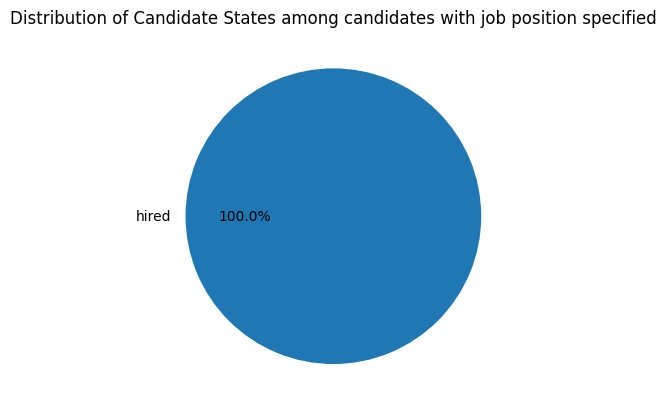

In [147]:
#filtered df with only candidates with job position specified
filtered_df = df.copy()
filtered_df = filtered_df[filtered_df['Year Of Recruitment'] != 'not specified']

counts = filtered_df.groupby('Id')['Candidate State'].last().value_counts()
counts_df = pd.DataFrame({'Candidate State': counts.index, 'Count': counts.values})
plt.pie(counts_df['Count'], labels=counts_df['Candidate State'], autopct='%1.1f%%')
plt.title('Distribution of Candidate States among candidates with job position specified')
plt.show()

###FILTER BY STATE
We need to filter candidates that have not been evaluated yet and candidates that should be considered eligible.

Possible chronological order for **`Event_Type__Val`**:
- *Initial phases*:
  - `Commercial note`
  - `CV request`
  - `Contact note`
  - `Research association`
- *Central phases*:
  - `HR interview`
  - `BM interview`
  - `Technical interview`
  - `Qualification Meeting`

- *Final phases*
  - `Candidate notification`: positive|negative
  - `Sending SC to customer`
  - `Economic proposal`
  - `Notify candidate`
  - `Inadequate CV`: it's an event that occurs in the first phases but it's a final stage of the recruiting process



In [148]:
initial_events = ['commercial note', 'cv request', 'contact note', 'research association']
central_events = ['hr interview', 'bm interview', 'technical interview', 'qualification meeting']
final_events = ['candidate notification', 'sending sc to customer', 'economic proposal', 'notify candidate', 'inadequate cv']

In [149]:
df['Candidate State'].unique()

array(['hired', 'vivier', 'qm', 'in selection', 'first contact',
       'economic proposal', 'imported'], dtype=object)

- **imported**: candidates imported from an external DB, that haven't responded yet
  - *cv request*: NO feedback **REMOVE**
  - *contact note*: NO feedback **REMOVE**
  - *bm interview*: feedback
  - *candidate notification*: NO feedback **REMOVE??**
  - *research association* NO feedback **REMOVE??**
  - *technical interview*: feedback
  - *hr interview*: feedback
  - *commercial note* NO feedback **REMOVE??**

In [150]:
df[df['Candidate State'] == 'imported']['Event_Type__Val'].value_counts()

Event_Type__Val
cv request                7345
contact note               144
bm interview                10
candidate notification       5
research association         3
technical interview          2
hr interview                 2
commercial note              1
Name: count, dtype: int64

In [151]:
events_to_remove = ['cv request', 'contact note', 'candidate notification', 'research association', 'commercial note']
df = df[~((df['Event_Type__Val'].isin(events_to_remove)) & (df['Candidate State'] == 'imported'))]

In [152]:
df[df['Candidate State'] == 'imported']['Event_Type__Val'].value_counts()

Event_Type__Val
bm interview           10
technical interview     2
hr interview            2
Name: count, dtype: int64

In [154]:
events = df[df['Candidate State'] == 'imported']['Event_Type__Val'].unique().tolist()
ids = df[(df['Candidate State'] == 'imported') & (df['Event_Type__Val'].isin(events))]['Id'].unique().tolist()
df[df['Id'].isin(ids)].sort_values(by=['Id', 'Year Of Insertion'])[['Id', 'Candidate State', 'Sex', 'Age Range', 'Study Area', 'Study Title', 'Last Role', 'Year Of Insertion', 'Residence Italian Province', 'Residence Italian Region']]

Id Candidate State     Sex      Age Range  \
9177     869        imported    male  26 - 30 years   
12730   2953        imported    male  26 - 30 years   
5127    3416        imported    male  26 - 30 years   
4143    4266        imported    male  26 - 30 years   
14428  30915        imported    male  26 - 30 years   
14429  30915        imported    male  26 - 30 years   
13680  33808        imported    male  20 - 25 years   
2758   44789        imported  female  26 - 30 years   
2783   58893        imported    male  26 - 30 years   
5193   66170        imported    male  26 - 30 years   
15044  68730        imported  female  20 - 25 years   
6493   72571        imported    male  26 - 30 years   
5554   75229        imported  female  20 - 25 years   
4589   76465        imported    male  26 - 30 years   

                                            Study Area        Study Title  \
9177   aeronautical/aerospace/astronautics engineering   five-year degree   
12730                             computer engineering   five-year degree   
5127   aeronautical/aerospace/astronautics engineering   five-year degree   
4143                            industrial engineering  three-year degree   
14428                           mechanical engineering   five-year degree   
14429                           mechanical engineering   five-year degree   
13680                           industrial engineering  three-year degree   
2758                            biomedical engineering   five-year degree   
2783                            biomedical engineering  three-year degree   
5193                            industrial engineering  three-year degree   
15044                           mechanical engineering  three-year degree   
6493                            biomedical engineering   five-year degree   
5554                            industrial engineering  three-year degree   
4589                            management engineering   five-year degree   

           Last Role  Year Of Insertion Residence Italian Province  \
9177   not specified               2022      barletta-andria-trani   
12730  not specified               2022                      turin   
5127   not specified               2021              caltanissetta   
4143   not specified               2021                      turin   
14428  not specified               2022                   florence   
14429  not specified               2022                   florence   
13680  not specified               2022                      turin   
2758   not specified               2021                      cuneo   
2783   not specified               2021                    catania   
5193   not specified               2021                      turin   
15044  not specified               2022                      turin   
6493   not specified               2021                       bari   
5554   not specified               2021                      turin   
4589   not specified               2021                    bologna   

      Residence Italian Region  
9177                    puglia  
12730                 piedmont  
5127                    sicily  
4143                  piedmont  
14428                  tuscany  
14429                  tuscany  
13680                 piedmont  
2758                  piedmont  
2783                    sicily  
5193                  piedmont  
15044                 piedmont  
6493                    puglia  
5554                  piedmont  
4589            emilia romagna

In [155]:
df.loc[df['Id'].isin(ids), 'Candidate State'] = 'in selection'

- **first contact**: candidates contacted for the first time, before interview. If they only have 1 row with no events they should be removed.

In [156]:
filtered_df = df.copy()
filtered_df = filtered_df[filtered_df['Candidate State']=='first contact']
ids = filtered_df['Id'].unique().tolist()

for id in ids:
  id_df = filtered_df[filtered_df['Id'] == id]
  events = id_df['Event_Type__Val'].unique().tolist()
  events = [e for e in events if e not in initial_events]
  events = [e for e in events if e != 'not specified']
  if len(events) == 0:
    df= df[~(df['Id'] == id)]

In [157]:
df[(df['Candidate State'] == 'first contact')].groupby('Id')['Event_Type__Val'].last().value_counts()

Event_Type__Val
candidate notification    165
technical interview       103
contact note               71
cv request                 11
inadequate cv              11
research association        6
commercial note             3
bm interview                3
sending sc to customer      2
Name: count, dtype: int64

Candidates should have at least the sector specified to be evaluated.

In [158]:
df = df[~(
    (df['Candidate State'] == 'first contact') &
    (df['Sector'] == 'not specified')
    )]

In [159]:
filtered_df = df.copy()
filtered_df = filtered_df[(
    (filtered_df['Candidate State'] == 'first contact') &
    (filtered_df['Event_Type__Val'].isin(initial_events))
)]
ids = filtered_df['Id'].unique().tolist()

filtered_df = df[df['Id'].isin(ids)]
filtered_df['Event_Type__Val'].unique()



array(['cv request', 'contact note', 'candidate notification',
       'technical interview', 'research association', 'inadequate cv',
       'bm interview', 'commercial note', 'sending sc to customer'],
      dtype=object)

In [160]:
df[(df['Candidate State'] == 'first contact')].groupby('Id')['Event_Type__Val'].last().value_counts()

Event_Type__Val
candidate notification    148
technical interview        87
contact note               65
inadequate cv              11
cv request                  6
research association        5
commercial note             3
sending sc to customer      2
bm interview                1
Name: count, dtype: int64

- **in selection**: This type of candidates are being evaluated.

In [161]:
filtered_df = df.copy()
filtered_df = filtered_df[filtered_df['Candidate State'] == 'in selection']
filtered_df.groupby('Id')['Event_Type__Val'].last().unique()

array(['candidate notification', 'bm interview', 'contact note',
       'hr interview', 'not specified', 'commercial note',
       'sending sc to customer', 'technical interview',
       'research association', 'cv request', 'inadequate cv'],
      dtype=object)

In [162]:
ids = filtered_df['Id'].unique().tolist()

for id in ids:
  id_df = filtered_df[filtered_df['Id'] == id]
  events = id_df['Event_Type__Val'].unique().tolist()
  events = [e for e in events if e not in initial_events]
  events = [e for e in events if e != 'not specified']
  sector = id_df['Sector'].unique().tolist()[0]
  if len(events) == 0 and sector == 'not specified':
    df= df[~(df['Id'] == id)]

In [163]:
df[(df['Candidate State'] == 'first contact')].groupby('Id')['Event_Type__Val'].last().value_counts()

Event_Type__Val
candidate notification    148
technical interview        87
contact note               65
inadequate cv              11
cv request                  6
research association        5
commercial note             3
sending sc to customer      2
bm interview                1
Name: count, dtype: int64

the majority of candidates with 'in selection' have candidate notification, which is the event where the outcome of the recruiting is communicated to the candidate. However no feedback is present.

In [164]:
filtered_df = filtered_df[filtered_df['Event_Type__Val']=='candidate notification']
filtered_df['Event_Feedback'].unique()

array(['not specified'], dtype=object)

In [165]:
df[(df['Candidate State'] == 'first contact')]['Event_Feedback'].value_counts()

Event_Feedback
not specified                 493
ok                             79
ok (live)                      37
ko (technical skills)           8
ko (seniority)                  5
ok (other candidate)            3
ko (lost availability)          2
ko (language skills)            2
ko (manager)                    1
ko (mobility)                   1
ok (waiting for departure)      1
ko (opportunity closed)         1
ko (retired)                    1
Name: count, dtype: int64

- **qm**: qualification meeting

In [166]:
df[(df['Candidate State'] == 'qm')].groupby('Id')['Event_Type__Val'].last().value_counts()

Event_Type__Val
bm interview              60
qualification meeting     47
contact note              23
sending sc to customer    18
hr interview              14
candidate notification    10
technical interview        7
commercial note            6
cv request                 5
inadequate cv              4
not specified              3
research association       2
Name: count, dtype: int64

In [167]:
df[(df['Candidate State'] == 'qm')]['Event_Feedback'].value_counts()

Event_Feedback
ok                            371
not specified                 277
ok (live)                      59
ko (technical skills)          42
ko (manager)                   17
ko (seniority)                 15
ko (opportunity closed)         9
ok (other candidate)            9
ko (proposed renunciation)      7
ko (retired)                    6
ok (waiting for departure)      5
ko (mobility)                   4
Name: count, dtype: int64

- **vivier**: this type of candidates weren't suitable for the position but are kept in the DB for future opportunities.

In [168]:
df[(df['Candidate State'] == 'vivier')].groupby('Id')['Event_Type__Val'].last().value_counts()

Event_Type__Val
bm interview              7
contact note              7
hr interview              3
candidate notification    2
research association      1
sending sc to customer    1
Name: count, dtype: int64

In [169]:
df[(df['Candidate State'] == 'vivier')]['Event_Feedback'].value_counts()

Event_Feedback
not specified                 46
ok                            32
ok (live)                     11
ko (technical skills)          5
ko (manager)                   4
ok (waiting for departure)     3
ko (lost availability)         3
ko (proposed renunciation)     1
Name: count, dtype: int64

- **economic proposal**

In [170]:
df[(df['Candidate State'] == 'economic proposal')].groupby('Id')['Event_Type__Val'].last().value_counts()

Event_Type__Val
economic proposal         20
bm interview              18
contact note               7
sending sc to customer     6
candidate notification     4
hr interview               4
research association       3
commercial note            3
inadequate cv              2
technical interview        2
qualification meeting      1
Name: count, dtype: int64

In [171]:
df[(df['Candidate State'] == 'economic proposal')]['Event_Feedback'].value_counts()

Event_Feedback
ok                            183
not specified                 116
ko (proposed renunciation)     27
ok (live)                      24
ok (waiting for departure)      8
ko (retired)                    8
ok (other candidate)            6
ko (seniority)                  4
ko (ral)                        3
ko (technical skills)           3
ko (mobility)                   2
ko (manager)                    2
ko (opportunity closed)         2
ok (hired)                      1
Name: count, dtype: int64

This candidate was likely contacted a second time for a research association and the initial position is no longer available. So it will be removed.

In [172]:
filtered_df = df[(df['Candidate State'] == 'economic proposal') & (df['Event_Feedback']=='ok (hired)')]
ids = filtered_df['Id'].unique().tolist()
filtered_df = df[df['Id'].isin(ids)]
filtered_df[['Id', 'Event_Type__Val', 'Event_Feedback', 'Job Family Hiring']]

Id         Event_Type__Val         Event_Feedback Job Family Hiring
12885  76402            bm interview                     ok     not specified
12886  76402  sending sc to customer                     ok     not specified
12887  76402   qualification meeting  ko (technical skills)     not specified
12888  76402       economic proposal             ok (hired)     not specified
12889  76402    research association          not specified     not specified
12890  76402  sending sc to customer   ok (other candidate)     not specified

In [173]:
df = df[~(df['Id'].isin(ids))]

- **hired**

In [174]:
df[(df['Candidate State'] == 'economic proposal')].groupby('Id')['Event_Type__Val'].last().value_counts()

Event_Type__Val
economic proposal         20
bm interview              18
contact note               7
sending sc to customer     5
candidate notification     4
hr interview               4
research association       3
commercial note            3
inadequate cv              2
technical interview        2
qualification meeting      1
Name: count, dtype: int64

In [176]:
filtered_df = df[(
    (df['Candidate State'] == 'hired') &
    (df['Event_Type__Val'] == 'inadequate cv')
)]

ids = filtered_df['Id'].unique().tolist()
filtered_df = df[df['Id'].isin(ids)]
filtered_df[['Id', 'Residence Italian Province', 'Event_Type__Val', 'Event_Feedback', 'Study Area', 'Job Description', 'Study Title', 'Study Level', 'Years Experience', 'Years Experience.1']]

Id Residence Italian Province         Event_Type__Val  \
365    12047            reggio-calabria              cv request   
366    12047            reggio-calabria            hr interview   
367    12047            reggio-calabria            bm interview   
368    12047            reggio-calabria            bm interview   
369    12047            reggio-calabria   qualification meeting   
370    12047            reggio-calabria  sending sc to customer   
371    12047            reggio-calabria       economic proposal   
372    12047            reggio-calabria           inadequate cv   
373    12047            reggio-calabria            bm interview   
374    12047            reggio-calabria  candidate notification   
2300   37231                   syracuse            bm interview   
2301   37231                   syracuse   qualification meeting   
2302   37231                   syracuse            bm interview   
2303   37231                   syracuse           inadequate cv   
2304   37231                   syracuse            bm interview   
3518    3593              monza-brianza            bm interview   
3519    3593              monza-brianza    research association   
3520    3593              monza-brianza           inadequate cv   
9078   14374                   vercelli            contact note   
9079   14374                   vercelli           inadequate cv   
9080   14374                   vercelli            bm interview   
9081   14374                   vercelli            bm interview   
10851  48598                      power     technical interview   
10852  48598                      power     technical interview   
10853  48598                      power            bm interview   
10854  48598                      power       economic proposal   
10855  48598                      power            bm interview   
10856  48598                      power           inadequate cv   
11042  62766                    livorno            contact note   
11043  62766                    livorno  candidate notification   
11044  62766                    livorno            bm interview   
11045  62766                    livorno            bm interview   
11046  62766                    livorno            bm interview   
11047  62766                    livorno           inadequate cv   
11756  49795      barletta-andria-trani   qualification meeting   
11757  49795      barletta-andria-trani            hr interview   
11758  49795      barletta-andria-trani           inadequate cv   
11759  49795      barletta-andria-trani            bm interview   
11760  49795      barletta-andria-trani            contact note   
11761  49795      barletta-andria-trani   qualification meeting   
18673    661                      prato            hr interview   
18674    661                      prato            bm interview   
18675    661                      prato  candidate notification   
18676    661                      prato           inadequate cv   
18677    661                      prato  sending sc to customer   
18861  29784                    palermo            contact note   
18862  29784                    palermo            bm interview   
18863  29784                    palermo            bm interview   
18864  29784                    palermo  candidate notification   
18865  29784                    palermo           inadequate cv   

                   Event_Feedback  \
365                 not specified   
366                            ok   
367          ok (other candidate)   
368                            ok   
369                    ok (hired)   
370                            ok   
371                    ok (hired)   
372                 not specified   
373                            ok   
374                 not specified   
2300                           ok   
2301                           ok   
2302                           ok   
2303                not specified   
2304                           ok   


###Suitable Candidates

In [177]:
positive_feedbacks = ['ok (other candidate)', 'ko (lost availability)', 'ok (hired)', 'ok (waiting for departure)',
                      'ko (opportunity closed)', 'ko (retired)', 'ko (ral)', 'ko (proposed renunciation)']

In [178]:
filtered_df = df[
    (df['Candidate State'] != 'hired') &
    (df['Event_Feedback'].isin(positive_feedbacks))
]

ids = filtered_df['Id'].unique().tolist()
filtered_df = df[df['Id'].isin(ids)]
filtered_df[['Id', 'Event_Type__Val', 'Event_Feedback', 'Job Family Hiring']]

Id    Event_Type__Val              Event_Feedback Job Family Hiring
32     36032       bm interview                          ok     not specified
33     36032       contact note               not specified     not specified
34     36032       contact note               not specified     not specified
35     36032       bm interview  ok (waiting for departure)     not specified
36     36032       bm interview                          ok     not specified
...      ...                ...                         ...               ...
20103  50823       hr interview                          ok     not specified
20104  50823       hr interview                          ok     not specified
20105  50823  economic proposal  ko (proposed renunciation)     not specified
20139  52436       contact note               not specified     not specified
20140  52436       hr interview                ko (retired)     not specified

[1275 rows x 4 columns]

If the last feedback is positive the candidate should be considered suitable, so it should be removed.

In [179]:
suitable_cands = []

for id in ids:
  id_df = filtered_df[filtered_df['Id'] == id]
  feedback = id_df['Event_Feedback'].tolist()[-1]
  if feedback in positive_feedbacks and feedback != 'ok' and feedback != 'ko':
    suitable_cands.append(id)

filtered_df[filtered_df['Id'].isin(suitable_cands)][['Id', 'Event_Type__Val', 'Event_Feedback', 'Job Family Hiring']].head(30)

Id         Event_Type__Val              Event_Feedback  \
107  49879              cv request               not specified   
108  49879           inadequate cv               not specified   
109  49879  sending sc to customer                          ok   
110  49879            bm interview                          ok   
111  49879            hr interview                          ok   
112  49879       economic proposal  ko (proposed renunciation)   
199  48448              cv request               not specified   
200  48448  candidate notification               not specified   
201  48448            bm interview                          ok   
202  48448            hr interview                          ok   
203  48448   qualification meeting  ok (waiting for departure)   
264    562            contact note               not specified   
265    562  candidate notification               not specified   
266    562     technical interview                   ok (live)   
267    562            bm interview                ko (retired)   
502  12233              cv request               not specified   
503  12233     technical interview                          ok   
504  12233            bm interview                          ok   
505  12233  candidate notification               not specified   
506  12233  sending sc to customer                ko (retired)   
526  54285              cv request               not specified   
527  54285            bm interview                   ok (live)   
528  54285            bm interview                          ok   
529  54285            bm interview                   ok (live)   
530  54285            contact note               not specified   
531  54285   qualification meeting  ok (waiting for departure)   
532  54285  sending sc to customer                ko (retired)   
533  54285  sending sc to customer                          ok   
534  54285       economic proposal  ko (proposed renunciation)   
803  20370              cv request               not specified   

    Job Family Hiring  
107     not specified  
108     not specified  
109     not specified  
110     not specified  
111     not specified  
112     not specified  
199     not specified  
200     not specified  
201     not specified  
202     not specified  
203     not specified  
264     not specified  
265     not specified  
266     not specified  
267     not specified  
502     not specified  
503     not specified  
504     not specified  
505     not specified  
506     not specified  
526     not specified  
527     not specified  
528     not specified  
529     not specified  
530     not specified  
531     not specified  
532     not specified  
533     not specified  
534     not specified  
803     not specified

In [180]:
positive_events = ['economic proposal', 'notify candidate']

In [181]:
filtered_df = df[
     (df['Candidate State'] != 'hired') &
     (df['Event_Type__Val'].isin(positive_events))]
ids = filtered_df['Id'].unique().tolist()
filtered_df = df[df['Id'].isin(ids)]

for id in ids:
  id_df = filtered_df[filtered_df['Id'] == id]
  event = id_df['Event_Type__Val'].tolist()[-1]
  feedback = id_df['Event_Feedback'].tolist()[-1]
  if event in positive_events and 'ko' not in feedback:
    suitable_cands.append(id)

filtered_df[filtered_df['Id'].isin(suitable_cands)].groupby('Id')['Candidate State'].last().value_counts()

Candidate State
economic proposal    22
Name: count, dtype: int64

In [182]:
filtered_df = df[df['Candidate State'] == 'economic proposal']
filtered_df.groupby('Id')[['Event_Type__Val', 'Event_Feedback']].last().value_counts()

Event_Type__Val         Event_Feedback            
bm interview            ok                            13
economic proposal       ko (proposed renunciation)    12
contact note            not specified                  7
candidate notification  not specified                  4
hr interview            ok                             3
commercial note         not specified                  3
research association    not specified                  3
economic proposal       ko (retired)                   3
                        ok                             2
                        not specified                  2
inadequate cv           not specified                  2
sending sc to customer  ko (opportunity closed)        2
bm interview            ok (live)                      2
sending sc to customer  not specified                  1
                        ko (seniority)                 1
technical interview     ko (seniority)                 1
sending sc to customer  ok                             1
bm interview            ko (manager)                   1
qualification meeting   ok                             1
hr interview            ok (live)                      1
bm interview            ko (mobility)                  1
economic proposal       ko (mobility)                  1
bm interview            ko (proposed renunciation)     1
technical interview     ok                             1
Name: count, dtype: int64

In [183]:
suitable_cand_df = df.copy()
suitable_cand_df = suitable_cand_df[suitable_cand_df['Id'].isin(suitable_cands)]
df = df[~df['Id'].isin(suitable_cands)]

In [184]:
n = len(candidates)
candidates = df['Id'].unique().tolist()
print(f"Number of removed candidates: {n-len(candidates)} ({(n-len(candidates))/n * 100:.2f}%)")

Number of removed candidates: 10379 (77.72%)


In [185]:
print(f"In the dataset there are now {len(candidates)} candidates, {df[df['Candidate State']=='hired']['Id'].unique().shape[0]} hired")

In the dataset there are now 2975 candidates, 497 hired


In [186]:
suitable_cand_df.shape[0]

475

###Export

In [187]:
df.to_excel(drive_dir+evaluated_file_path, index=False)
suitable_cand_df.to_excel(drive_dir+suitable_file_path, index=False)

## Sample Sorting
To ensure that the last row for each candidate is the most recent one we can sort the dataset:
  * by **ID**: rows of the same candidate will be near
  * by **Year Of Insertion**: If a candidate have more than one value for this column the rows will be chronologically ordered
  * by **Year Of Recruitment**: If a candidate have more than one value for this column (i.e. has been hired multiple times) the rows will be chronologically ordered
  * by **Candidate State**: to reflect the normal hiring process order of events

In [188]:
df = pd.read_excel(drive_dir+evaluated_file_path)

In [189]:
#sorting
df = df.sort_values(by=['Id', 'Year Of Insertion', 'Year Of Recruitment', 'Candidate State'], ascending=[True, True, True, True], kind='mergesort', na_position='first')
df = df.reset_index(drop=True)

## **Job Positions**
The job position is specified only for candidates who have been hired for that position. The other candidates have no information regarding the position for which they were not selected.

In [190]:
print(f"{df[(df['Year Of Recruitment'] == 'not specified') & (df['Job Title Hiring'] != 'not specified')].shape[0]} candidates have a specified position but have not been hired")

0 candidates have a specified position but have not been hired


In [191]:
for col in job_offer_columns:
  n = df[(df['Candidate State'] == 'hired') & (df[col] == 'not specified')]['Id'].unique().shape[0]
  print(f"{n} candidates have 'Hired' as <Candidate State> but have no <{col}> specified")

74 candidates have 'Hired' as <Candidate State> but have no <Recruitment Request> specified
2 candidates have 'Hired' as <Candidate State> but have no <Assumption Headquarters> specified
2 candidates have 'Hired' as <Candidate State> but have no <Job Family Hiring> specified
35 candidates have 'Hired' as <Candidate State> but have no <Job Title Hiring> specified
82 candidates have 'Hired' as <Candidate State> but have no <Job Description> specified
94 candidates have 'Hired' as <Candidate State> but have no <Candidate Profile> specified
70 candidates have 'Hired' as <Candidate State> but have no <Years Experience.1> specified
264 candidates have 'Hired' as <Candidate State> but have no <Minimum Ral> specified
192 candidates have 'Hired' as <Candidate State> but have no <Ral Maximum> specified
70 candidates have 'Hired' as <Candidate State> but have no <Study Level> specified
122 candidates have 'Hired' as <Candidate State> but have no <Study Area.1> specified
3 candidates have 'Hired' 

3 candidates have no job position specified but have 'Hired' as `Candidate State`. Since there is no way to know for which position they were eligible we can discard them.

In [192]:
df[
    (df['Candidate State'] == 'hired') &
    (df['Job Family Hiring'] == 'not specified')
][job_offer_columns]

Recruitment Request Assumption Headquarters Job Family Hiring  \
2888       not specified           not specified     not specified   
2889       not specified           not specified     not specified   
2890       not specified           not specified     not specified   
2891       not specified           not specified     not specified   
2892       not specified           not specified     not specified   
6313       not specified           not specified     not specified   

     Job Title Hiring Job Description Candidate Profile Years Experience.1  \
2888    not specified   not specified     not specified      not specified   
2889    not specified   not specified     not specified      not specified   
2890    not specified   not specified     not specified      not specified   
2891    not specified   not specified     not specified      not specified   
2892    not specified   not specified     not specified      not specified   
6313    not specified   not specified     not specified      not specified   

        Minimum Ral    Ral Maximum    Study Level   Study Area.1  \
2888  not specified  not specified  not specified  not specified   
2889  not specified  not specified  not specified  not specified   
2890  not specified  not specified  not specified  not specified   
2891  not specified  not specified  not specified  not specified   
2892  not specified  not specified  not specified  not specified   
6313  not specified  not specified  not specified  not specified   

     Linked_Search__Key  
2888          RS22.0959  
2889          RS22.0959  
2890          RS22.0959  
2891          RS22.0959  
2892          RS22.0959  
6313      not specified

In [193]:
df  = df[~(
    (df['Candidate State'] == 'hired') &
    (df['Job Family Hiring'] == 'not specified')
)]

In [194]:
candidates = df['Id'].unique().tolist()

In the dataset there are now 340 different *Job Offers* specified and 500 candidates hired for them. Each position has at least 1 hired candidate and some have more than one.

In [195]:
n_hired_candidates = df[df['Candidate State']=='hired']['Id'].unique().shape[0]
print(f"In the dataset there are {n_hired_candidates} ({n_hired_candidates/len(candidates)*100:.2f}%) hired candidates and {df['Job Description'].unique().shape[0]-1} different 'Job Description' specified")

In the dataset there are 495 (16.65%) hired candidates and 336 different 'Job Description' specified


## Columns that still change

In [196]:
cols = []

for col in df.columns:
  multiple_perc = multiple_percentage(df, col, 2, len(candidates))
  if multiple_perc > 0:
    cols.append(col)
    print(f"{multiple_perc:.2f}% of candidates have multiple {col} specified")

75.45% of candidates have multiple Event_Type__Val specified
29.30% of candidates have multiple Event_Feedback specified
21.83% of candidates have multiple Overall specified
23.04% of candidates have multiple Technical Skills specified
24.79% of candidates have multiple Standing/Position specified
26.61% of candidates have multiple Communication specified
26.77% of candidates have multiple Maturity specified
29.23% of candidates have multiple Dynamism specified
29.16% of candidates have multiple Mobility specified
18.16% of candidates have multiple English specified


After the data cleaning we have removed:

##New Cleaned Dataset

In [197]:
df.to_excel(drive_dir+cleaned_file_path, index=False)

##Feature Analysis

In [ ]:
df = pd.read_excel(drive_dir + cleaned_file_path)


In [198]:
candidates = df['Id'].unique().tolist()

### **`Candidate State`**

In [ ]:
#custom_order = ['Imported', 'First contact', 'In selection', 'QM', 'Vivier', 'Economic proposal', 'Hired']
custom_order = ['first contact', 'in selection', 'qm', 'vivier', 'economic proposal', 'hired']
df['Candidate State'] = pd.Categorical(df['Candidate State'], categories=custom_order, ordered=True)

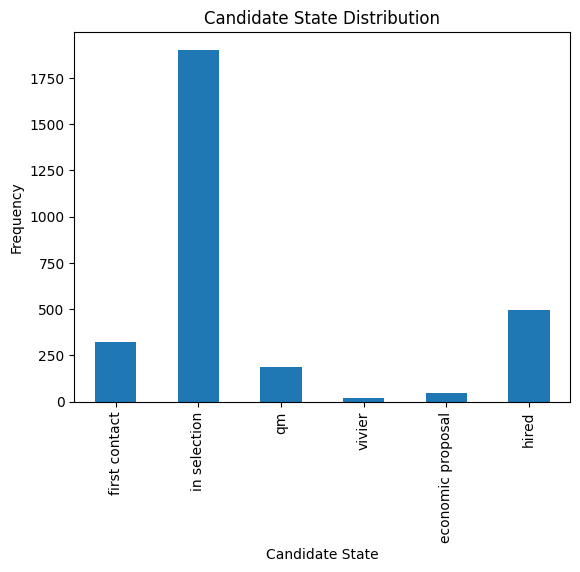

In [ ]:
getHist(df, 'Candidate State', custom_order)

### **`Age Range`**



In [ ]:
custom_order = ['< 20 years', '20 - 25 years', '26 - 30 years',
                '31 - 35 years', '36 - 40 years', '40 - 45 years', '> 45 years']
df['Age Range'] = pd.Categorical(df['Age Range'], categories=custom_order, ordered=True)

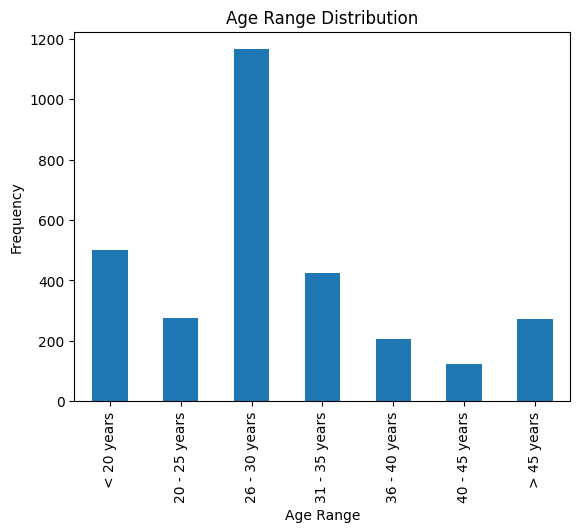

In [ ]:
getHist(df, 'Age Range', custom_order)

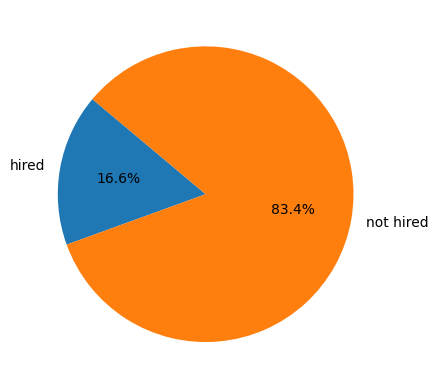

In [ ]:
new_df = df.copy()
new_df['Hired'] = new_df['Candidate State'].apply(lambda x: 'hired' if x == 'hired' else 'not hired')
getPie(new_df, 'Hired')

In [ ]:
n = new_df.loc[new_df['Hired'] == 'hired', 'Id'].unique().shape[0]
tot = new_df['Id'].unique().shape[0]

print(f"There are {n} hired candidates, over {tot} candidates ({n/tot*100:.2f}%)")

There are 495 hired candidates, over 2973 candidates (16.65%)


### **`Sex`**
The dataset is unbalanced with respect to Sex feature, with 80% male candidates and 20% female candidates.

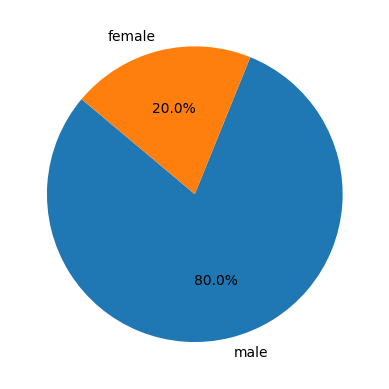

In [ ]:
getPie(df, 'Sex')

### **`Protected Category`**
The dataset is highly unbalanced with respect to this feature, with only 0.6% candidates from protected categories.




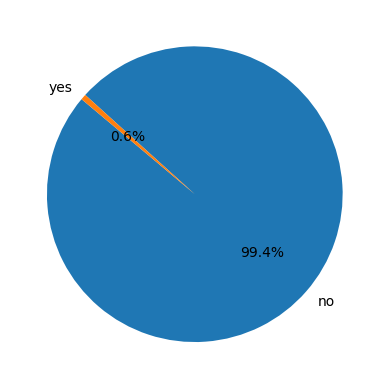

In [ ]:
getPie(df, 'Protected Category')

### **`Tag`**
This feature is highly irregular and will need processing in order to be useful. Some mapping could be applied to clean the data:

In [ ]:
print(df['Tag'].unique())

['catia (harness, part design, sheet metal), catia v5, enovia, harness, harness design, team leader'
 'project management, risks analysis, space' 'not specified' ...
 'materials, nastran, process engineering, quality'
 'cad, fem, reqview, system, system engineer' 'mechanical engineering']


In [ ]:
all_keywords = df.groupby('Id')['Tag'].first().str.split(', ').explode()
keyword_counts = Counter(all_keywords)

keyword_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Count'])
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'not specified'].index, inplace=True)
keyword_df['Keyword'] = keyword_df['Keyword'].str.upper()
keyword_df = keyword_df.sort_values(by='Count', ascending=False)

keyword_df.head(10)

Keyword  Count
13       MATLAB    535
14     SIMULINK    298
37   SOLIDWORKS    270
22            C    269
23          C++    251
21       PYTHON    238
86         JAVA    145
20        EXCEL    135
40      AUTOCAD    113
131      OFFICE    103

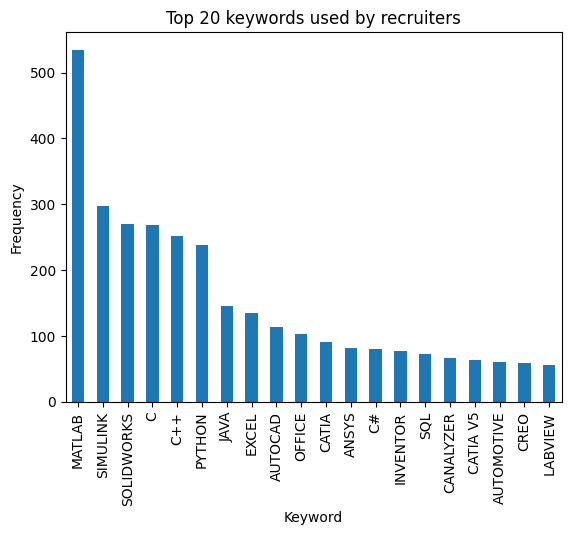

In [ ]:
keyword_df.head(20).plot(x='Keyword', y='Count', kind='bar', legend=False)
plt.title('Top 20 keywords used by recruiters')
plt.ylabel('Frequency')
plt.xlabel('Keyword')
plt.show()


### **`Study Area`**

In [ ]:
print(f"There are {len(df['Study Area'].unique())} different <Study Area> values:\n {df['Study Area'].unique()} \n")

There are 46 different <Study Area> values:
 ['aeronautical/aerospace/astronautics engineering'
 'mechanical engineering' 'computer engineering' 'biomedical engineering'
 'chemical engineering' 'electrical engineering' 'electronic engineering'
 'informatics' 'economic - statistics' 'chemist - pharmaceutical'
 'management engineering' 'other scientific subjects' 'psychology'
 'scientific maturity' 'other' 'industrial engineering'
 'other humanities subjects' 'accounting' 'energy and nuclear engineering'
 'automation/mechatronics engineering' 'automotive engineering'
 'information engineering' 'geo-biological' 'mathematics'
 'telecommunications engineering'
 'mathematical-physical modeling for engineering' 'surveyor'
 'naval engineering' 'defense and security' 'political-social' 'legal'
 'civil/civil and environmental engineering' 'literary'
 'engineering for the environment and the territory'
 'communication sciences' 'humanistic high school diploma' 'architecture'
 'materials science a

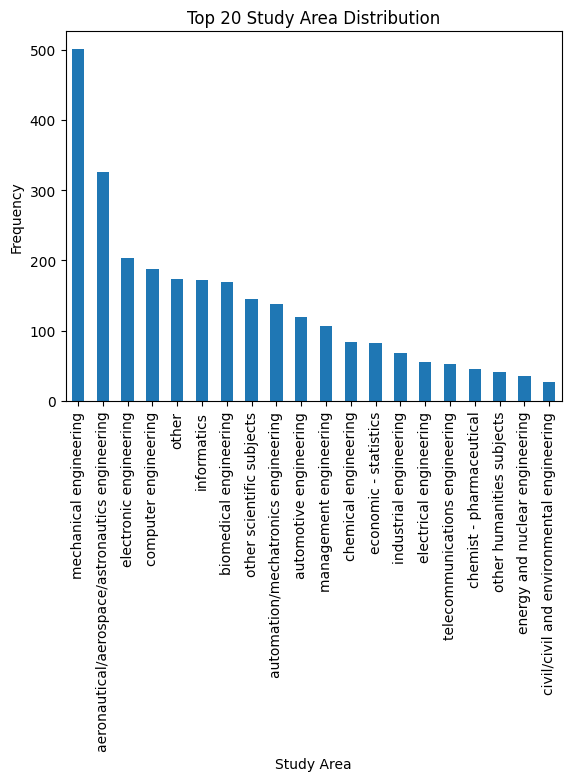

In [ ]:
getHist(df, 'Study Area', None)

### **`Study Title`**

In [ ]:
print(f"There are {len(df['Study Title'].unique())} different <Study Title> values:\n {df['Study Title'].unique()} \n")

There are 7 different <Study Title> values:
 ['professional qualification' 'five-year degree' 'three-year degree'
 "master's degree" 'high school graduation' 'middle school diploma'
 'doctorate'] 



In [ ]:
df.groupby('Id')['Study Title'].last().value_counts()

Study Title
five-year degree              1827
three-year degree              606
high school graduation         321
master's degree                129
doctorate                       44
professional qualification      42
middle school diploma            4
Name: count, dtype: int64

In [ ]:
custom_order = ['middle school diploma', 'professional qualification', 'high school graduation',
                'three-year degree', 'five-year degree', 'master\'s degree', 'doctorate']
df['Study Title'] = pd.Categorical(df['Study Title'], categories=costum_order, ordered=True)

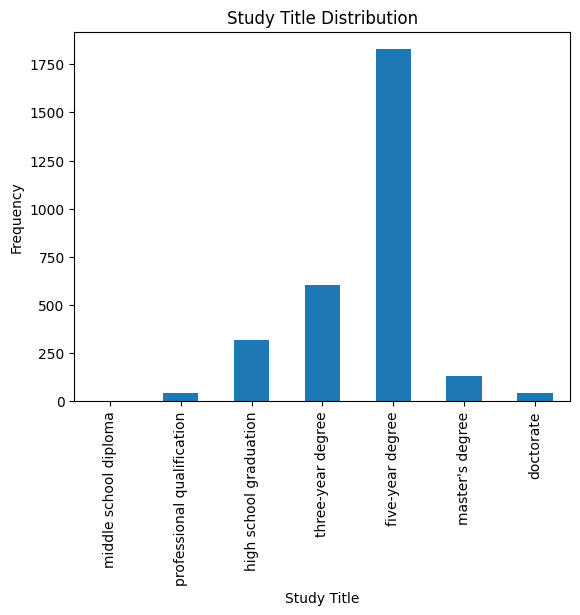

In [ ]:
getHist(df, 'Study Title', custom_order)

### **`Years Experience`**

In [ ]:
print(f"There are {len(df['Years Experience'].unique())} different <Years Experience> categories:\n {df['Years Experience'].unique()} \n")

There are 7 different <Years Experience> categories:
 ['[3-5]' '[0]' '[+10]' '[0-1]' '[1-3]' '[5-7]' '[7-10]'] 



In [ ]:
custom_order = ['[0]', '[0-1]', '[1-3]', '[3-5]', '[5-7]', '[7-10]', '[+10]']
df['Years Experience'] = pd.Categorical(df['Years Experience'], categories=custom_order, ordered=True)

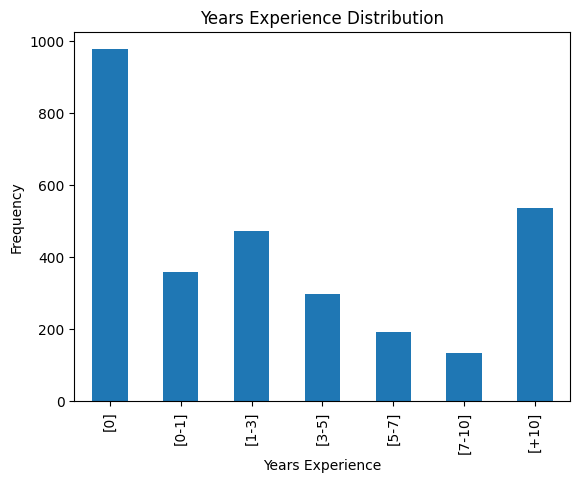

In [ ]:
getHist(df, 'Years Experience', custom_order)

### **`Sector`**
This feature doesn't seem relevant as its most frequent value is "*Others*".

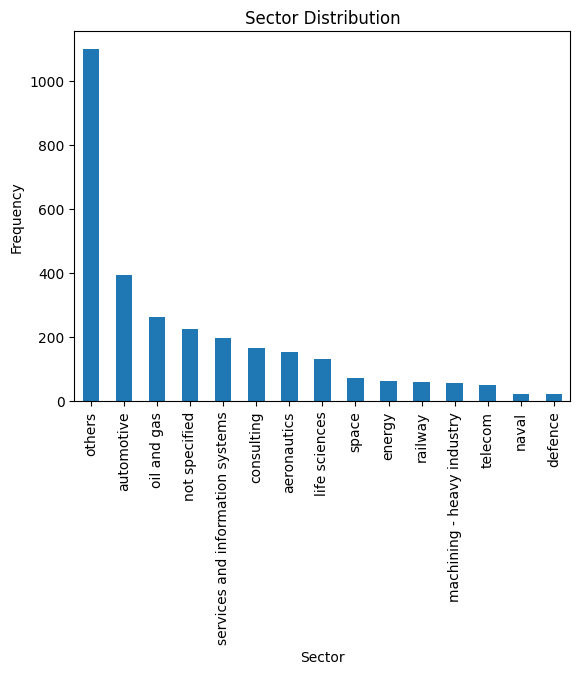

In [ ]:
getHist(df, 'Sector', None)

### **`Last Role`**

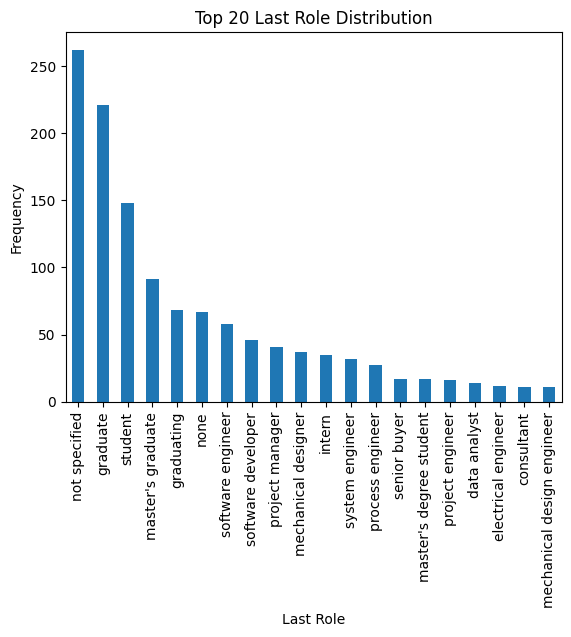

In [ ]:
getHist(df, 'Last Role', None)

In [ ]:
all_keywords = df.groupby('Id')['Last Role'].first().str.split(' ').explode()
keyword_counts = Counter(all_keywords)

keyword_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Count'])
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'not'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'specified'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'and'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'none'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == '&'].index, inplace=True)
keyword_df = keyword_df.sort_values(by='Count', ascending=False)

keyword_df.head(10)

Keyword  Count
3     engineer    665
31    graduate    315
22     manager    221
80    software    191
17     student    185
27   developer    168
21     project    123
30    master's    116
0     designer    106
25  mechanical    103

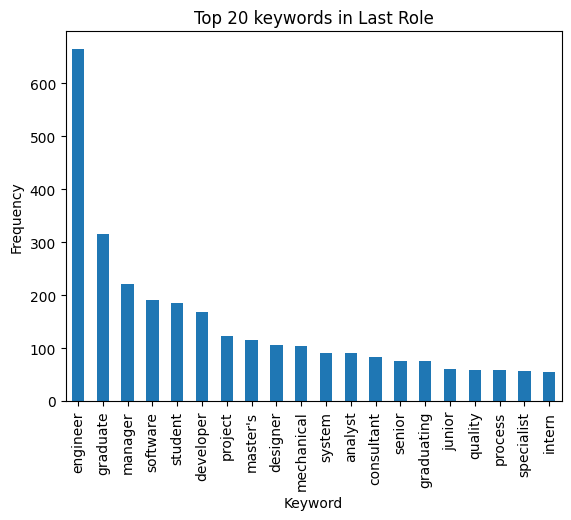

In [ ]:
keyword_df.head(20).plot(x='Keyword', y='Count', kind='bar', legend=False)
plt.title('Top 20 keywords in Last Role')
plt.ylabel('Frequency')
plt.xlabel('Keyword')
plt.show()


### **`Year Of Insertion`**

In [ ]:
custom_order = np.sort(df['Year Of Insertion'].unique().astype(str).tolist())

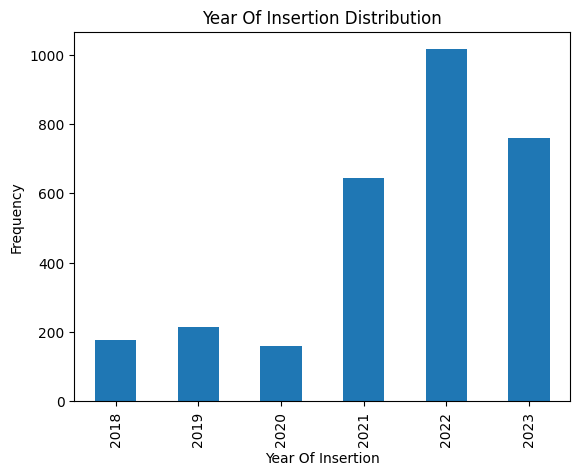

In [ ]:
getHist(df, 'Year Of Insertion', custom_order)

### **`Year Of Recruitment`**

In [ ]:
custom_order = np.sort(df['Year Of Recruitment'].unique().tolist())

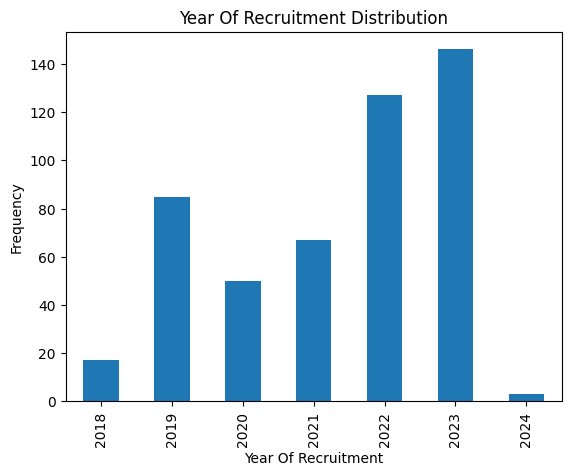

In [ ]:
getHist(df[df['Year Of Recruitment']!='not specified'], 'Year Of Recruitment', custom_order)

### **`Event_type__val`**
A possible chronological order could be useful to maintain only the last event.

In [ ]:
print(f"There are {len(df['Event_Type__Val'].unique())} different values for <Event_Type__Val:\n {df['Event_Type__Val'].unique()}")

There are 14 different values for <Event_Type__Val:
 ['hr interview' 'bm interview' 'technical interview' 'contact note'
 'candidate notification' 'inadequate cv' 'commercial note' 'cv request'
 'research association' 'not specified' 'sending sc to customer'
 'qualification meeting' 'economic proposal' 'notify candidate']


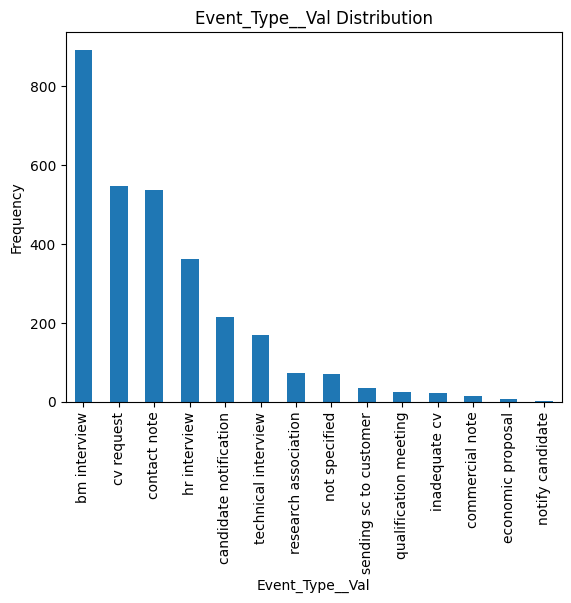

In [ ]:
getHist(df, 'Event_Type__Val', None)

### **`Event Feedback`**
There are many possible `Event_Feedback` in the dataset:

  * OK
    * other candidate: the candidate was not hired because the company chose someone else
    * live
    * waiting for departure
    * hired: the candidate is suitable for the position
  * KO
    * manager
    * technical skills: the candidate's skills are not suitable for the position
    * mobility: the candidate is not suitable for mobility reason, not related to skills
    * retired: the candidate retired
    * seniority: the candidate is too old | not enough senior
    * ral: candidate expected higher ral
    * opportunity closed: the candidate was not hired because the opportunity closed, *maybe similar to `OK (other candidate)`
    * proposed renunciation: the candidate has renounced the proposal
    * language skills: the candidate was not hired due to lack of language skills
    * lost availability

It might be useful to distinguish between positive and negative outcomes. For example, KO (ral) does not mean that the candidate was unsuitable, however we do not have the position that was offered to them.

In [ ]:
print(f"Possible values for <Event_Feedback>: \n {df['Event_Feedback'].unique()}")

Possible values for <Event_Feedback>: 
 ['ok' 'ok (waiting for departure)' 'not specified' 'ko (manager)'
 'ok (live)' 'ok (other candidate)' 'ko (technical skills)'
 'ko (mobility)' 'ko (language skills)' 'ok (hired)' 'ko (retired)'
 'ko (seniority)' 'ko (proposed renunciation)' 'ko (opportunity closed)'
 'ko (lost availability)' 'ko (ral)']


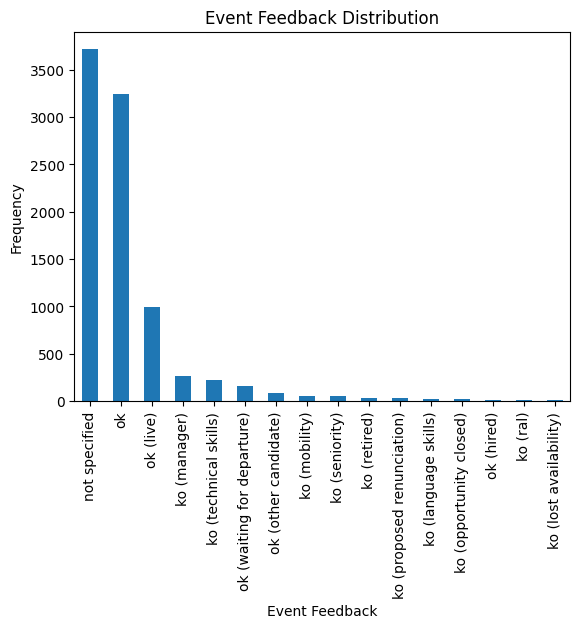

In [ ]:
filtered_count = df['Event_Feedback'].value_counts()

filtered_count.plot(kind='bar', legend=False)
plt.title('Event Feedback Distribution')
plt.ylabel('Frequency')
plt.xlabel('Event Feedback')
plt.show()

####Not Specified

In [ ]:
notSpec_counts = df.groupby('Id')['Event_Feedback'].apply(lambda x: (x == 'not specified').all())

tot_notSpec_counts = notSpec_counts.sum()
print(f"{tot_notSpec_counts/len(candidates)*100:.2f}% of candidates have 'Not Specified' in every row as <Event_Feedback>")

12.61% of candidates have 'Not Specified' in every row as <Event_Feedback>


Looking at the histogram below we can see that the majority of candidates who have no `Event_Feedback` specified (in every row) have 'First Contact' as `Candidate State`. This means that they are in the first stages of the recruiting process and so they don't have any feedback.

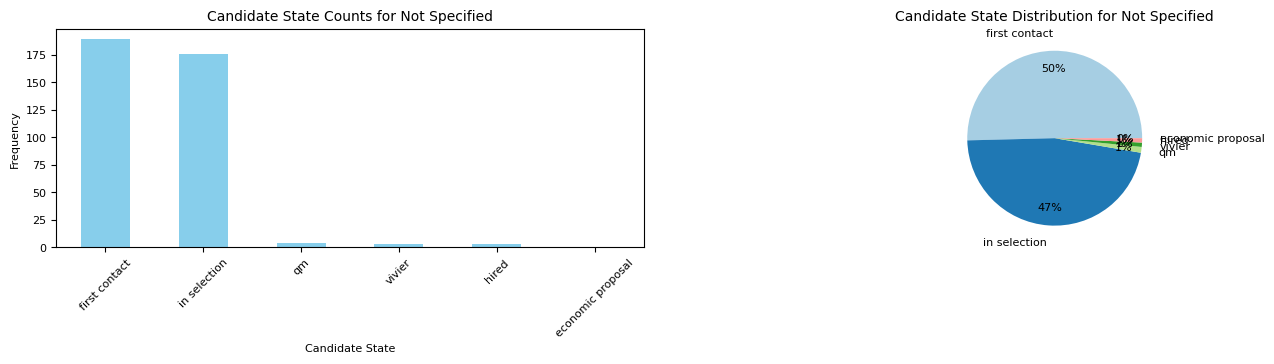

In [ ]:
notSpec_candidates = notSpec_counts[notSpec_counts].index
filtered_df = df[df['Id'].isin(notSpec_candidates)]

plot_graphs(filtered_df, 'Candidate State', 'Not Specified')

Looking at the distribution of `Event_Type__Val` among candidates for whom `Event_Feedback` is not specified, we can see that most of them have 'Contact note' and 'Candidate notification'.

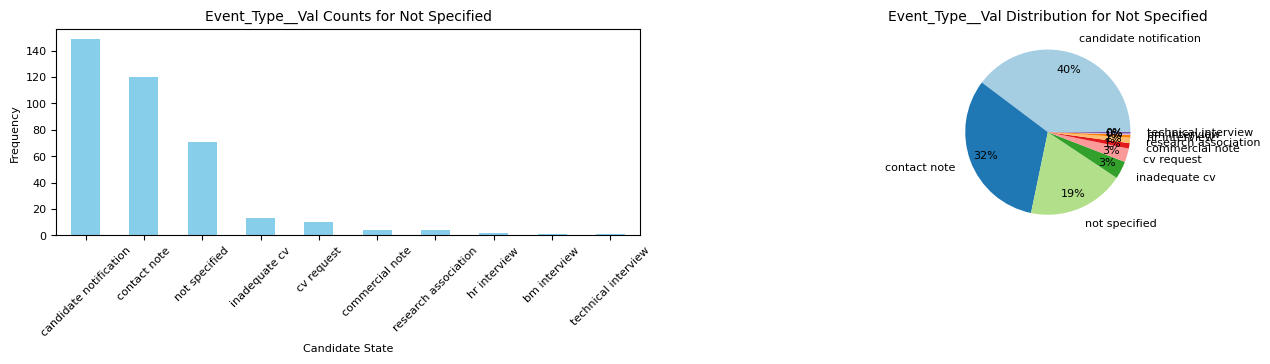

In [ ]:
plot_graphs(filtered_df, 'Event_Type__Val', 'Not Specified')

#### OK

1890 (63.57%) candidates have 'ok' as Event_Feedback 
(in at least one row)


75.03% of candidates (1418) with 'ok' (in at least one row) have no Job Position specified
 




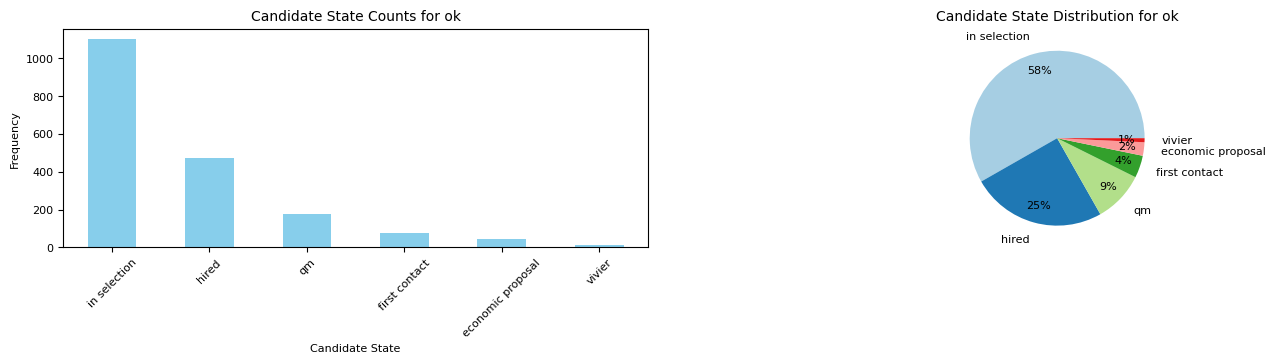

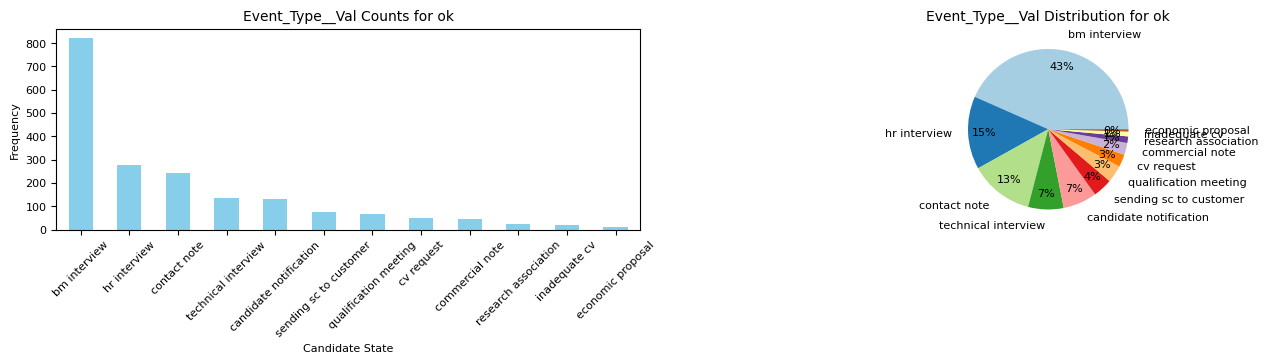

In [ ]:
getStats('Event_Feedback', 'ok')

#### OK (other candidate)
Only 2% of candidates have 'Ok (other candidate)' as `Event_Feedback`. 80% of those have 'In Selection' as `Candidate State`. This means that during the *Selection* phase another candidate was selected to continue the hiring process **??**.
90% have no *Job Position* specified.

79 (2.66%) candidates have 'ok (other candidate)' as Event_Feedback 
(in at least one row)


84.81% of candidates (67) with 'ok (other candidate)' (in at least one row) have no Job Position specified
 




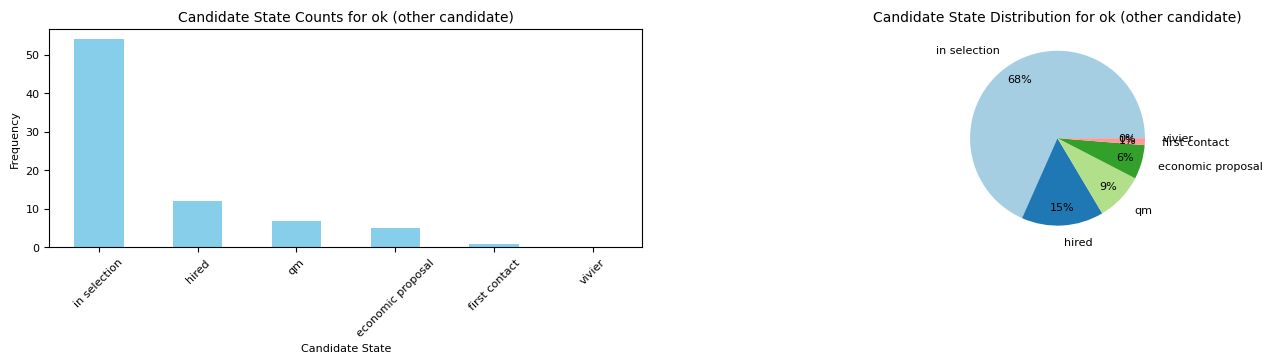

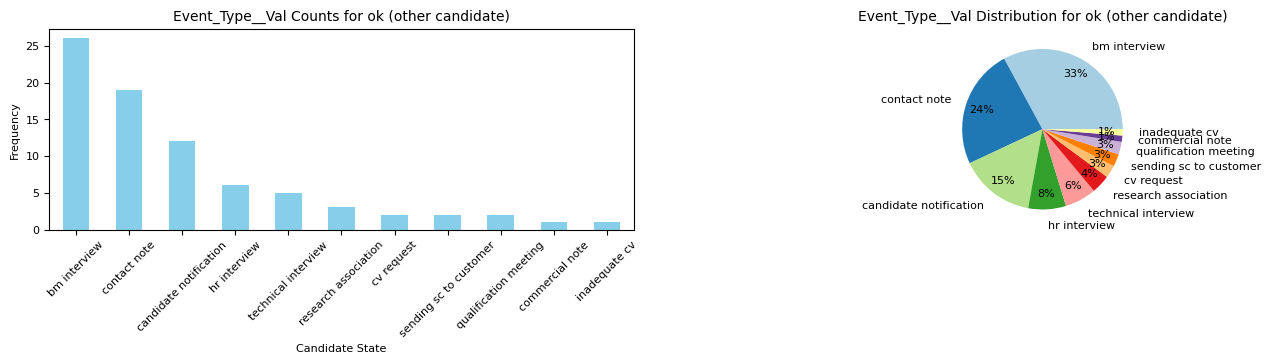

In [ ]:
getStats('Event_Feedback', 'ok (other candidate)')

#### OK (live)
15% of candidates have 'Ok (live)' as `Event_Feedback`. 90% of those have no *Job Position* specified and **75**% are still 'in selection'. This feedback is used for interviews.

836 (28.12%) candidates have 'ok (live)' as Event_Feedback 
(in at least one row)


88.40% of candidates (739) with 'ok (live)' (in at least one row) have no Job Position specified
 




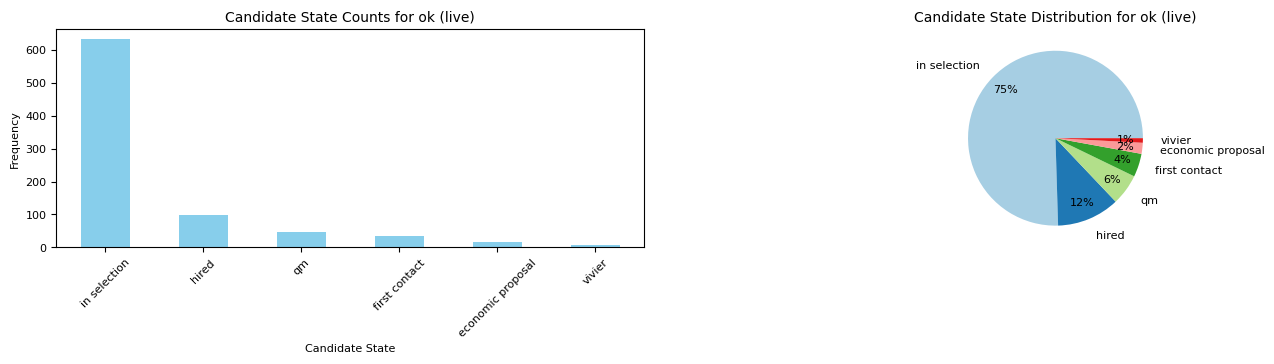

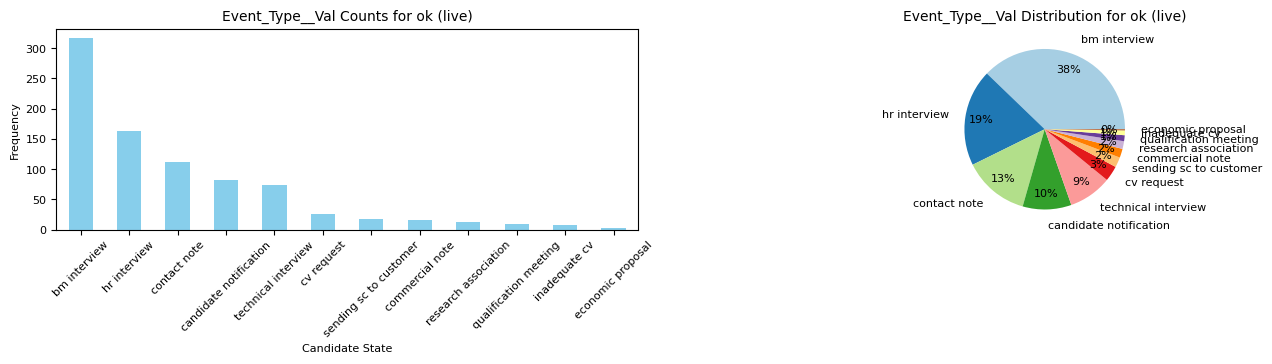

In [ ]:
getStats('Event_Feedback', 'ok (live)')

#### OK (waiting for departure)
This seems to mean that the candidate is suitable for the position and they are waiting to be hired. However 7% (19) of candidates that have this feedback have no job position specified. This is probably about a previous position as there is no candidate with this feedback as last feedback.

137 (4.61%) candidates have 'ok (waiting for departure)' as Event_Feedback 
(in at least one row)


7.30% of candidates (10) with 'ok (waiting for departure)' (in at least one row) have no Job Position specified
 




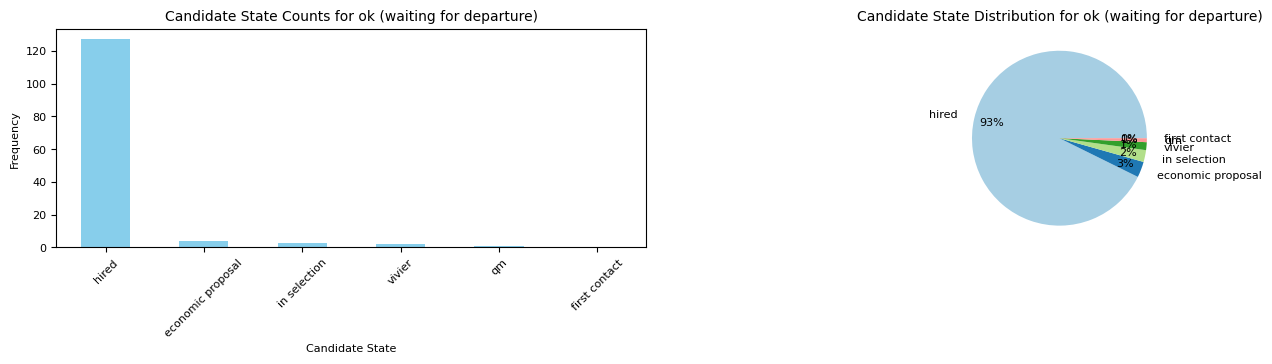

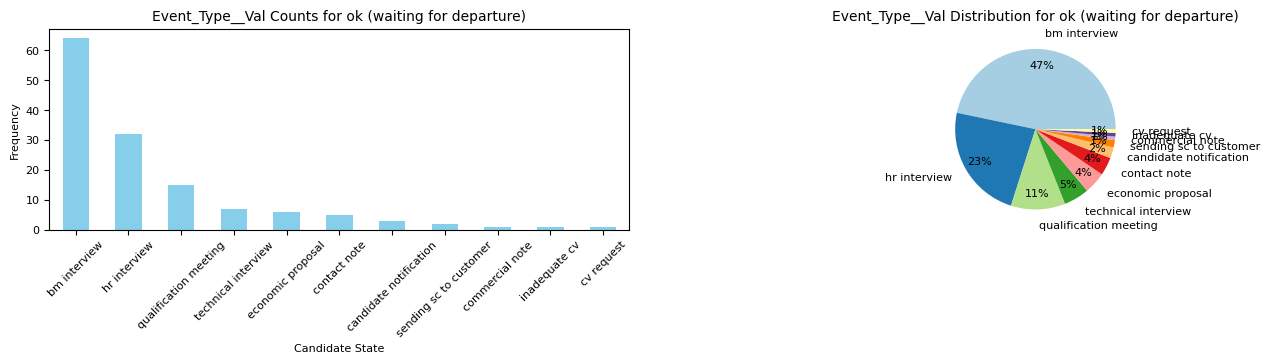

In [ ]:
getStats('Event_Feedback', 'ok (waiting for departure)')

#### OK (hired)


17 (0.57%) candidates have 'ok (hired)' as Event_Feedback 
(in at least one row)


0.00% of candidates (0) with 'ok (hired)' (in at least one row) have no Job Position specified
 




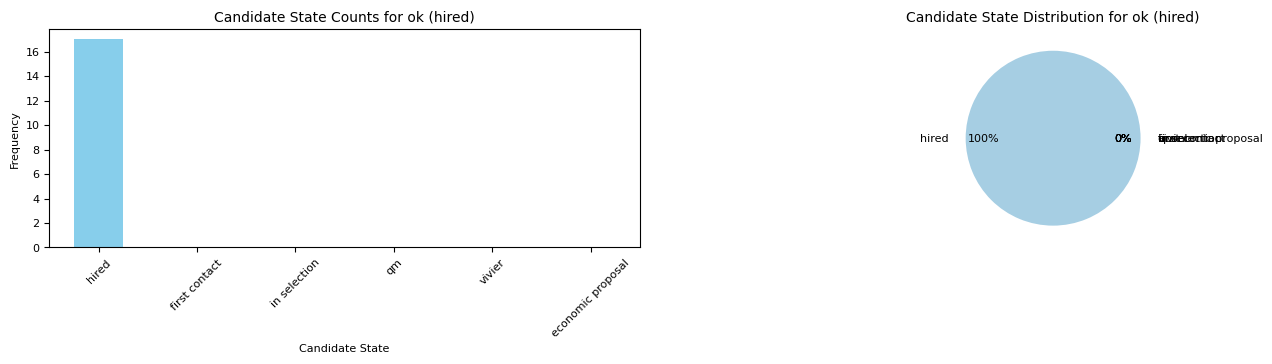

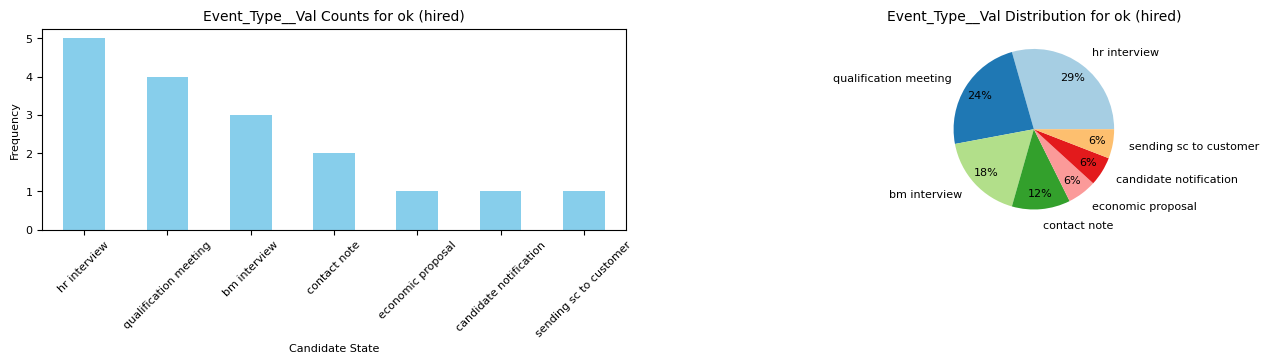

In [ ]:
getStats('Event_Feedback', 'ok (hired)')

#### KO (manager)
Interview with BM didn't go well.

249 (8.38%) candidates have 'ko (manager)' as Event_Feedback 
(in at least one row)


97.99% of candidates (244) with 'ko (manager)' (in at least one row) have no Job Position specified
 




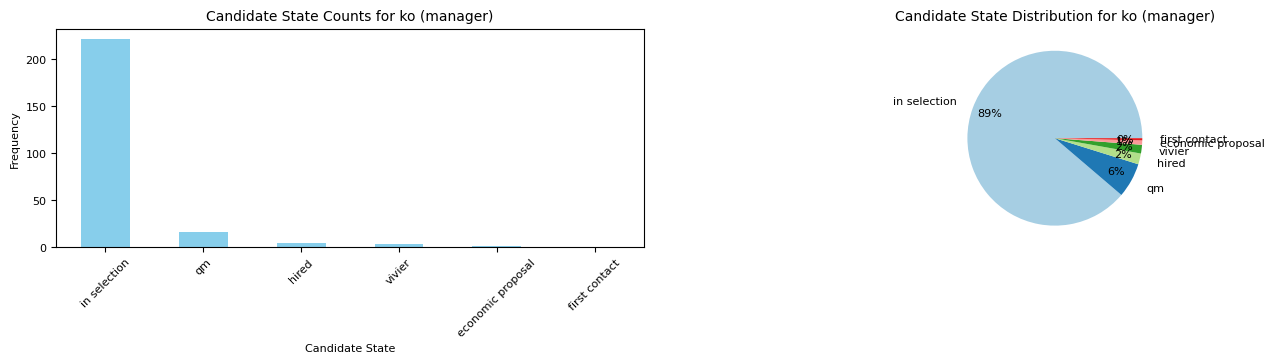

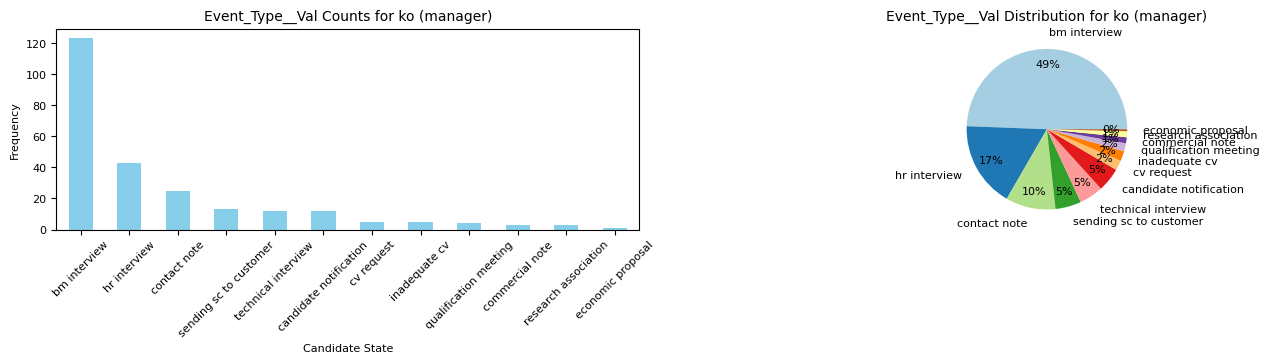

In [ ]:
getStats('Event_Feedback', 'ko (manager)')

#### KO (technical skills)

200 (6.73%) candidates have 'ko (technical skills)' as Event_Feedback 
(in at least one row)


94.00% of candidates (188) with 'ko (technical skills)' (in at least one row) have no Job Position specified
 




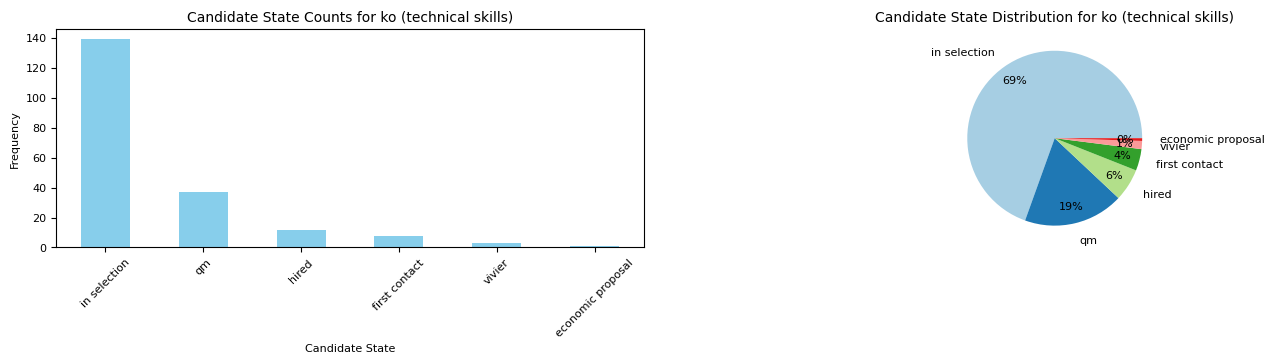

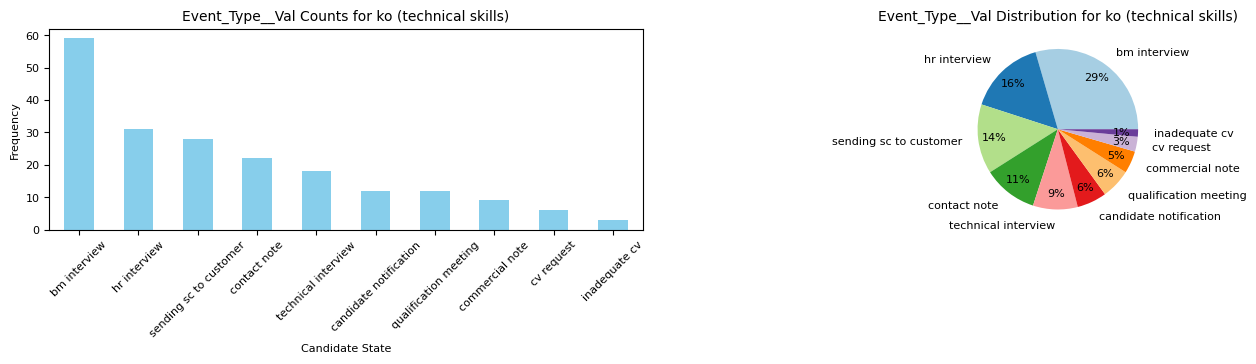

In [ ]:
getStats('Event_Feedback', 'ko (technical skills)')

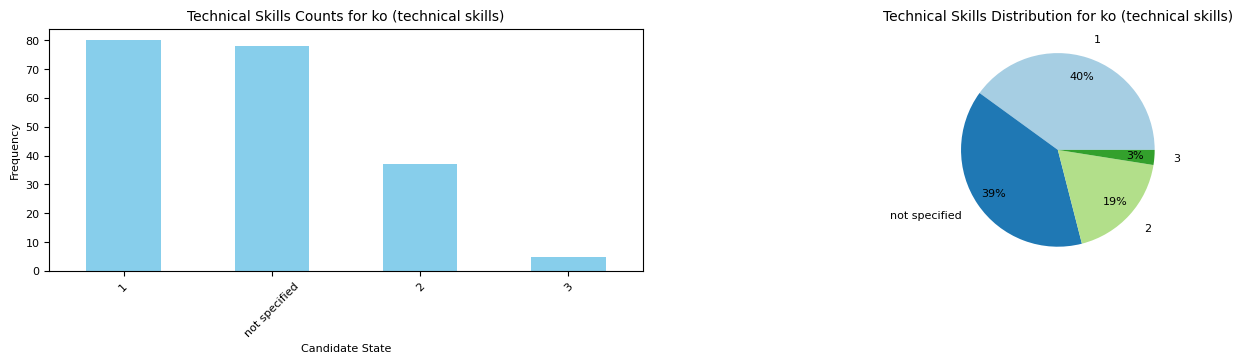

In [ ]:
plot_graphs(df[df['Event_Feedback'] == 'ko (technical skills)'],'Technical Skills','ko (technical skills)')

#### KO (mobility)

49 (1.65%) candidates have 'ko (mobility)' as Event_Feedback 
(in at least one row)


95.92% of candidates (47) with 'ko (mobility)' (in at least one row) have no Job Position specified
 




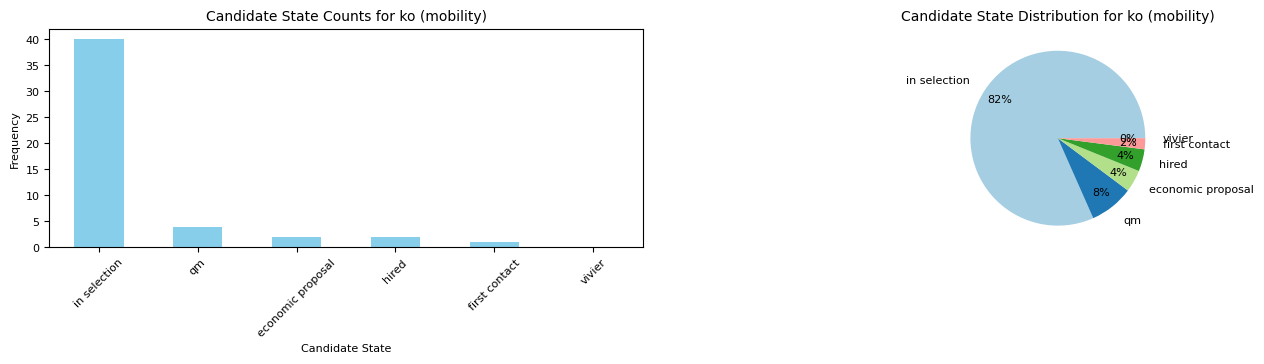

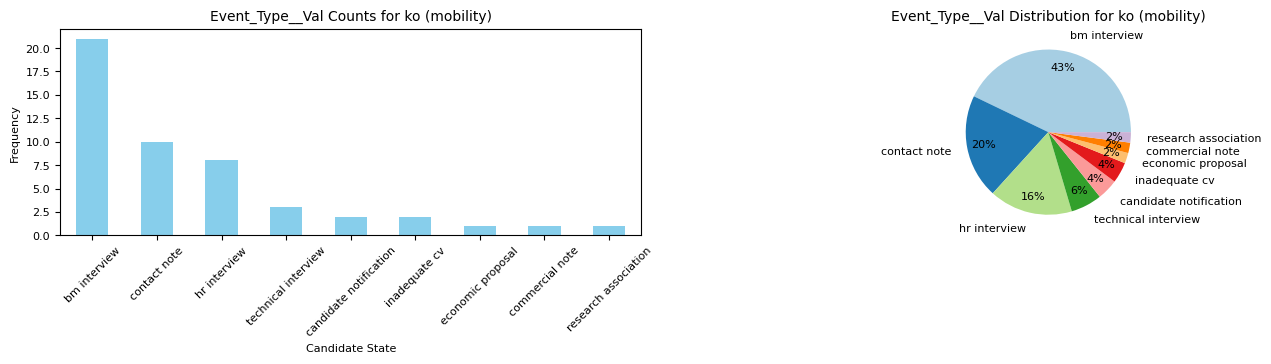

In [ ]:
getStats('Event_Feedback', 'ko (mobility)')

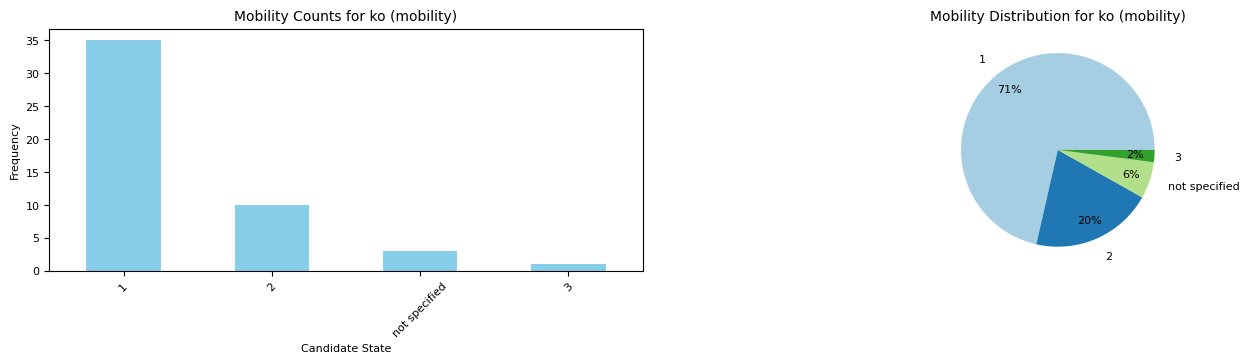

In [ ]:
plot_graphs(df[df['Event_Feedback'] == 'ko (mobility)'],'Mobility','ko (mobility)')

#### KO (retired)

38 (1.28%) candidates have 'ko (retired)' as Event_Feedback 
(in at least one row)


97.37% of candidates (37) with 'ko (retired)' (in at least one row) have no Job Position specified
 




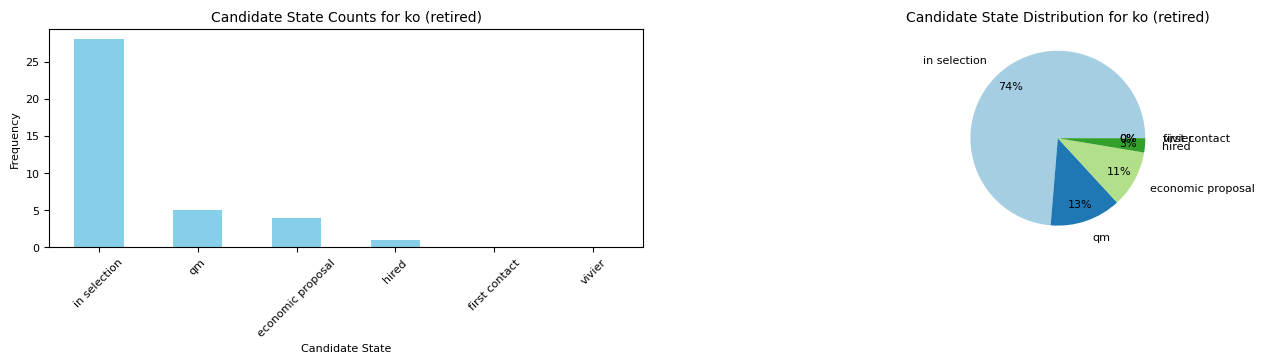

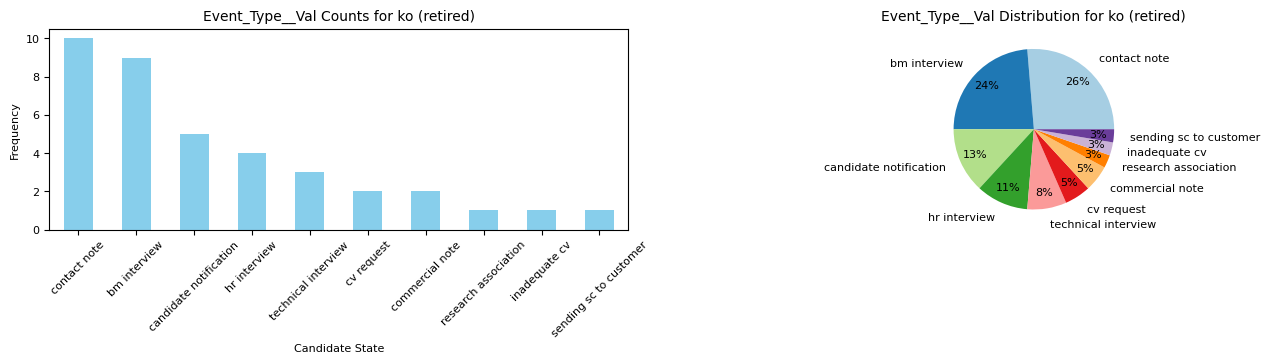

In [ ]:
getStats('Event_Feedback', 'ko (retired)')

#### KO (seniority)

49 (1.65%) candidates have 'ko (seniority)' as Event_Feedback 
(in at least one row)


95.92% of candidates (47) with 'ko (seniority)' (in at least one row) have no Job Position specified
 




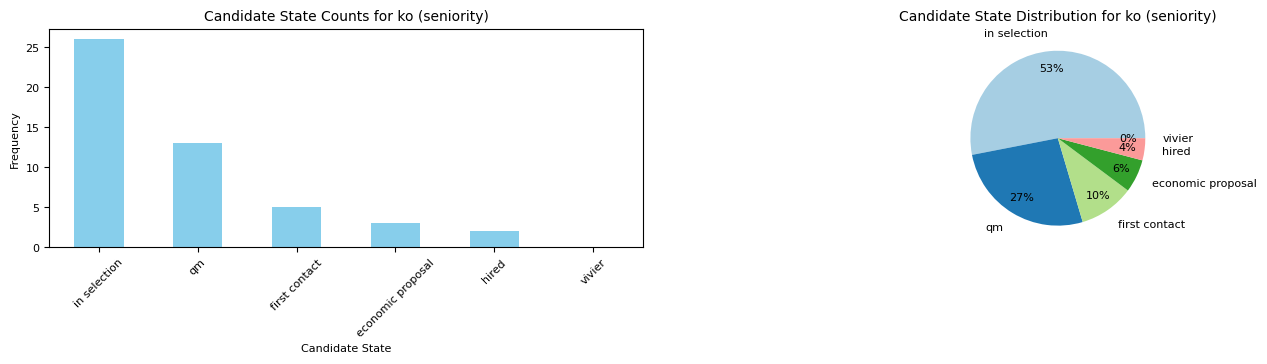

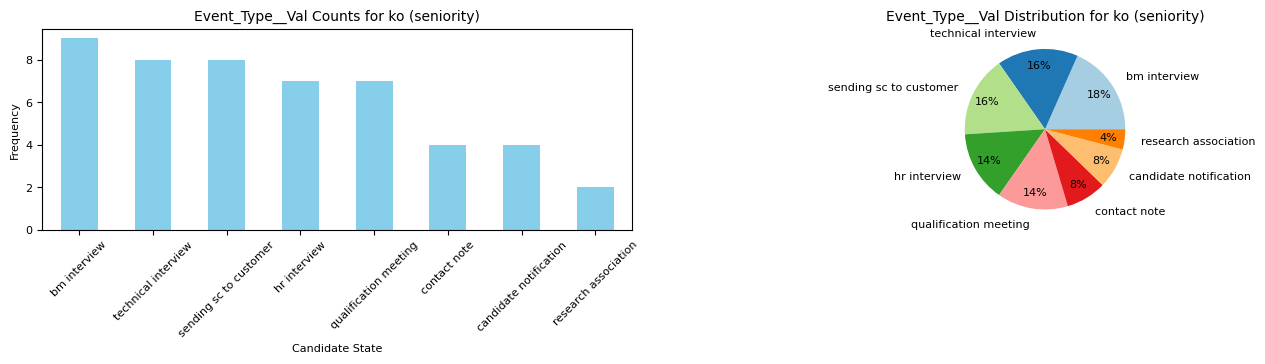

In [ ]:
getStats('Event_Feedback', 'ko (seniority)')

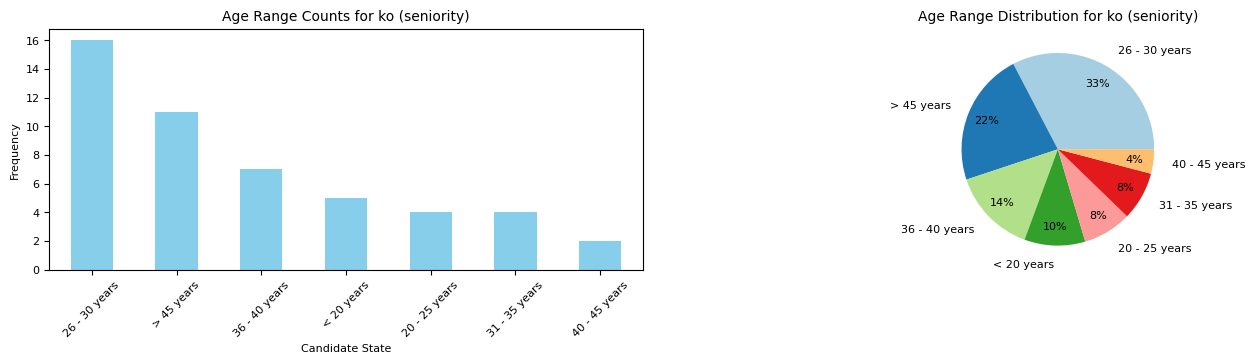

In [ ]:
plot_graphs(df[df['Event_Feedback'] == 'ko (seniority)'],'Age Range','ko (seniority)')

#### KO (ral)
This feedback could mean that the ral was not enough for the candidates. However almost every one of them have no *Job position* specified.

9 (0.30%) candidates have 'ko (ral)' as Event_Feedback 
(in at least one row)


88.89% of candidates (8) with 'ko (ral)' (in at least one row) have no Job Position specified
 




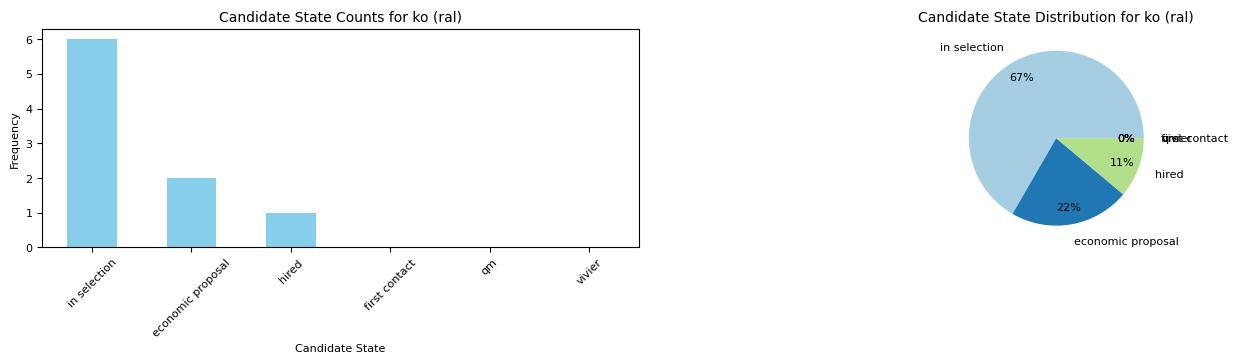

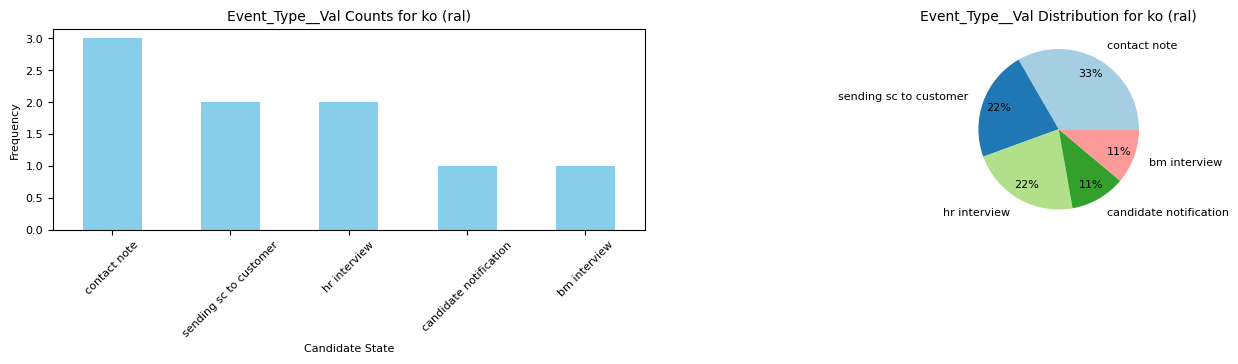

In [ ]:
getStats('Event_Feedback', 'ko (ral)')

#### KO (Closed Opportunity)
This does not necessarily mean that the candidate was not suitable for the position, however, since most of these candidates do not have a specified position, they will be considered ineligible.

20 (0.67%) candidates have 'ko (opportunity closed)' as Event_Feedback 
(in at least one row)


90.00% of candidates (18) with 'ko (opportunity closed)' (in at least one row) have no Job Position specified
 




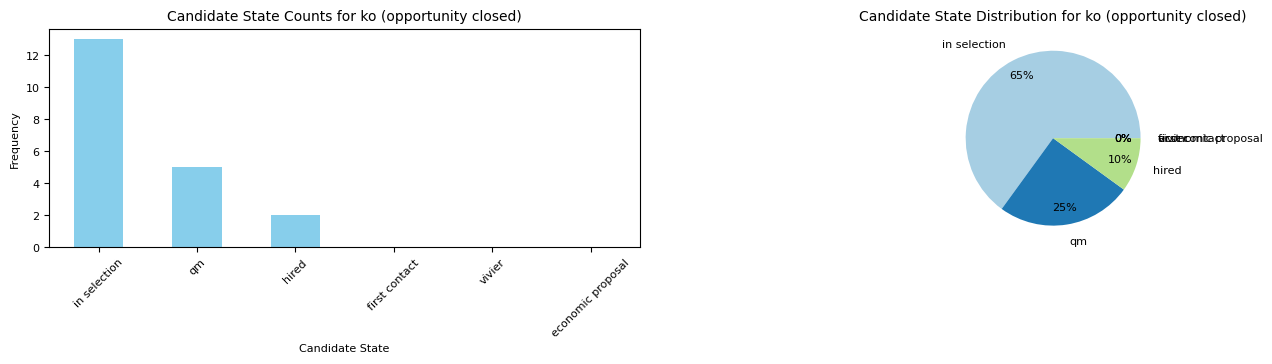

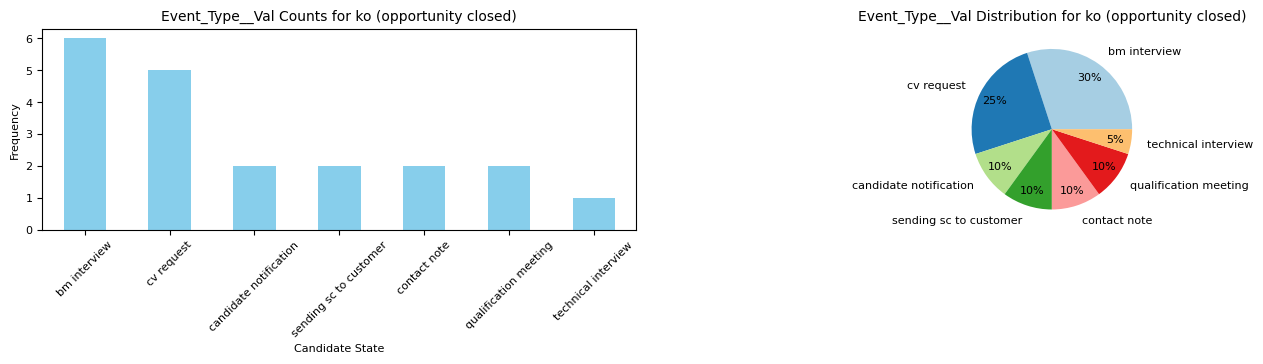

In [ ]:
getStats('Event_Feedback', 'ko (opportunity closed)')

#### KO (proposed renunciation)

28 (0.94%) candidates have 'ko (proposed renunciation)' as Event_Feedback 
(in at least one row)


89.29% of candidates (25) with 'ko (proposed renunciation)' (in at least one row) have no Job Position specified
 




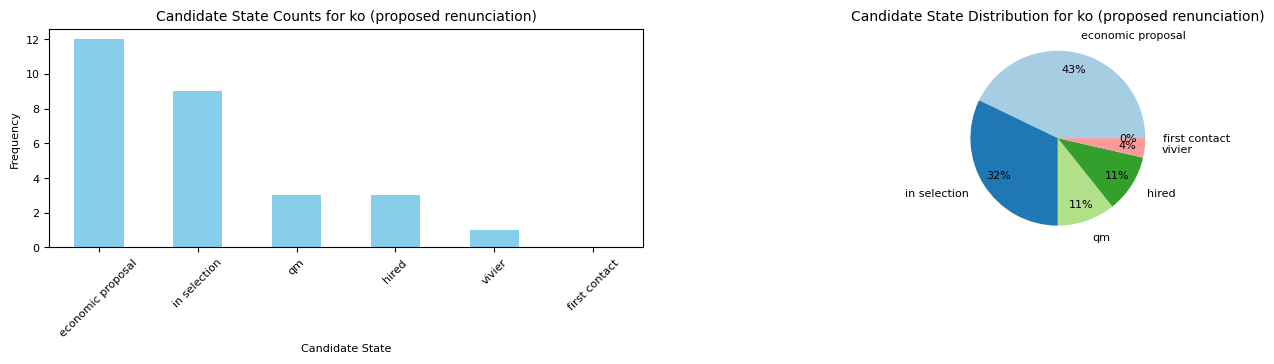

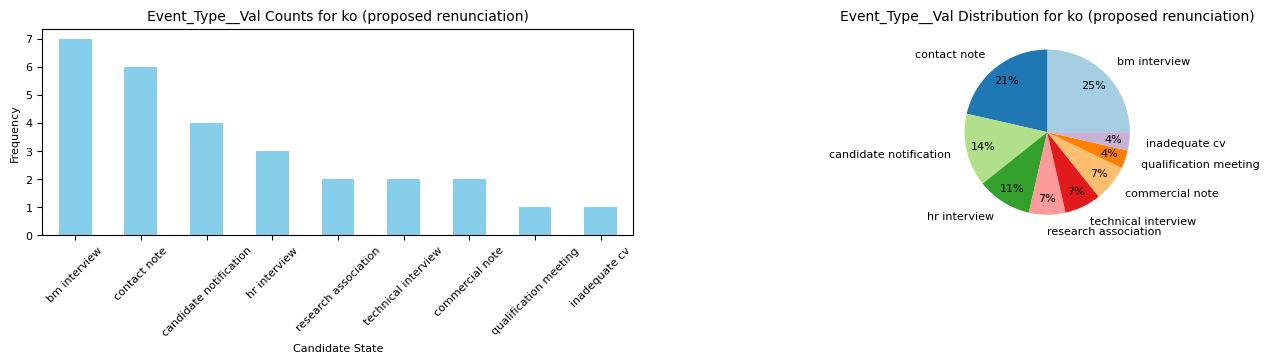

In [ ]:
getStats('Event_Feedback', 'ko (proposed renunciation)')

#### KO (language skills)

20 (0.67%) candidates have 'ko (language skills)' as Event_Feedback 
(in at least one row)


100.00% of candidates (20) with 'ko (language skills)' (in at least one row) have no Job Position specified
 




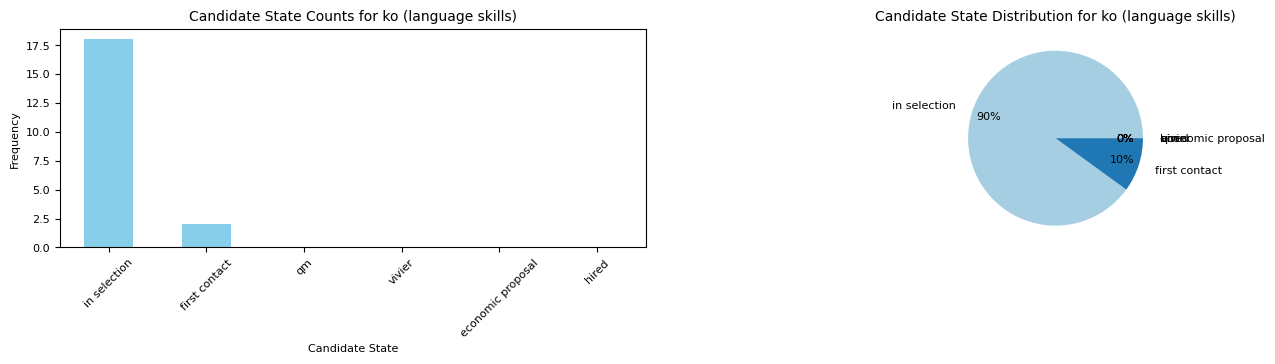

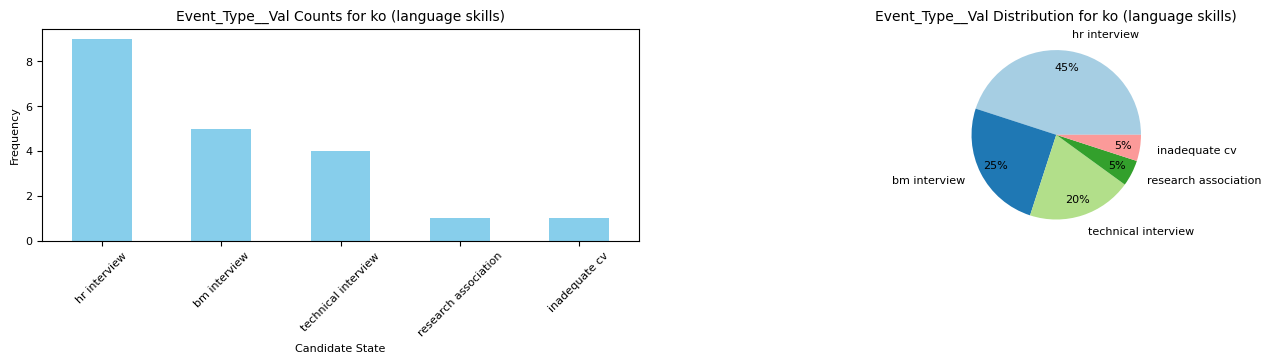

In [ ]:
getStats('Event_Feedback', 'ko (language skills)')

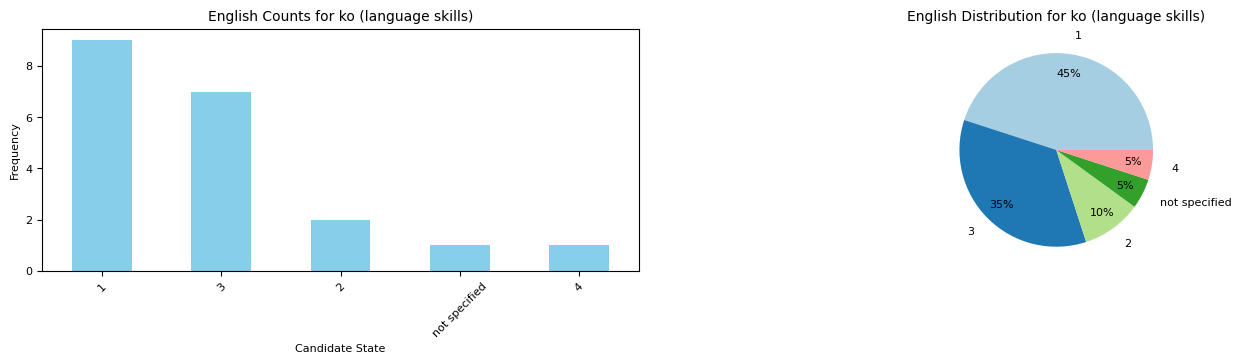

In [ ]:
plot_graphs(df[df['Event_Feedback'] == 'ko (language skills)'],'English','ko (language skills)')

#### KO (lost availability)

9 (0.30%) candidates have 'ko (lost availability)' as Event_Feedback 
(in at least one row)


100.00% of candidates (9) with 'ko (lost availability)' (in at least one row) have no Job Position specified
 




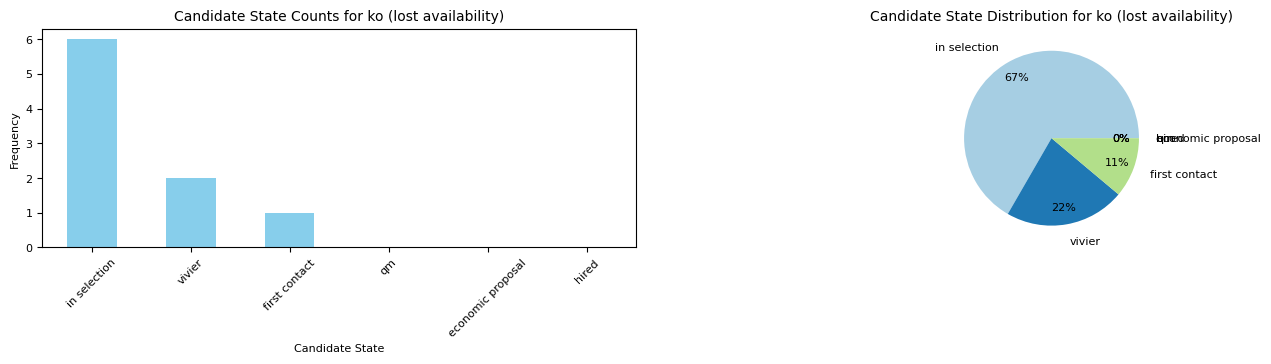

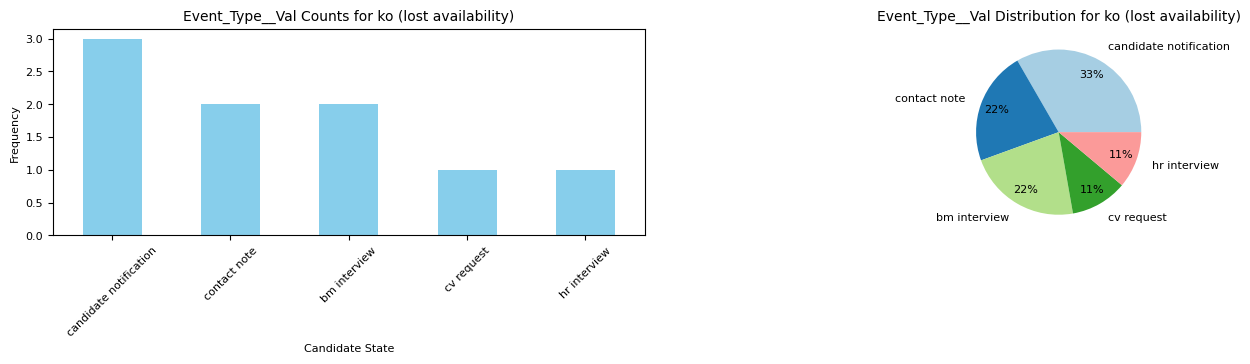

In [ ]:
getStats('Event_Feedback', 'ko (lost availability)')

### **`Overall`**

In [ ]:
custom_order = np.sort(df['Overall'].unique().tolist())

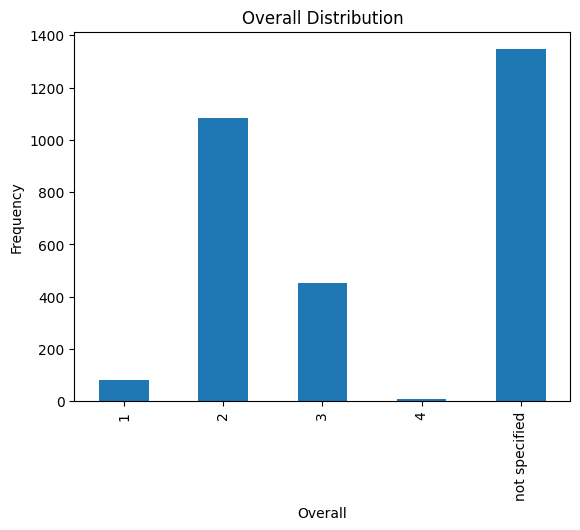

In [ ]:
getHist(df, 'Overall', custom_order)

### **`Current Ral`**

In [ ]:
col = 'Current Ral'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')
custom_order.remove('+50k')
custom_order.append('+50k')

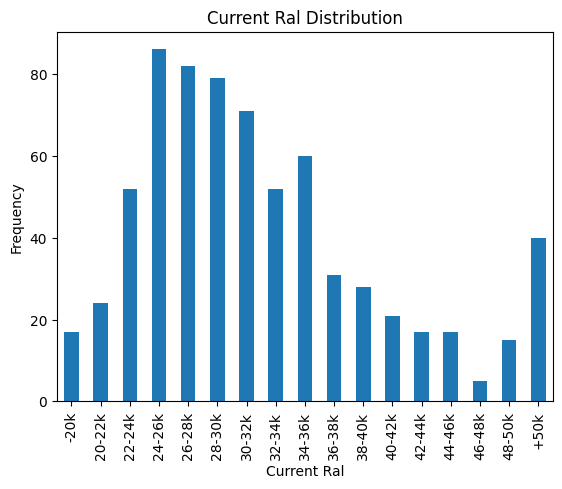

In [ ]:
getHist(df[df['Current Ral'] != 'not specified'], col, custom_order)

### **`Expected Ral`**

In [ ]:
col = 'Expected Ral'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')
custom_order.remove('+50k')
custom_order.append('+50k')

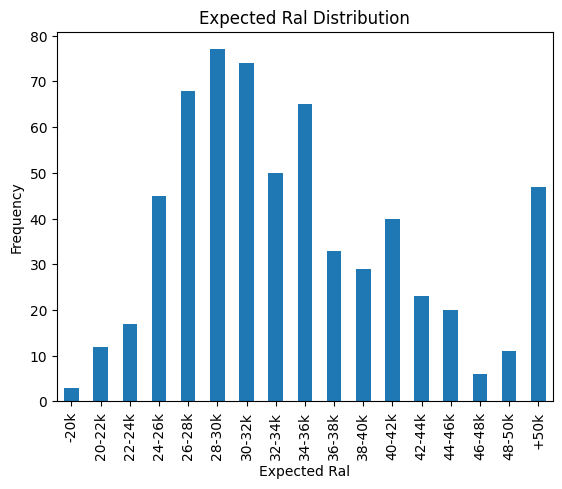

In [ ]:
getHist(df[df['Expected Ral'] != 'not specified'], col, custom_order)

### **`Technical Skills`**

In [ ]:
col = 'Technical Skills'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

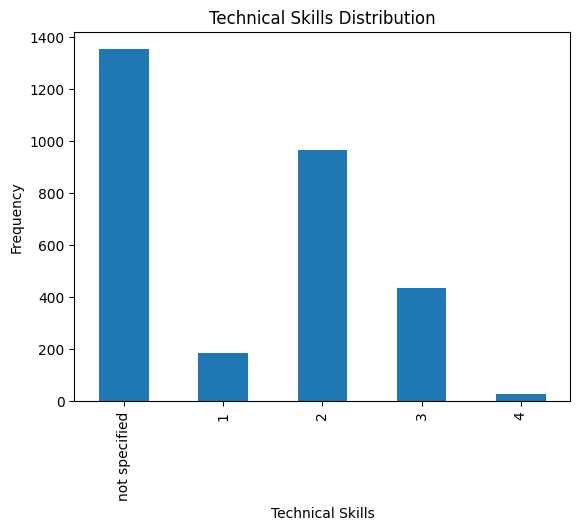

In [ ]:
getHist(df, col, custom_order)

### **`Standing/Position`**

In [ ]:
col = 'Standing/Position'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

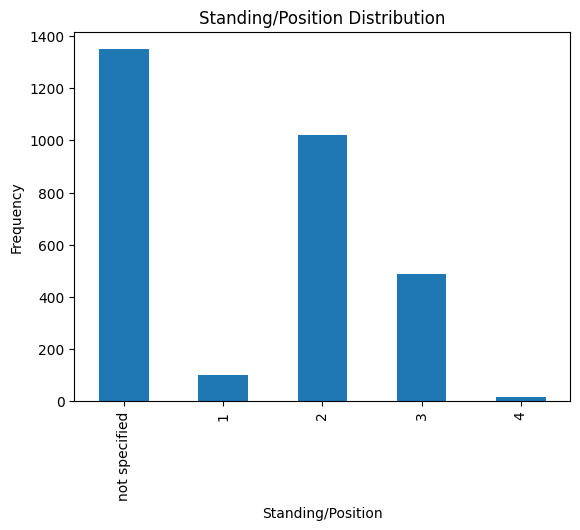

In [ ]:
getHist(df, col, custom_order)

### **`Communication`**

In [ ]:
col = 'Communication'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

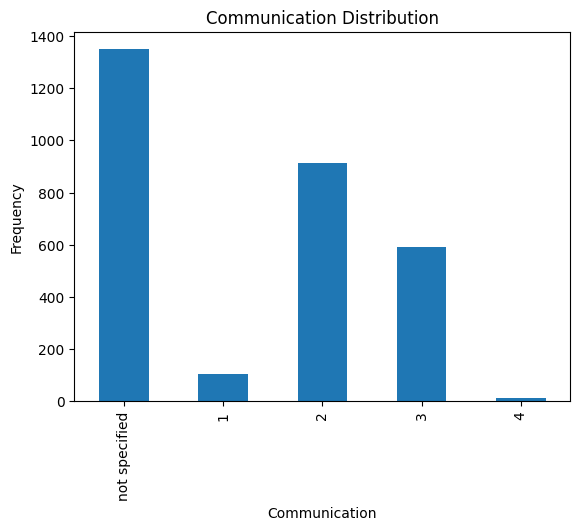

In [ ]:
getHist(df, col, custom_order)

### **`Maturity`**



In [ ]:
col = 'Maturity'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

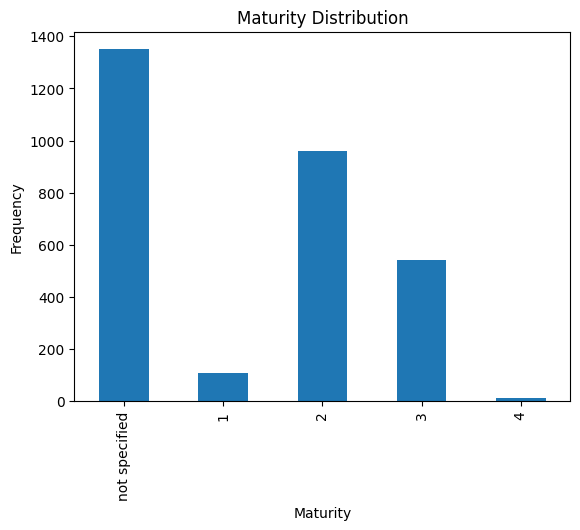

In [ ]:
getHist(df, col, custom_order)

### **`Dynamism`**

In [ ]:
col = 'Dynamism'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

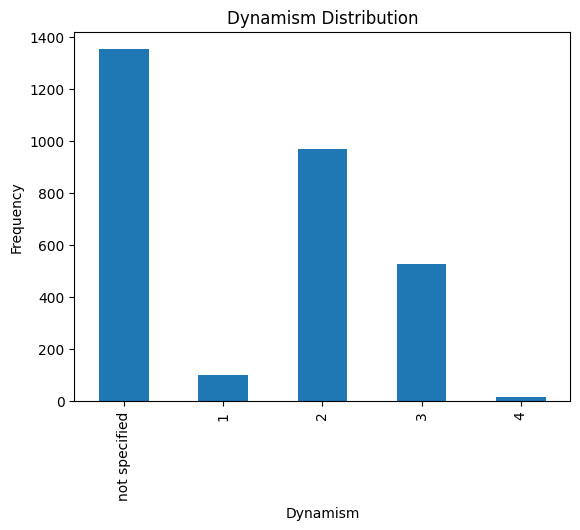

In [ ]:
getHist(df, col, custom_order)

### **`Mobility`**

In [ ]:
col = 'Mobility'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

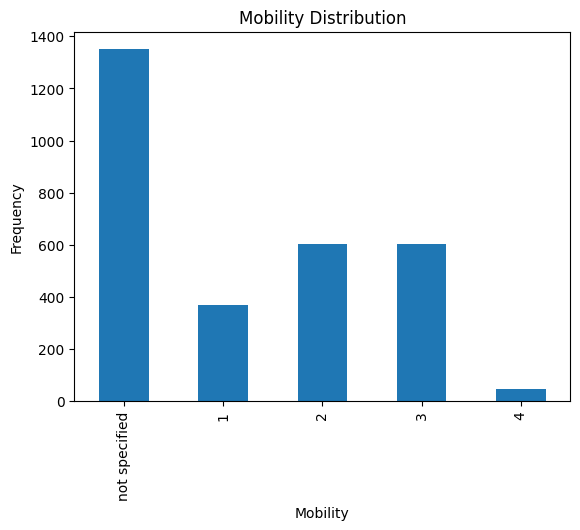

In [ ]:
getHist(df, col, custom_order)

### **`English`**

In [ ]:
col = 'English'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

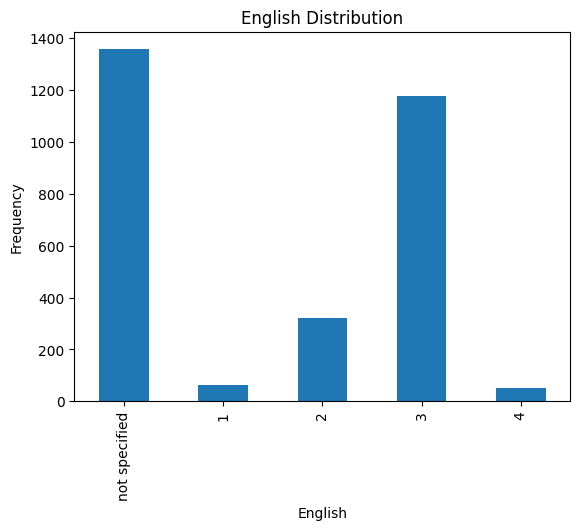

In [ ]:
getHist(df, col, custom_order)

### **`European Residence`**

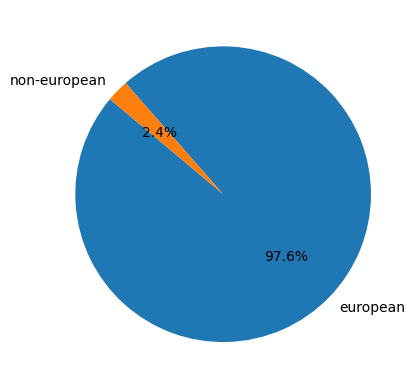

In [ ]:
getPie(df, 'European Residence')

### **`Italian Residence`**

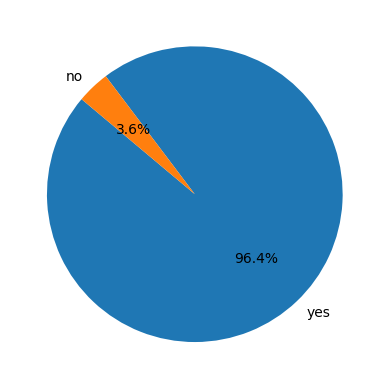

In [ ]:
getPie(df, 'Italian Residence')

### **`Residence Country`**

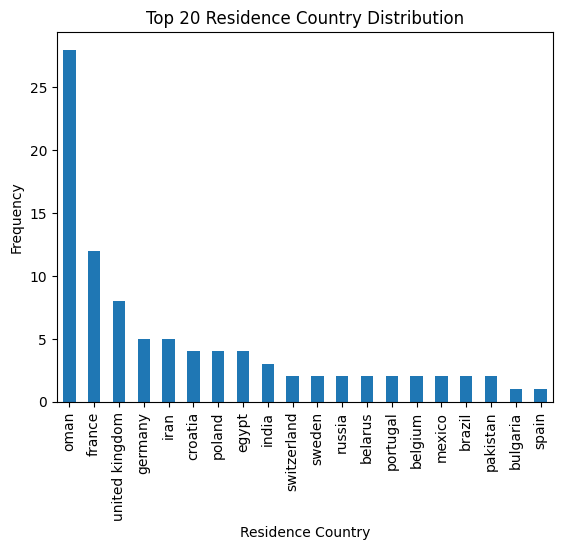

In [ ]:
getHist(df[df['Residence Country'] != 'italy'], 'Residence Country', None)

### **`Residence Italian Region`**

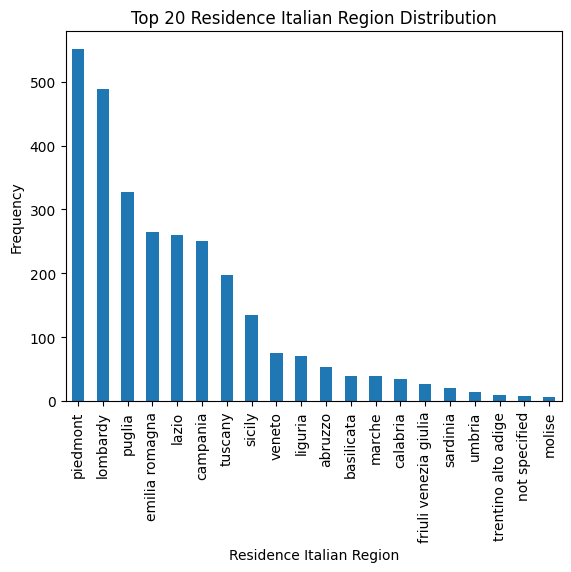

In [ ]:
getHist(df[df['Residence Italian Region'] != 'not in italy'], 'Residence Italian Region', None)

### **`Residence Italian Province`**

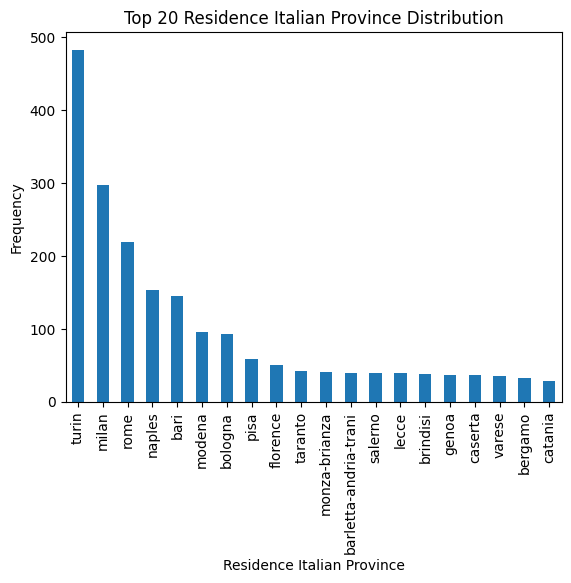

In [200]:
getHist(df[df['Residence Italian Province'] != 'not in italy'], 'Residence Italian Province', None)

### **`Residence Italian City`**

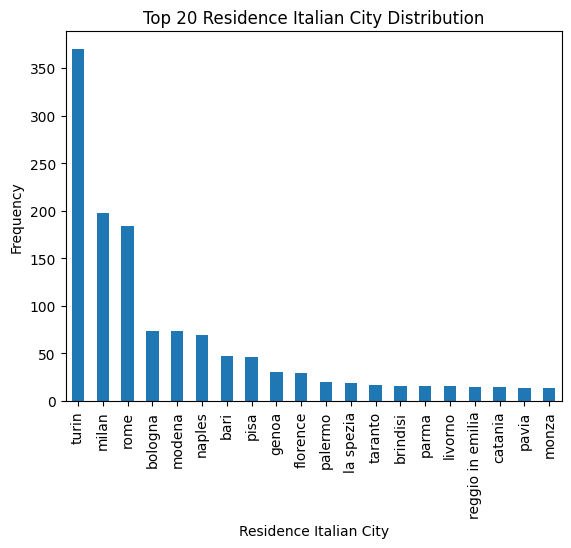

In [201]:
getHist(df[df['Residence Italian City'] != 'not in italy'], 'Residence Italian City', None)

## Data Visualization
### **Sex and Candidate State**

<ipython-input-932-f848c2304fb6>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index='Sex', columns='Candidate State', aggfunc='size', fill_value=0)


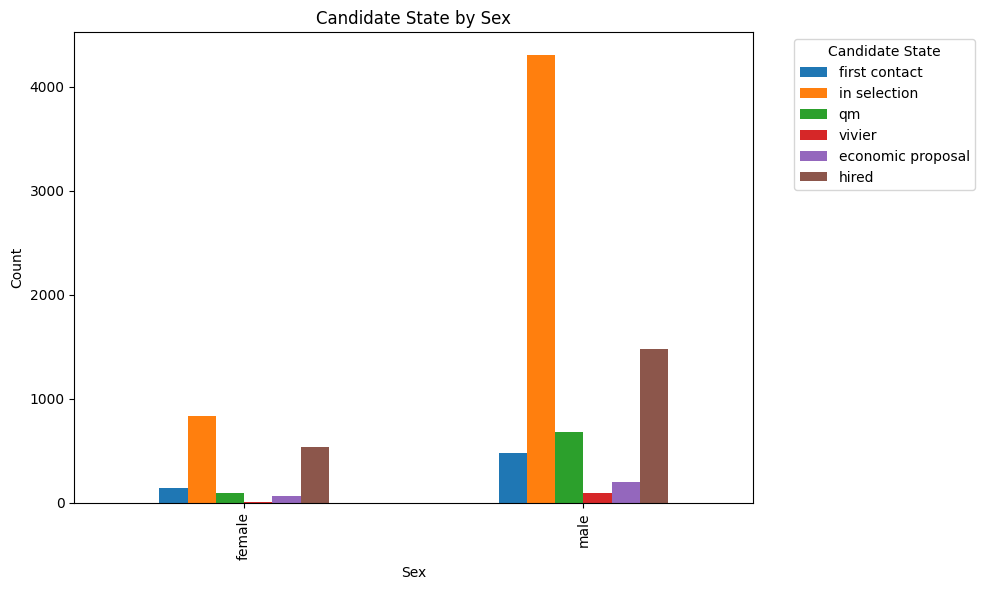

In [ ]:
pivot = df.pivot_table(index='Sex', columns='Candidate State', aggfunc='size', fill_value=0)

pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Candidate State by Sex')
plt.ylabel('Count')
plt.xlabel('Sex')
plt.legend(title='Candidate State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


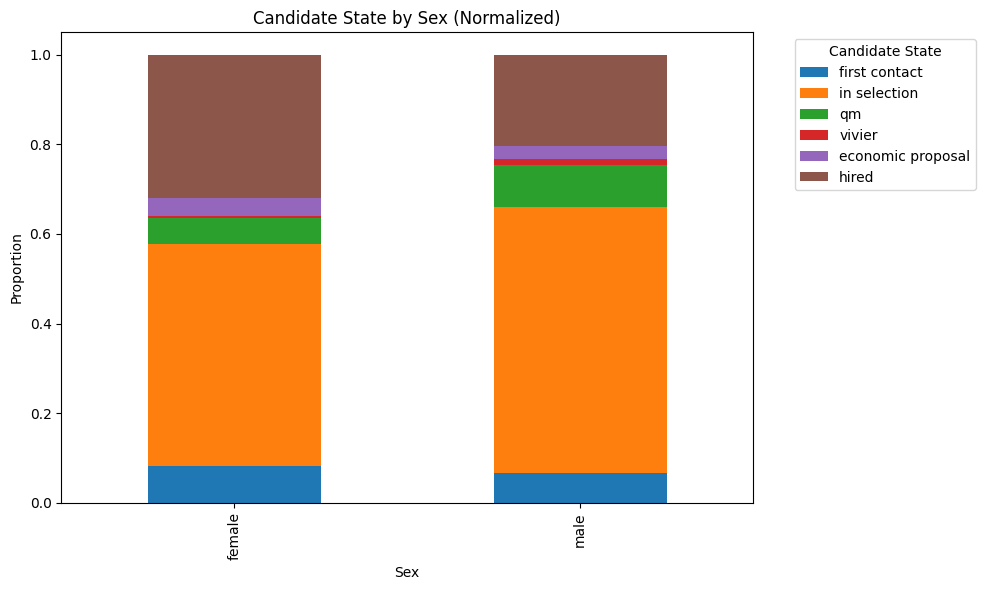

In [ ]:
pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0)

pivot_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Candidate State by Sex (Normalized)')
plt.ylabel('Proportion')
plt.xlabel('Sex')
plt.legend(title='Candidate State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### **Protected Category and Candidate State**

<ipython-input-934-6ad43d7f6e46>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index='Protected Category', columns='Candidate State', aggfunc='size', fill_value=0)


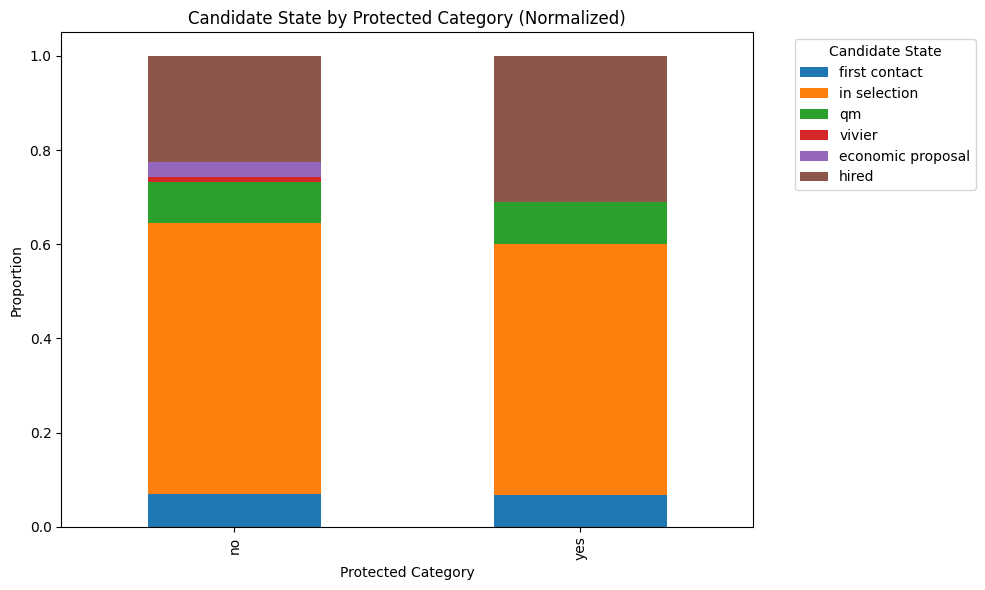

In [ ]:
pivot = df.pivot_table(index='Protected Category', columns='Candidate State', aggfunc='size', fill_value=0)
pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0)

pivot_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Candidate State by Protected Category (Normalized)')
plt.ylabel('Proportion')
plt.xlabel('Protected Category')
plt.legend(title='Candidate State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **Age Range and Candidate State**

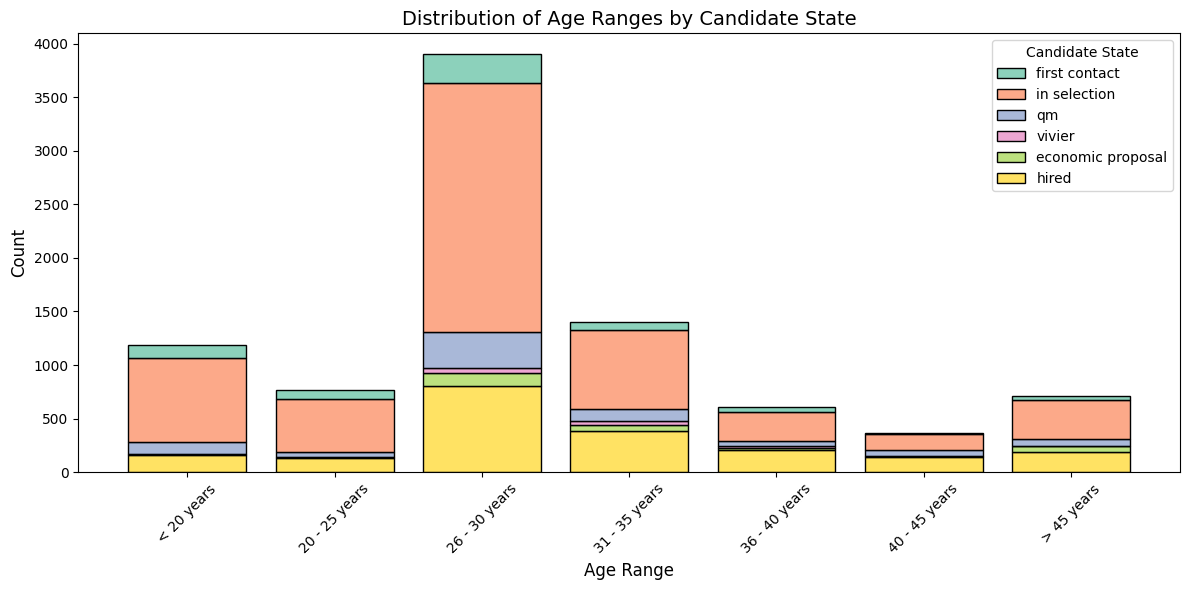

<ipython-input-935-80098279f405>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


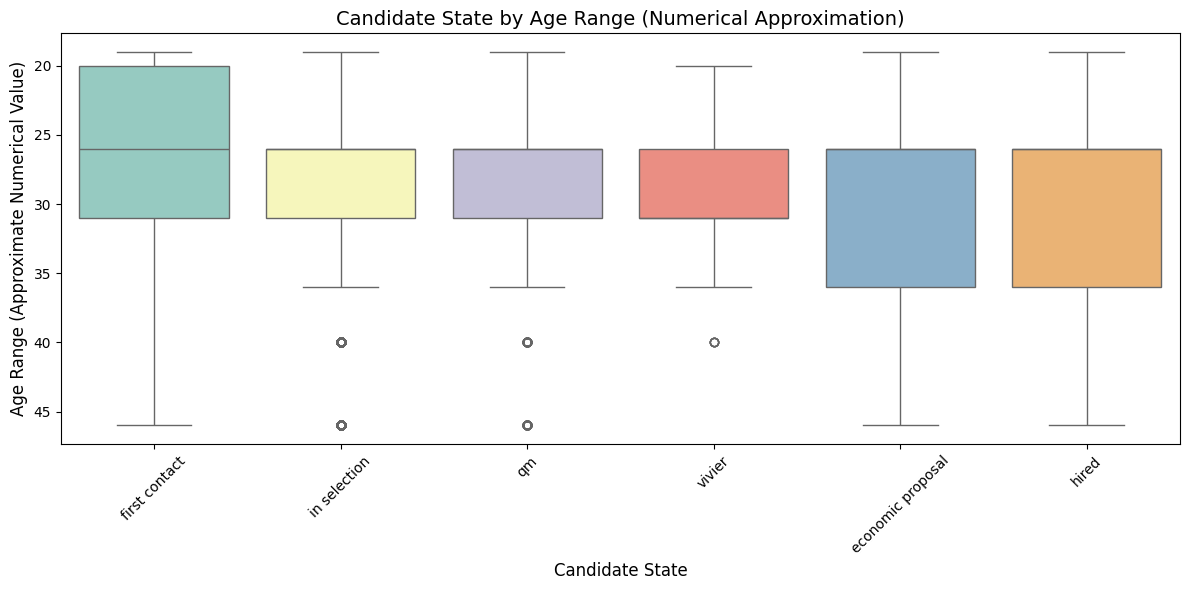

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(
    data= df,
    x='Age Range',
    hue='Candidate State',
    multiple='stack',
    palette='Set2',
    shrink=0.8,
    legend=True
)
plt.title("Distribution of Age Ranges by Candidate State", fontsize=14)
plt.xlabel("Age Range", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x='Candidate State',
    y=df['Age Range'].map(lambda x: int(x.split('-')[0]) if '-' in x else (19 if '<' in x else 46)),
    palette='Set3'
)
plt.title("Candidate State by Age Range (Numerical Approximation)", fontsize=14)
plt.xlabel("Candidate State", fontsize=12)
plt.ylabel("Age Range (Approximate Numerical Value)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **Correlation**

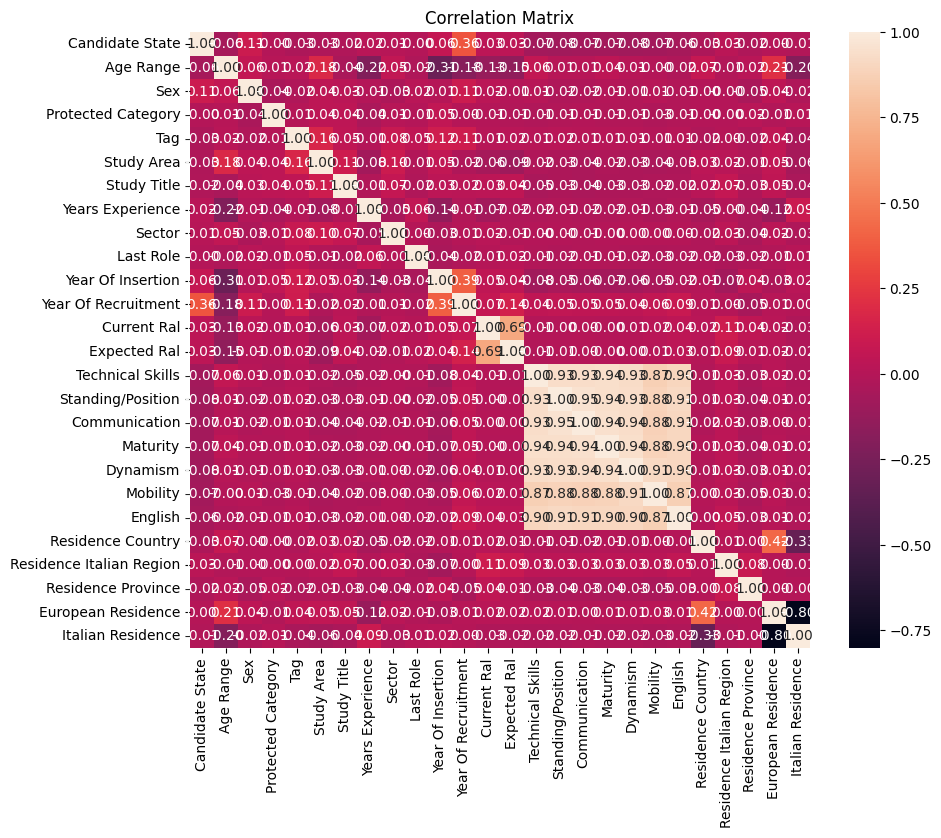

In [ ]:
df_encoded = df.copy()
df_encoded.drop(columns=job_offer_columns, inplace=True)
df_encoded.drop(columns=akkodis_col, inplace=True)

age_mapping = {
    '< 20 years': 1,
    '20 - 25 years': 2,
    '26 - 30 years': 3,
    '31 - 35 years': 4,
    '36 - 40 years': 5,
    '40 - 45 years': 6,
    '> 45 years': 7
}

df_encoded['Age Range'] = df_encoded['Age Range'].map(age_mapping)

le = LabelEncoder()

for col in df_encoded.columns:
    if col != 'Age Range':
        df_encoded[col] = df_encoded[col].astype(str)
        df_encoded[col] = le.fit_transform(df_encoded[col])

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Job Offers dataset

In [202]:
job_offers_df = df.copy()
job_offers_df = job_offers_df[job_offer_columns].drop_duplicates()
filtered_df = job_offers_df.copy()
filtered_df.drop(columns='Linked_Search__Key', inplace=True)
indexes = filtered_df[(filtered_df == 'not specified').all(axis=1)].index

job_offers_df = job_offers_df.drop(indexes)
job_offers_df = job_offers_df.reset_index(drop=True)

In [203]:
job_offers_df['ID'] = job_offers_df.index
job_offers_df = job_offers_df[['ID'] + [col for col in job_offers_df.columns if col != 'ID']]

In [204]:
print(f"There are {job_offers_df.shape[0]} job offers")

There are 475 job offers


In [205]:
job_offers_df.head()

ID                   Recruitment Request Assumption Headquarters  \
0   0  wiring harness architecture engineer                 vicenza   
1   1                    v&v - t&c engineer                    bari   
2   2  powertrain calibration engineer - to                   turin   
3   3        internship - cleaning cat prot                   turin   
4   4                   front-end developer                 bologna   

             Job Family Hiring     Job Title Hiring  \
0                  engineering           consultant   
1  tech consulting & solutions  advanced consultant   
2                  engineering    junior consultant   
3            enabling function              support   
4  tech consulting & solutions           consultant   

                                     Job Description  \
0  responsible for wiring harness architecture de...   
1  cbtc systems skills t&c support for plant chec...   
2  for our team in the campania area we are looki...   
3                                      not specified   
4  web developer – 03/06/23 • have 2+ years of ex...   

                                   Candidate Profile Years Experience.1  \
0  • knowledge of electrical engineering basic pr...              [0-1]   
1  • at least 1 year's experience on the commissi...              [1-3]   
2  ideal candidates have a master's degree in mec...              [0-1]   
3                                      not specified                [0]   
4  web developer – 03/06/23 • have 2+ years of ex...              [1-3]   

     Minimum Ral    Ral Maximum            Study Level  \
0  not specified         34-36k       five-year degree   
1         28-30k         30-32k      three-year degree   
2  not specified         24-26k       five-year degree   
3  not specified  not specified  middle school diploma   
4         22-24k         28-30k      three-year degree   

             Study Area.1    Linked_Search__Key  
0  electrical engineering             RS20.0146  
1  electronic engineering  RS22.1138, RS23.0135  
2  automotive engineering             RS22.0323  
3           not specified             RS19.0841  
4             informatics             RS23.0337

In [206]:
#descriptive columns
descr_job_offer_col = ['Recruitment Request', 'Job Description', 'Candidate Profile', 'Linked_Search__Key']

There are 0 (0.00%) 'not specified' for <Assumption Headquarters>




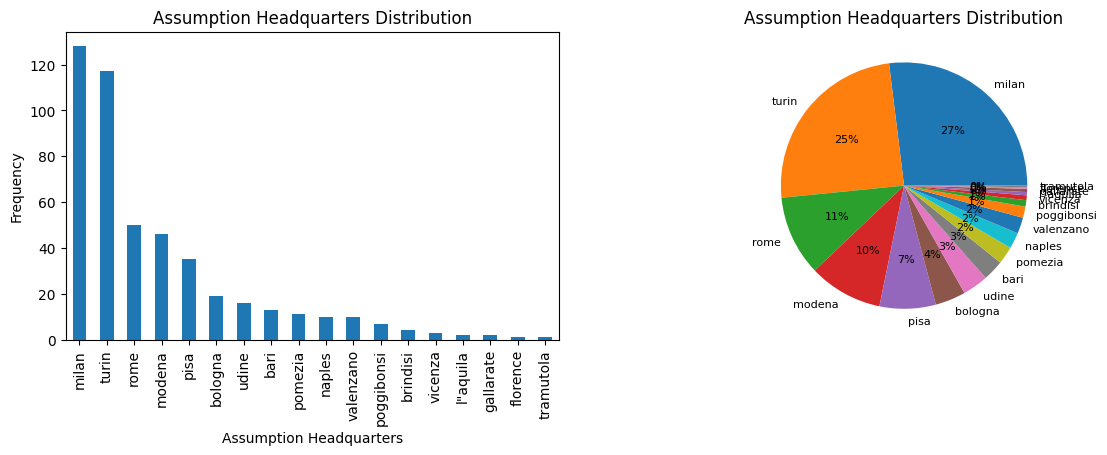




There are 0 (0.00%) 'not specified' for <Job Family Hiring>




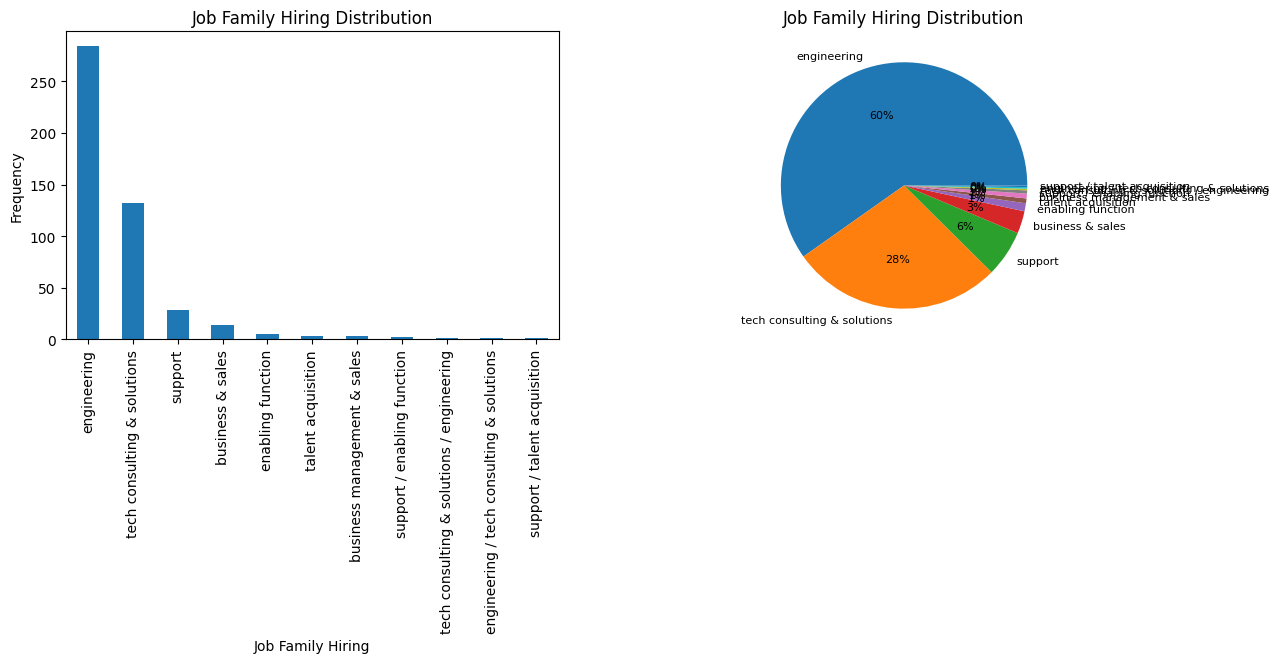




There are 29 (6.11%) 'not specified' for <Job Title Hiring>




/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


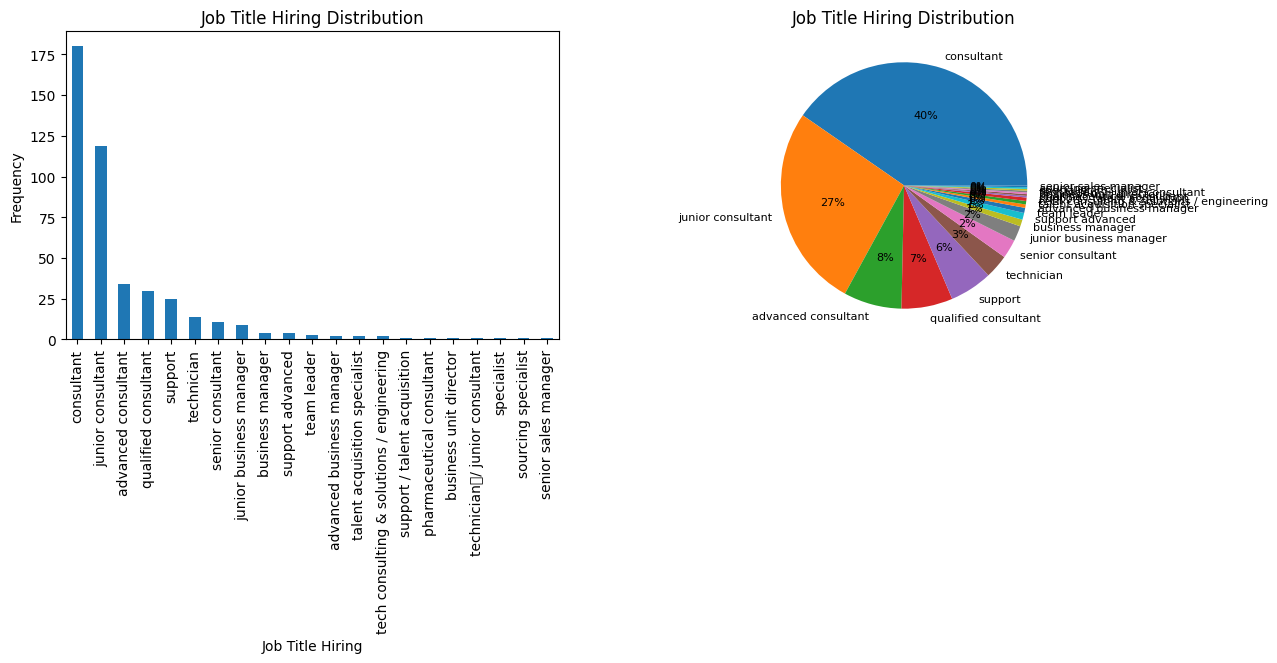




There are 61 (12.84%) 'not specified' for <Years Experience.1>




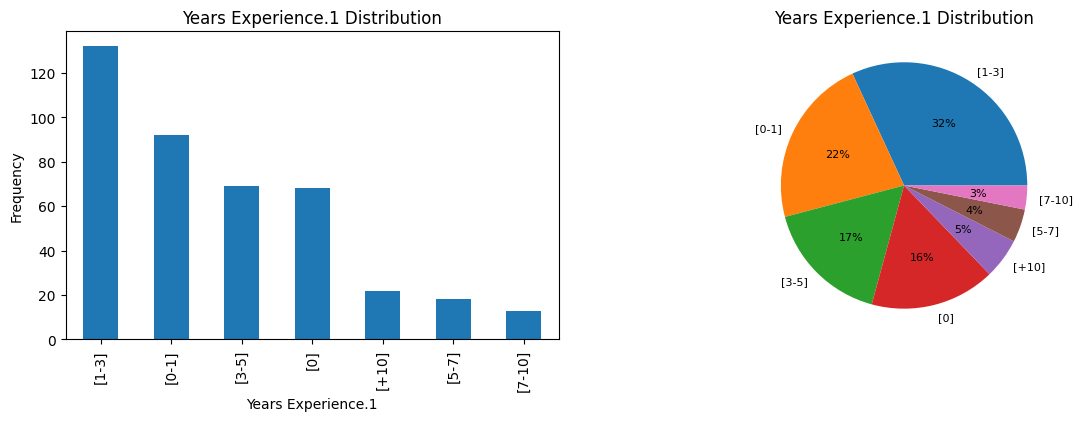




There are 251 (52.84%) 'not specified' for <Minimum Ral>




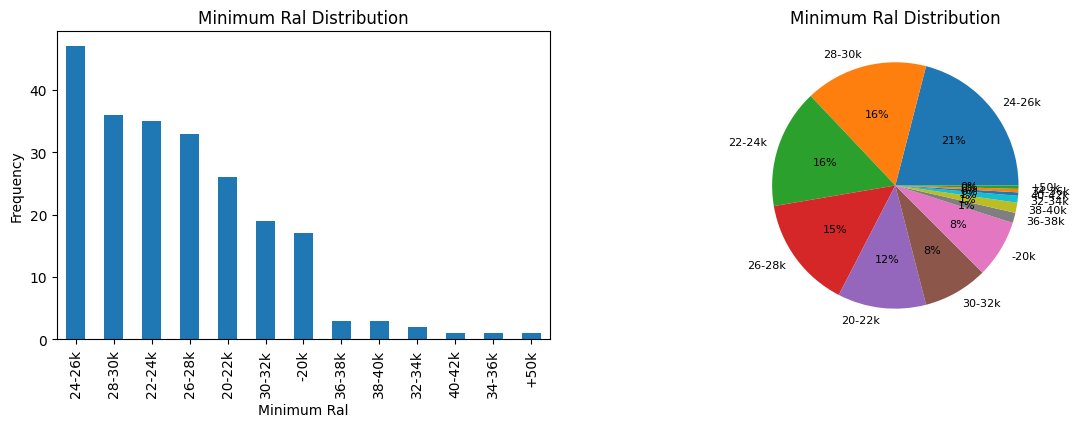




There are 181 (38.11%) 'not specified' for <Ral Maximum>




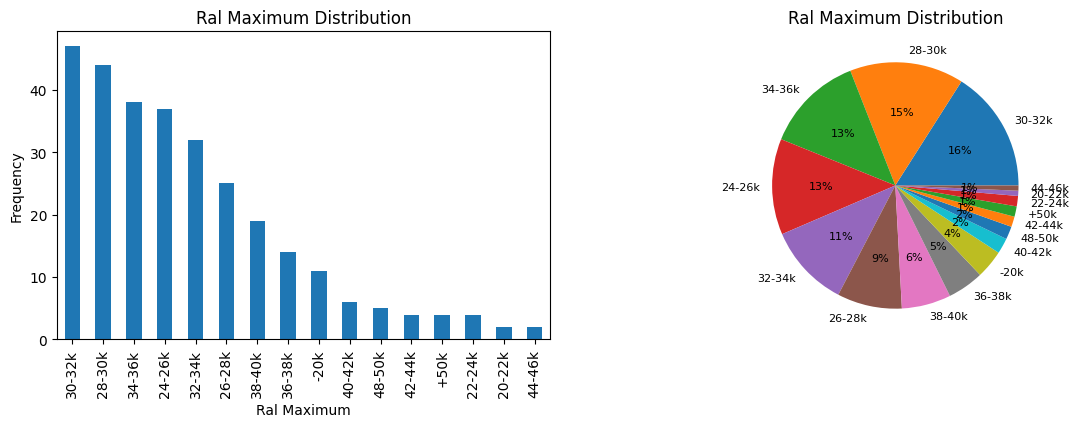




There are 61 (12.84%) 'not specified' for <Study Level>




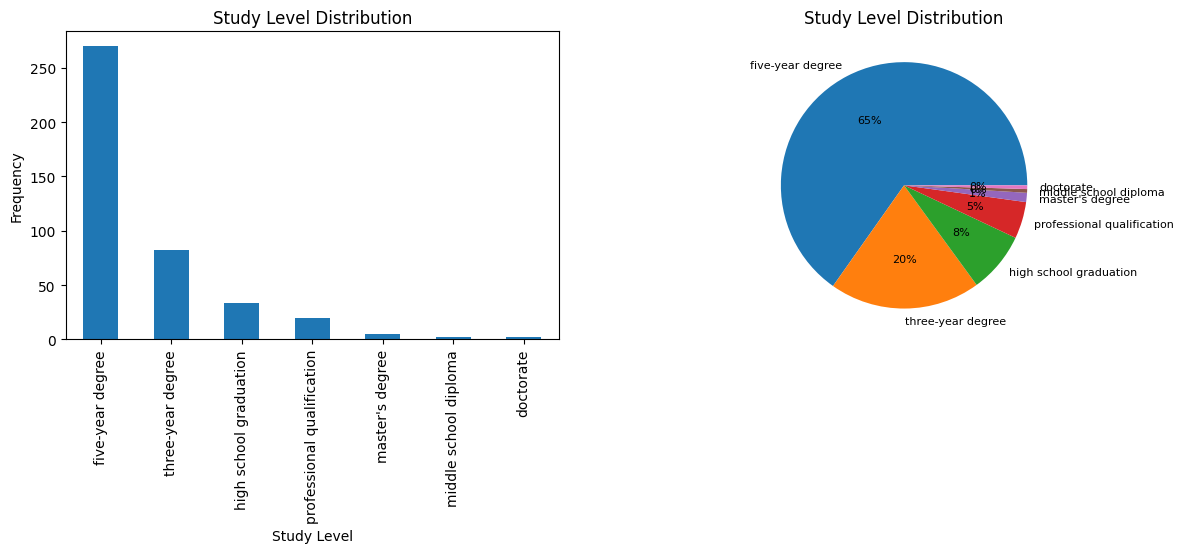




There are 111 (23.37%) 'not specified' for <Study Area.1>




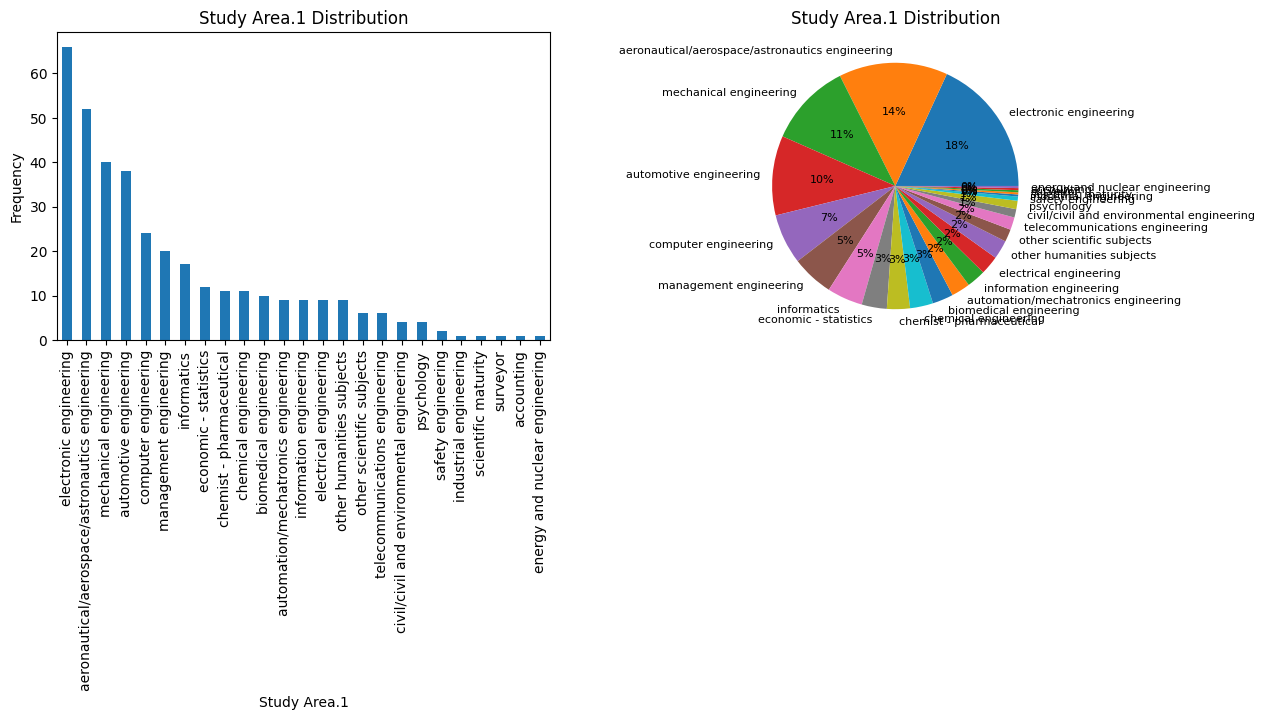

In [207]:
getJobStats()

In [208]:
col = 'Recruitment Request'
all_keywords = df.groupby('Id')[col].first().str.split(' ').explode()
keyword_counts = Counter(all_keywords)

keyword_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Count'])
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'not'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == ''].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'specified'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == '-'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'and'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == '&'].index, inplace=True)
keyword_df = keyword_df.sort_values(by='Count', ascending=False)

keyword_df.head(10)

Keyword  Count
3       engineer    161
19        junior     45
22      software     30
44       manager     30
10   calibration     20
52       project     19
98      designer     18
58          test     18
48        system     18
102   specialist     17

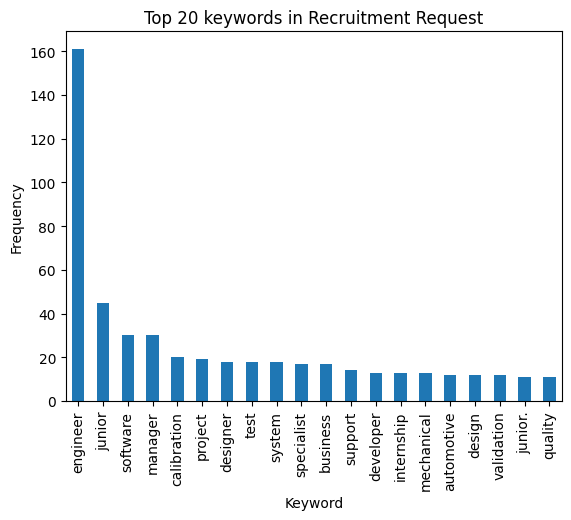

In [209]:
keyword_df.head(20).plot(x='Keyword', y='Count', kind='bar', legend=False)
plt.title(f'Top 20 keywords in {col}')
plt.ylabel('Frequency')
plt.xlabel('Keyword')
plt.show()


###Export

In [210]:
job_offers_df.to_excel(drive_dir+job_file_path, index=False)

## Candidates Dataset


### Multiple values
In order to keep one row for each candidate we need to assign a unique value for each column.
We can assign the *mean value* to numerical columns.

In [211]:
df = pd.read_excel(drive_dir + cleaned_file_path)

In [212]:
candidates = df['Id'].unique().tolist()

In [213]:
changing_cols = []

for col in df.columns:
  perc = multiple_percentage(df, col, 2, len(candidates))
  if perc > 0:
    changing_cols.append(col)
    print(f"{perc:.2f}% have multiple values for {col}")

75.45% have multiple values for Event_Type__Val
29.30% have multiple values for Event_Feedback
21.83% have multiple values for Overall
23.04% have multiple values for Technical Skills
24.79% have multiple values for Standing/Position
26.61% have multiple values for Communication
26.77% have multiple values for Maturity
29.23% have multiple values for Dynamism
29.16% have multiple values for Mobility
18.16% have multiple values for English


In [214]:
num_changing_cols = changing_cols.copy()
num_changing_cols.remove('Event_Type__Val')
num_changing_cols.remove('Event_Feedback')

For numerical columns with different values we will assign the mean value.

In [215]:
for col in num_changing_cols:
    df[col] = df.groupby('Id')[col].transform(custom_mean)

In [216]:
changing_cols = []

for col in df.columns:
  perc = multiple_percentage(df, col, 2, len(candidates))
  if perc > 0:
    changing_cols.append(col)
    print(f"{perc:.2f}% have multiple values for {col}")

75.45% have multiple values for Event_Type__Val
29.30% have multiple values for Event_Feedback


In [217]:
df = df.drop(columns=['Event_Type__Val', 'Event_Feedback'])

In [218]:
df = df.drop_duplicates()

In [219]:
df.shape[0]

2973

In [220]:
df.to_excel(drive_dir+clean2_file_path, index=False)

In [221]:
df = pd.read_excel(drive_dir + clean2_file_path)

###Candidates + Job Positions

In [222]:
df = pd.read_excel(drive_dir + clean2_file_path)

#### Target Column: **Hired**
A new column `Hired` is added to label (candidate-position) pairs.
This column will be used as **TARGET** in the training phase.

In [223]:
df['Candidate State'].value_counts()

Candidate State
in selection         1903
hired                 495
first contact         322
qm                    186
economic proposal      47
vivier                 20
Name: count, dtype: int64

In [224]:
df['Hired'] = 0
df.loc[df['Candidate State'] == 'hired', 'Hired'] = 1

We need to assign a unique ID for each job position in the jobs dataset, in order to create unique negative (candidate-position) pairs.

In [225]:
job_df = pd.read_excel(drive_dir + job_file_path)
job_df.head()

ID                   Recruitment Request Assumption Headquarters  \
0   0  wiring harness architecture engineer                 vicenza   
1   1                    v&v - t&c engineer                    bari   
2   2  powertrain calibration engineer - to                   turin   
3   3        internship - cleaning cat prot                   turin   
4   4                   front-end developer                 bologna   

             Job Family Hiring     Job Title Hiring  \
0                  engineering           consultant   
1  tech consulting & solutions  advanced consultant   
2                  engineering    junior consultant   
3            enabling function              support   
4  tech consulting & solutions           consultant   

                                     Job Description  \
0  responsible for wiring harness architecture de...   
1  cbtc systems skills t&c support for plant chec...   
2  for our team in the campania area we are looki...   
3                                      not specified   
4  web developer – 03/06/23 • have 2+ years of ex...   

                                   Candidate Profile Years Experience.1  \
0  • knowledge of electrical engineering basic pr...              [0-1]   
1  • at least 1 year's experience on the commissi...              [1-3]   
2  ideal candidates have a master's degree in mec...              [0-1]   
3                                      not specified                [0]   
4  web developer – 03/06/23 • have 2+ years of ex...              [1-3]   

     Minimum Ral    Ral Maximum            Study Level  \
0  not specified         34-36k       five-year degree   
1         28-30k         30-32k      three-year degree   
2  not specified         24-26k       five-year degree   
3  not specified  not specified  middle school diploma   
4         22-24k         28-30k      three-year degree   

             Study Area.1    Linked_Search__Key  
0  electrical engineering             RS20.0146  
1  electronic engineering  RS22.1138, RS23.0135  
2  automotive engineering             RS22.0323  
3           not specified             RS19.0841  
4             informatics             RS23.0337

We can now add a `Job Id` column and fill the right value for each position already specified.

In [226]:
df.loc[df['Candidate State'] == 'hired', 'Job ID'] = df[df['Candidate State'] == 'hired'].apply(lambda row: job_id_finder(row, job_df), axis=1)

In [227]:
df[
    df['Hired'] == 1
][['Id', 'Job ID']]

Id  Job ID
0         4     0.0
9        62     1.0
15       98     2.0
25      152     3.0
28      165     4.0
...     ...     ...
2927  80568   470.0
2947  81100   471.0
2954  81278   472.0
2963  81452   473.0
2966  81510   474.0

[495 rows x 2 columns]

In [228]:
position_columns = ['Recruitment Request', 'Job Family Hiring', 'Job Title Hiring',
                    'Job Description', 'Candidate Profile', 'Study Area.1']

job_df['Position_Info'] = job_df[position_columns].apply(lambda x: ' '.join(clean_text(str(v)) for v in x), axis=1)
job_df['Position_Info'] = job_df['Position_Info'].apply(lambda x: ' '.join(dict.fromkeys(x.split())))

candidate_columns = ['Tag', 'Study Area', 'Sector', 'Last Role']
df['Candidate_Info'] = df[candidate_columns].apply(lambda x: ' '.join(clean_text(str(v)) for v in x), axis=1)
df['Candidate_Info'] = df['Candidate_Info'].apply(lambda x: ' '.join(dict.fromkeys(x.split())))

combined_info = pd.concat([df['Candidate_Info'], job_df['Position_Info']], ignore_index=True)

tfidf = TfidfVectorizer(stop_words=stop_words)
combined_tfidf = tfidf.fit_transform(combined_info)

candidate_tfidf = combined_tfidf[:len(df)]
position_tfidf = combined_tfidf[len(df):]

similarity = cosine_similarity(candidate_tfidf, position_tfidf)


In [229]:
def get_wrong_jobs(candidate_id, similarity, df, job_df, k=5):
    if candidate_id not in df['Id'].values:
        raise ValueError(f"candidate's ID {candidate_id} doesn't exist.")

    candidate_index = df[df['Id'] == candidate_id].index[0]

    similarity_matrix_row = df[df['Id'] == candidate_id].index.get_loc(candidate_index)

    if similarity_matrix_row >= similarity.shape[0]:
        raise IndexError(f"candidate's index {similarity_matrix_row} out of bounds of similarity matrix.")

    similarity_scores = similarity[similarity_matrix_row]

    bottom_k_indices = similarity_scores.argsort()[:k][::-1]

    if any(idx >= len(job_df) for idx in bottom_k_indices):
        raise IndexError(f"one or more indexes ({bottom_k_indices}) out of bounds in job_df.")

    bottom_k_job_ids = job_df.iloc[bottom_k_indices]['ID'].tolist()

    candidate_job_id = df.loc[df['Id'] == candidate_id, 'Job ID'].values[0]

    if candidate_job_id in bottom_k_job_ids:
        bottom_k_job_ids.remove(candidate_job_id)

    return bottom_k_job_ids

In [230]:
def get_similar_jobs(candidate_id, similarity, df, job_df, k=5):
    if candidate_id not in df['Id'].values:
        raise ValueError(f"candidate's ID {candidate_id} doesn't exist.")

    candidate_index = df[df['Id'] == candidate_id].index[0]

    similarity_matrix_row = df[df['Id'] == candidate_id].index.get_loc(candidate_index)

    if similarity_matrix_row >= similarity.shape[0]:
        raise IndexError(f"candidate's index {similarity_matrix_row} out of bounds of similarity matrix.")

    similarity_scores = similarity[similarity_matrix_row]

    top_k_indices = similarity_scores.argsort()[-k:][::-1]

    if any(idx >= len(job_df) for idx in top_k_indices):
        raise IndexError(f"one or more indexes ({top_k_indices}) out of bounds in job_df.")

    top_k_job_ids = job_df.iloc[top_k_indices]['ID'].tolist()

    candidate_job_id = df.loc[df['Id'] == candidate_id, 'Job ID'].values[0]

    if candidate_job_id in top_k_job_ids:
        top_k_job_ids.remove(candidate_job_id)

    return top_k_job_ids


In [231]:
k = 1
hired_candidates = df[df['Candidate State'] == 'hired']
job_ids = job_df['ID'].tolist()
negative_rows = []

for _, candidate in hired_candidates.iterrows():
    wrong_job_ids = get_wrong_jobs(candidate['Id'], similarity, df, job_df)
    if len(wrong_job_ids) < k:
      raise ValueError(f"not enough job_ids.")
    random_job_ids = np.random.choice(wrong_job_ids, size=k, replace=False)

    for random_job_id in random_job_ids:
        negative_row = candidate.copy()
        negative_row['Job ID'] = random_job_id
        negative_row['Hired'] = 0

        job_info = job_df[job_df['ID'] == random_job_id].iloc[0]
        for col in job_df.columns:
            if col != 'ID' and col != 'Position_Info':
                negative_row[col] = job_info[col]

        negative_rows.append(negative_row)

negative_df = pd.DataFrame(negative_rows)
df_with_negatives = pd.concat([df, negative_df], ignore_index=True)

print(df_with_negatives)


         Id Candidate State      Age Range     Sex Protected Category  \
0         4           hired  26 - 30 years    male                 no   
1         8          vivier  26 - 30 years    male                 no   
2        24    in selection     < 20 years    male                 no   
3        25    in selection  20 - 25 years    male                 no   
4        27    in selection  26 - 30 years    male                 no   
...     ...             ...            ...     ...                ...   
3463  80568           hired  26 - 30 years  female                 no   
3464  81100           hired  26 - 30 years    male                 no   
3465  81278           hired  26 - 30 years    male                 no   
3466  81452           hired  26 - 30 years    male                 no   
3467  81510           hired  26 - 30 years  female                 no   

                                                    Tag  \
0     catia (harness, part design, sheet metal), cat...   
1    

For each candidate with `Candidate State` != 'Hired' we add **k** rows with **k** random job positions, labeled with `Hired` = 0. The original rows with no position specified are removed.

In [232]:
k = 2
not_hired_candidates = df[df['Candidate State'] != 'hired']
job_ids = job_df['ID'].tolist()
negative_rows = []

for _, candidate in not_hired_candidates.iterrows():
    size = k // 2
    wrong_job_ids = get_wrong_jobs(candidate['Id'], similarity, df, job_df)
    if len(wrong_job_ids) < size:
      raise ValueError(f"not enough job_ids.")
    random_job_ids = np.random.choice(wrong_job_ids, size=k, replace=False)

    similar_job_ids = get_similar_jobs(candidate['Id'], similarity, df, job_df)
    if len(similar_job_ids) < k-size:
      raise ValueError(f"not enough job_ids.")
    random_job_ids = list(random_job_ids) + np.random.choice(similar_job_ids, size=k-size, replace=False).tolist()
    random_job_ids = list(set(random_job_ids))

    for random_job_id in random_job_ids:
        negative_row = candidate.copy()
        negative_row['Job ID'] = random_job_id
        negative_row['Hired'] = 0

        job_info = job_df[job_df['ID'] == random_job_id].iloc[0]
        for col in job_df.columns:
            if col != 'ID' and col != 'Position_Info':
                negative_row[col] = job_info[col]

        negative_rows.append(negative_row)

negative_df = pd.DataFrame(negative_rows)
df_with_negatives = df_with_negatives[~df_with_negatives['Id'].isin(not_hired_candidates['Id'].tolist())]
df_with_negatives_2 = pd.concat([df_with_negatives, negative_df], ignore_index=True)

print(df_with_negatives_2)


         Id Candidate State      Age Range     Sex Protected Category  \
0         4           hired  26 - 30 years    male                 no   
1        62           hired  26 - 30 years    male                 no   
2        98           hired  26 - 30 years    male                 no   
3       152           hired     > 45 years  female                yes   
4       165           hired  26 - 30 years    male                 no   
...     ...             ...            ...     ...                ...   
8419  81623    in selection  31 - 35 years    male                 no   
8420  81623    in selection  31 - 35 years    male                 no   
8421  81630    in selection  20 - 25 years    male                 no   
8422  81630    in selection  20 - 25 years    male                 no   
8423  81630    in selection  20 - 25 years    male                 no   

                                                    Tag  \
0     catia (harness, part design, sheet metal), cat...   
1    

In [233]:
df_with_negatives_2[
    df_with_negatives_2['Hired'] == 1
][['Id', 'Job ID']].head(10)

Id  Job ID
0    4     0.0
1   62     1.0
2   98     2.0
3  152     3.0
4  165     4.0
5  251     5.0
6  258     6.0
7  369     7.0
8  381     8.0
9  401     9.0

In [234]:
df = df_with_negatives_2

In [235]:
df.to_excel(drive_dir+final_file_path, index=False)

In [367]:
df = pd.read_excel(drive_dir + final_file_path)

The `Tag` column has NaN values. We check in the original dataset and then we can replace with 'Not Specified'.

In [236]:
for col in df.columns:
  num = df.loc[df[col].isna()].shape[0]
  if num > 0:
    print(f"{col}: {num}")

Tag: 3


In [ ]:
original_df = pd.read_excel(drive_dir + original_file_path)

In [ ]:
ids = df.loc[df['Tag'].isna(), 'Id'].unique().tolist()
print(original_df.loc[original_df['ID'].isin(ids)])

         ID  Candidate State      Age Range  \
6634  50822    First contact  26 - 30 years   
6635  50822    First contact  26 - 30 years   
6636  50822    First contact  26 - 30 years   
6637  50822    First contact  26 - 30 years   
7362  50822         Imported  26 - 30 years   

                                Residence     Sex  Protected category     TAG  \
6634             TURIN » Turin ~ Piedmont  Female                 NaN  N/A, X   
6635             TURIN » Turin ~ Piedmont  Female                 NaN  N/A, X   
6636             TURIN » Turin ~ Piedmont  Female                 NaN  N/A, X   
6637             TURIN » Turin ~ Piedmont  Female                 NaN  N/A, X   
7362  MAZARA DEL VALLO » Trapani ~ Sicily  Female                 NaN     NaN   

                Study area       Study Title  Years Experience  ...  \
6634  chemical engineering  Five-year degree             [0-1]  ...   
6635  chemical engineering  Five-year degree             [0-1]  ...   
6636  chemical en

In [368]:
 df['Tag'] = df['Tag'].fillna('not specified')

In [369]:
candidate_columns = ['Tag', 'Study Area', 'Sector', 'Last Role']
ids = df.loc[df['Candidate_Info'].isna(), 'Id'].unique().tolist()
df.loc[df['Id'].isin(ids), 'Candidate_Info'] = df[candidate_columns].apply(lambda x: ' '.join(clean_text(str(v)) for v in x), axis=1)
df.loc[df['Id'].isin(ids), 'Candidate_Info'] = df['Candidate_Info'].apply(lambda x: ' '.join(dict.fromkeys(x.split())))


### New columns

#### Distance
With Residence and Assumption Headquarters we can estimate the distance, through their coordinates.

`it_df` is a dataset that contains coordinates for italian cities.

In [331]:
italy_geo = pd.read_excel(drive_dir + italy_geo_path)
italy_geo['comune']= italy_geo['comune'].str.lower()

In [332]:
italy_geo.head(10)

istat           comune       lng        lat
0  1001            agliè  7.768600  45.363433
1  1002          airasca  7.484431  44.916886
2  1003     ala di stura  7.304344  45.315110
3  1004  albiano d'ivrea  7.949145  45.433893
4  1005  alice superiore  7.777019  45.460094
5  1006           almese  7.395182  45.117663
6  1007          alpette  7.578597  45.409982
7  1008        alpignano  7.524267  45.094470
8  1009         andezeno  7.869949  45.035861
9  1010          andrate  7.873839  45.528375

In [370]:
city_mapping = {
    "turin": "Torino",
    "march": "Marchirolo",
    "naples": "Napoli",
    "milan": "Milano",
    "genoa": "Genova",
    "casalnuovo di naples": "Casalnuovo di Napoli",
    "rome": "Roma",
    "nardo'": "Nardò",
    "florence": "Firenze",
    "monopolies": "Monopoli",
    "nickel": "Nichelino",
    "victory": "Vittoria",
    "farmhouse": "Cascina",
    "tour": "bari",
    "reggio in emilia": "Reggio nell'Emilia",
    "rivalta di turin": "Rivalta di Torino",
    "slow on the seveso": "Lentate sul Seveso",
    "walnuts": "Noci",
    "the loggia": "La Loggia",
    "valentine's day in abruzzo citeriore": "San Valentino in Abruzzo Citeriore",
    "yield": "Rende",
    "san paolo beautiful site": "San Paolo Bel Sito",
    "varano villages": "Varano Borghi",
    "neptune": "Nettuno",
    "syracuse": "Siracusa",
    "melito di naples": "Melito di Napoli",
    "island of female": "Isola delle Femmine",
    "touch of casauria": "Tocco da Casauria",
    "ara": "Novara",
    "vast": "Vasto",
    "slaughterhouse": "Macello",
    "cuorgne'": "Cuorgnè",
    "padua": "Padova",
    "hospitaletto": "Ospitaletto",
    "saint gregorio of catania": "San Gregorio di Catania",
    "venice": "Venezia",
    "engraved in the arno valley": "Figline e Incisa Valdarno",
    "power": "Potenza",
    "forli'": "Forlì",
    "po cut": "Taglio di Po",
    "lower nocera": "Nocera Inferiore",
    "pessano": "Pessano con Bornago",
    "trent": "Trento",
    "castegnate olona": "Castellanza",
    "ligurian stone": "Pietra Ligure",
    "mugnano di naples": "Mugnano di Napoli",
    "august": "Agosta",
    "sweaters": "Maglie",
    "palazzo san gevasio": "Palazzo San Gervasio",
    "briano's villa": "Villa di Briano",
    "fourth": "Quarto",
    "dinner below": "Cenate Sotto",
    "san nicolao valley": "Valle San Nicolao",
    "vesuvian sum": "Somma Vesuviana",
    "chors": "Cori",
    "catholic": "Cattolica",
    "cirie'": "Ciriè",
    "funds": "Fondi",
    "cream": "Crema",
    "velate usmate": "Usmate Velate",
    "affori": "Milano",
    "balm": "Cinisello Balsamo",
    "boxes in pittari": "Caselle in Pittari",
    "song": "Cantù",
    "lenno": "tremezzina",
    "santo stino di livenza": "San Stino di Livenza",
    "seek": "Palermo",
    "mirror": "Specchia",
    "castelletto above ticino": "Castelletto sopra Ticino",
    "barcelona pozzo di gotto": "Barcellona Pozzo di Gotto",
    "marine": "Roma",
    "seas": "Cuneo",
    "acceptance": "Accettura",
    "peoples": "Popoli",
    "lower venue": "Venaria Reale",
    "pheach": "Pescia",
    "fortress": "Bolzano",
    "scroll": "Rotella",
    "lupia campaign": "Campagna Lupia",
    "aragon": "Aragona",
    "muggio'": "Muggiò",
    "crespina": "Crespina Lorenzana",
    "concordia on the secchia": "Concordia sulla Secchia",
    "veronese goat": "Caprino Veronese",
    "porticos": "Portici",
    "dragons": "Dragoni",
    "liri island": "Isola del Liri",
    "saint john theatinus": "San Giovanni Teatino",
    "citta' sant'angelo": "Città Sant'Angelo",
    "mondovi'": "Mondovì",
    "bridge": "Ponte",
    "rounds": "Avellino",
    "makeup": "Milano",
    "loved": "Amato",
    "lucernate": "Milano",
    "saracen market": "Mercato Saraceno",
    "channel": "Canale",
    "rich from the gulf of spezia": "Riccò del Golfo di Spezia",
    "they ciuffenna": "Loro Ciuffenna",
    "boville": "Boville Ernica",
    "occhieppo lower": "Occhieppo Inferiore",
    "new source": "Fonte Nuova",
    "villa d'alme'": "Villa d'Almè",
    "matterhorn": "Cervino",
    "zane'": "Zanè",
    "marano di naples": "Marano di Napoli",
    "soriano in cimino": "Soriano nel Cimino",
    "adriatic dawn": "Alba Adriatica",
    "rooms": "Novara",
    "bustighera": "Busto Garolfo",
    "bitter": "Amaro",
    "san severino market": "Mercato San Severino",
    "oil bridge": "Ponte dell'Olio",
    'l"aquila':"L'Aquila",
    'chiosi porta cremonese': 'Milano',
    'ronchi dei legionarie': 'Ronchi dei Legionari',
    'montecatini terme': 'Montecatini-Terme',
    'agliate': 'Milano',
    'borgo mantovano': 'Mantova',
    "masera' di padova": 'Maserà di Padova',
    'scarperia': 'Scarperia e San Piero',
    'mestre': 'Venezia',
    'sestri ponente': 'Genova',
    'albusciago': 'sumirago',
    'bornate': 'Serravalle Sesia',
    'povo': 'Trento',
    'briavacca': 'Rodano',
    'san pietro bestazzo': 'Cisliano',
    'trino vercellese': 'Trino',
    'none':'Torino'
}

In [375]:
df[df['Residence Italian City']=='not specified'][['Residence Italian Region', 'Residence Italian Province', 'Residence Country']]

Residence Italian Region Residence Italian Province Residence Country
97              not specified              not specified             italy
332             not specified              not specified             italy
592             not specified              not specified             italy
827             not specified              not specified             italy
1026            not specified              not specified             italy
1027            not specified              not specified             italy
1028            not specified              not specified             italy
2187            not specified              not specified             italy
2188            not specified              not specified             italy
2189            not specified              not specified             italy
3309            not specified              not specified             italy
3310            not specified              not specified             italy
3311            not specified              not specified             italy
4059            not specified              not specified             italy
4060            not specified              not specified             italy
4061            not specified              not specified             italy
5352            not specified              not specified             italy
5353            not specified              not specified             italy
5354            not specified              not specified             italy
8238            not specified              not specified             italy
8239            not specified              not specified             italy
8240            not specified              not specified             italy

In [371]:
df['Residence Italian City'] = df['Residence Italian City'].apply(lambda x: x if x not in city_mapping.keys() else city_mapping[x])
df['Residence Italian City'] = df['Residence Italian City'].str.lower()
df['Assumption Headquarters'] = df['Assumption Headquarters'].apply(lambda x: x if x not in city_mapping.keys() else city_mapping[x])
df['Assumption Headquarters'] = df['Assumption Headquarters'].str.lower()

In [372]:
city_list  = df['Residence Italian City'].unique().tolist()
city_list = [str(c).lower() for c in city_list]
cities = italy_geo['comune'].unique().tolist()
cities = [str(c).lower() for c in cities]
for c in city_list:
  if c not in cities:
    print(c)

not in italy
not specified


In [373]:
assumption_list = df['Assumption Headquarters'].unique().tolist()
assumption_list = [str(c).lower() for c in assumption_list]
for c in assumption_list:
  if c not in cities:
    print(c)

In [378]:
city_to_coords = {
    row['comune']: (row['lat'], row['lng'])
    for _, row in italy_geo.iterrows()
}

def get_coords(city):
    return city_to_coords.get(city, (None, None))

df['Residence_coord'] = df['Residence Italian City'].apply(get_coords)
df.loc[df['Residence Italian City'] == 'not specified', 'Residence_coord'] = df.loc[df['Residence Italian City'] == 'not specified', 'Residence_coord'].apply(lambda x: get_coords('roma'))
df['Assumption_coord'] = df['Assumption Headquarters'].apply(get_coords)

`countries_df` is a dataset that contains coordinates for countries.

In [379]:
countries_df = pd.read_csv(drive_dir + countries_csv_path)

In [380]:
for country in df['Residence Country'].unique():
  if country.title() not in countries_df['name'].unique():
    print(f"{country}: {country.title() in countries_df['name'].unique()}")

yugoslavia: False
serbia and montenegro: False


In [381]:
country_coords = {
    row['name'].lower(): (row['latitude'], row['longitude'])
    for _, row in countries_df.iterrows()
}

def get_residence_coord(row):
    if row['Residence Country'] == 'italy':
      return row['Residence_coord']
    elif row['Residence Country'] in ['yugoslavia', 'serbia and montenegro']:
        return (44.787197, 20.457273)
    return country_coords.get(row['Residence Country'], None)

df['Residence_coord'] = df.apply(get_residence_coord, axis=1)


In [382]:
df[['Residence Italian City','Residence_coord']]

Residence Italian City             Residence_coord
0         pomigliano d'arco  (40.90689555, 14.39335586)
1        santeramo in colle   (40.79461702, 16.7525404)
2                    torino    (45.0732745, 7.68068748)
3                    torino    (45.0732745, 7.68068748)
4          sesto fiorentino  (43.83219044, 11.19842773)
...                     ...                         ...
8419                   roma  (41.89277044, 12.48366723)
8420                   roma  (41.89277044, 12.48366723)
8421                   roma  (41.89277044, 12.48366723)
8422                   roma  (41.89277044, 12.48366723)
8423                   roma  (41.89277044, 12.48366723)

[8424 rows x 2 columns]

In [383]:
df['Distance (km)'] = df.apply(calculate_distance, axis=1)

In [384]:
df[['Residence Italian Province', 'Assumption Headquarters', 'Distance (km)']].sort_values(by='Distance (km)', ascending=False)

Residence Italian Province Assumption Headquarters  Distance (km)
4971               not in italy                    roma   12110.266737
4972               not in italy                    roma   12110.266737
4973               not in italy                  milano   12091.173236
1385               not in italy                  milano   10682.513090
1383               not in italy                    pisa   10676.737967
...                         ...                     ...            ...
3650                      milan                  milano       0.000000
3640                       rome                    roma       0.000000
3639                       rome                    roma       0.000000
3629                       rome                    roma       0.000000
4212                       rome                    roma       0.000000

[8424 rows x 3 columns]

#### Similarity_Score
The similarity score between candidate's descriptive columns and job offer's descriptive columns can be obtained through the cosine_similarity.

In [385]:
print(job_df.loc[job_df['Position_Info'].isna()].shape[0])

0


In [386]:
df['Position_Info'] = df['Job ID'].apply(lambda jobid: job_df.loc[job_df['ID'] == jobid, 'Position_Info'].values[0])

In [387]:
combined_info = pd.concat([df['Candidate_Info'], df['Position_Info']])

tfidf = TfidfVectorizer()
combined_tfidf = tfidf.fit_transform(combined_info)

candidate_tfidf = combined_tfidf[:len(df)]
position_tfidf = combined_tfidf[len(df):]

similarity = cosine_similarity(candidate_tfidf, position_tfidf)

df['Similarity_Score'] = [round(similarity[i, i], 2) for i in range(len(df))]

In [388]:
df_sorted = df.sort_values(by='Similarity_Score', ascending=False)

top_n = 10
print(df_sorted[['Candidate_Info', 'Position_Info', 'Similarity_Score']].head(top_n))

                                        Candidate_Info  \
312  navigation algorithms, robotics automationmech...   
140                                economic statistics   
289                                economic statistics   
148                                economic statistics   
181  aeronauticalaerospaceastronautics engineering ...   
319                         accounting cobol developer   
38   sap, atlas, easydoc politicalsocial life scien...   
204  automationmechatronics engineering consulting ...   
76   qhse, iso 9001, 14001, 18001, rspp, constructi...   
975  computer engineering consulting advanced consu...   

                                         Position_Info  Similarity_Score  
312  navigation engineer underwater tech consulting...              0.61  
140  internship controlling support economic statis...              0.61  
289            controllers support economic statistics              0.60  
148            controllers support economic statistics       

In [390]:
df.to_excel(drive_dir + final_file_path, index=False)

#### Similarity_Score_Study_Area

In [391]:
df['Similarity_Score_Study_Area'] = 0

filtered_df = df.loc[
    (df['Study Area'] != 'not specified') &
    (df['Study Area'] != 'other') &
    (df['Study Area.1'] != 'not specified')
]

combined_info = pd.concat([filtered_df['Study Area'], filtered_df['Study Area.1']])

tfidf = TfidfVectorizer()
combined_tfidf = tfidf.fit_transform(combined_info)

candidate_tfidf = combined_tfidf[:len(filtered_df)]
position_tfidf = combined_tfidf[len(filtered_df):]

similarity = cosine_similarity(candidate_tfidf, position_tfidf)

similarity_scores = [round(similarity[i, i], 2) for i in range(len(filtered_df))]

df.loc[filtered_df.index, 'Similarity_Score_Study_Area'] = similarity_scores


<ipython-input-391-fdd51a79cb21>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.07, 1.0, 0.16, 1.0, 0.16, 0.14, 0.16, 1.0, 1.0, 0.0, 0.07, 0.0, 0.0, 0.14, 0.08, 1.0, 0.16, 0.07, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.18, 0.14, 1.0, 0.0, 1.0, 1.0, 0.16, 0.09, 0.0, 0.09, 0.08, 1.0, 0.14, 1.0, 0.1, 0.14, 0.14, 0.16, 0.09, 0.0, 1.0, 0.08, 0.14, 0.16, 0.0, 0.0, 1.0, 0.03, 0.16, 1.0, 0.14, 1.0, 0.09, 1.0, 1.0, 0.18, 0.0, 0.09, 0.16, 0.0, 0.08, 0.0, 1.0, 0.11, 0.18, 0.06, 0.16, 0.07, 1.0, 0.0, 1.0, 1.0, 0.08, 0.18, 1.0, 0.16, 1.0, 0.1, 1.0, 1.0, 0.0, 0.07, 1.0, 0.11, 0.18, 1.0, 0.08, 1.0, 1.0, 1.0, 0.0, 0.08, 0.06, 0.0, 1.0, 0.07, 0.11, 1.0, 0.08, 0.08, 0.0, 0.12, 1.0, 1.0, 0.08, 0.09, 0.0, 1.0, 1.0, 0.1, 0.0, 0.08, 0.08, 0.0, 0.0, 0.16, 0.15, 0.0, 0.16, 1.0, 1.0, 1.0, 0.05, 0.0, 0.12, 0.08, 0.07, 0.0, 0.18, 1.0, 1.0, 0.06, 0.08, 1.0, 0.0, 1.0, 0.06, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.18, 1.0, 0.0, 1

In [392]:
df_sorted = df.sort_values(by='Similarity_Score_Study_Area', ascending=True)

top_n = 15000
print(df_sorted[['Study Area', 'Study Area.1', 'Similarity_Score_Study_Area']].head(top_n))


                                           Study Area  \
4211  aeronautical/aerospace/astronautics engineering   
5286                           mechanical engineering   
5285  aeronautical/aerospace/astronautics engineering   
5284  aeronautical/aerospace/astronautics engineering   
5282                        other humanities subjects   
...                                               ...   
4629                           mechanical engineering   
4612                        other scientific subjects   
577                         other scientific subjects   
617                         other humanities subjects   
3709                           mechanical engineering   

                   Study Area.1  Similarity_Score_Study_Area  
4211              not specified                          0.0  
5286  other humanities subjects                          0.0  
5285              not specified                          0.0  
5284  other scientific subjects                          0.0  


#### Study_Title_Score

In [393]:
#Study title score
study_title_order = {
    'middle school diploma': 1,
    'high school graduation': 2,
    'professional qualification': 3,
    'three-year degree': 4,
    'five-year degree': 5,
    'master\'s degree': 6,
    'doctorate': 7}

In [394]:
df['Study_Title_Score'] = df.apply(lambda row: check_study_title(row['Study Level'].lower(), row['Study Title'].lower()), axis=1)

In [395]:
df_sorted = df.sort_values(by='Study_Title_Score', ascending=True)

top_n = 15000
print(df_sorted[['Study Title', 'Study Level', 'Study_Title_Score']].head(top_n))


                 Study Title             Study Level  Study_Title_Score
1948  high school graduation         master's degree              -0.57
7927  high school graduation         master's degree              -0.57
1470  high school graduation         master's degree              -0.57
7323  high school graduation         master's degree              -0.57
455   high school graduation         master's degree              -0.57
...                      ...                     ...                ...
5614               doctorate  high school graduation               0.71
5615               doctorate  high school graduation               0.71
4072               doctorate  high school graduation               0.71
2332               doctorate  high school graduation               0.71
299                doctorate  high school graduation               0.71

[8424 rows x 3 columns]


#### Similarity_Score_Last_Role
A new column that define the similarity between the candidate's last role and the new role proposed by the job offer.

In [396]:
df['Similarity_Score_Last_Role'] = 0

filtered_df = df.loc[
    (df['Job Title Hiring'] != 'not specified') &
    (df['Last Role'] != 'not specified') &
    (df['Last Role'] != 'none')
]

combined_info = pd.concat([filtered_df['Job Title Hiring'], filtered_df['Last Role']])

tfidf = TfidfVectorizer()
combined_tfidf = tfidf.fit_transform(combined_info)

candidate_tfidf = combined_tfidf[:len(filtered_df)]
position_tfidf = combined_tfidf[len(filtered_df):]

similarity = cosine_similarity(candidate_tfidf, position_tfidf)

similarity_scores = [round(similarity[i, i], 2) for i in range(len(filtered_df))]

df.loc[filtered_df.index, 'Similarity_Score_Last_Role'] = similarity_scores


<ipython-input-396-b3c73718b673>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.44, 0.0, 0.67, 0.0, 0.35, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.89, 0.0, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.44, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24, 0.0, 0.0, 0.0, 0.0, 0.34, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [397]:
df_sorted = df.sort_values(by='Similarity_Score_Last_Role', ascending=False)

top_n = 100
print(df_sorted[['Last Role', 'Job Title Hiring', 'Similarity_Score_Last_Role']].head(top_n))

                                             Last Role      Job Title Hiring  \
181                                         consultant            consultant   
405                               senior sales manager  senior sales manager   
3628                                        consultant            consultant   
3617                                        consultant            consultant   
3615                                        consultant            consultant   
...                                                ...                   ...   
5489                        junior saleforce developer     junior consultant   
4874                   embedded developer (consultant)            consultant   
7973  laboratory technician in quality control and r&d            technician   
4871                                 junior consultant  qualified consultant   
2877           sampler technician and chemical analyst            technician   

      Similarity_Score_Last_Role  
181 

####Years_Exp_Score
You can assign a score to the difference between the candidate's years of experience and those required by the job position.

In [398]:
years_exp_order = {
    '[0]': 0,
    '[0-1]': 0.5,
    '[1-3]': 2,
    '[3-5]': 4,
    '[5-7]': 6,
    '[7-10]': 8.5,
    '[+10]': 20
}

In [399]:
df['Years_Exp_Score'] = df.apply(lambda row: check_years_exp(row['Years Experience.1'], row['Years Experience']), axis=1)


In [400]:
df_sorted = df.sort_values(by='Years_Exp_Score', ascending=False)

top_n = 5000
print(df_sorted[df_sorted['Years Experience.1'] != 'not specified'][['Years Experience', 'Years Experience.1', 'Years_Exp_Score']].head(top_n))

     Years Experience Years Experience.1  Years_Exp_Score
1717            [+10]                [0]              1.0
6478            [+10]                [0]              1.0
6532            [+10]                [0]              1.0
3711            [+10]                [0]              1.0
1697            [+10]                [0]              1.0
...               ...                ...              ...
4638              [0]                [0]              0.0
4621              [0]                [0]              0.0
2741              [0]                [0]              0.0
2640            [1-3]              [1-3]              0.0
2647              [0]                [0]              0.0

[5000 rows x 3 columns]


#### Ral_Score

In [401]:
ral_order = {
     '-20k': 0,
     '20-22k': 11,
     '22-24k': 13,
     '24-26k': 15,
     '26-28k': 17,
     '28-30k': 19,
     '30-32k': 21,
     '32-34k': 23,
     '34-36k': 25,
     '36-38k': 27,
     '38-40k': 29,
     '40-42k': 31,
     '42-44k': 33,
     '44-46k': 35,
     '46-48k': 37,
     '48-50k': 39,
     '+50k': 60,
}

In [402]:
df['Ral_Score'] = df.apply(lambda row: check_ral(row['Minimum Ral'], row['Expected Ral']), axis=1)

In [403]:
df_sorted = df.sort_values(by='Ral_Score', ascending=False)

top_n = 5000
print(df_sorted[(df_sorted['Minimum Ral'] != 'not specified') & (df_sorted['Expected Ral'] != 'not specified')][['Expected Ral', 'Minimum Ral', 'Ral_Score']].head(top_n))

     Expected Ral Minimum Ral  Ral_Score
141          -20k      30-32k       0.35
636          -20k      24-26k       0.25
322        24-26k      36-38k       0.20
304        28-30k      40-42k       0.20
4041       20-22k      30-32k       0.17
...           ...         ...        ...
2325         +50k      22-24k      -0.78
5866         +50k      22-24k      -0.78
4579         +50k      22-24k      -0.78
2512         +50k      22-24k      -0.78
699          +50k      22-24k      -0.78

[599 rows x 3 columns]


###Export

In [404]:
df.to_excel(drive_dir + final_file_path, index=False)

In [405]:
df.columns

Index(['Id', 'Candidate State', 'Age Range', 'Sex', 'Protected Category',
       'Tag', 'Study Area', 'Study Title', 'Years Experience', 'Sector',
       'Last Role', 'Year Of Insertion', 'Year Of Recruitment',
       'Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring',
       'Job Title Hiring', 'Linked_Search__Key', 'Overall', 'Job Description',
       'Candidate Profile', 'Years Experience.1', 'Minimum Ral', 'Ral Maximum',
       'Study Level', 'Study Area.1', 'Akkodis Headquarters', 'Current Ral',
       'Expected Ral', 'Technical Skills', 'Standing/Position',
       'Communication', 'Maturity', 'Dynamism', 'Mobility', 'English',
       'Residence Country', 'Residence Italian Region',
       'Residence Italian Province', 'Residence Italian City',
       'European Residence', 'Italian Residence', 'Hired', 'Job ID',
       'Candidate_Info', 'Residence_coord', 'Assumption_coord',
       'Distance (km)', 'Position_Info', 'Similarity_Score',
       'Similarity_Score_St